### 1.0 Generating multi-label, multi-class model with BERT

Example-based experiment [BERT for Multi-label Classification](https://github.com/javaidnabi31/Multi-Label-Text-classification-Using-BERT/blob/master/multi-label-classification-bert.ipynb) and [Using BERT For Classifying Documents with Long Texts](https://github.com/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb).

#### 1.1 Load libs from RecurrentNetworks project for test dataset with BERT model

In [ ]:
# install bert if not already done
# !pip uninstall tensorflow==2.2.0
!pip install tensorflow==1.15.0
!pip install bert-tensorflow==1.0.1
!pip install keras==2.2.5

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 3.8MB 37.7MB/s 
     |████████████████████████████████| 512kB 50.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=218ddd991196b8ae61fccc5404f48b25c6147c7f1568a201714196f96208578f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
import collections
import sys
sys.path.insert(0, os.path.abspath('/content/drive/My Drive/RecurrentNetworks/'))

# Disable warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import re
import pandas.io.json as pd_json
import utils.definition_network as dn
from utils.metrics import Metrics
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

# metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [ ]:
import keras
from keras import layers
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard

In [ ]:
# BERT
import bert
from bert import optimization
from bert import tokenization
# from bert import modeling

#### 1.2 Auxiliary Functions (Load dataset and Prepare for BERT format)

In [ ]:
# The list containing all the classes (train['SECTION'].unique())
LABELS_SET_INDEX = [0,1,2]
LABELS_SET = ['control', 'anxiety', 'depression']
print(" %s = %s" % (LABELS_SET, LABELS_SET_INDEX))

 ['control', 'anxiety', 'depression'] = [0, 1, 2]


#### 1.2.1 Load Dataset 

In [ ]:
def sub_samples(path_dataset, total_by_class):
  data_df = pd.read_pickle(path_dataset)
  labels = data_df.label.unique()

  sub_samples = []
  for label in labels:
    sub_samples.append(data_df[data_df.label == label].head(total_by_class))

  return pd.concat(sub_samples)

In [ ]:
def load_datasets():
  train_df = pd.read_pickle(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_train_2640.df')
  valid_df = pd.read_pickle(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_validation_2640.df')
  test_df = pd.read_pickle(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_test_2640.df')

  test_stk_df = pd.read_pickle(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_multi_label_test_test_528.df')
  return train_df, valid_df, test_df, test_stk_df

#### 1.2.2 Pre-process Dataset

In [ ]:
def preprocess_to_categorical_y(data_df, multi_label=True):
  if multi_label:
    data_df.insert(len(data_df.columns), 'control', 0.0)
    data_df.insert(len(data_df.columns), 'anxiety', 0.0)
    data_df.insert(len(data_df.columns), 'depression', 0.0)

    data_df.loc[data_df.label == 'control', 'control'] = 1.0
    data_df.loc[data_df.label == 'anxiety', 'anxiety'] = 1.0
    data_df.loc[data_df.label == 'depression', 'depression'] = 1.0
    data_df.loc[data_df.label == 'anxiety,depression', ['anxiety','depression']] = 1.0

    labels = list((data_df[['control','anxiety','depression']].values))
    data_df = pd.DataFrame({'texts': data_df.texts,
                            'label': labels})
  else:
    LE = LabelEncoder()
    data_df['label'] = LE.fit_transform(data_df['label'])

  # Shuffle rows of the dataframe and return all rows (frac=1)
  data_df = data_df.sample(frac = 1) 
  return data_df

In [ ]:
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [ ]:
# Splitting the Data into smaller chunks
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 > 0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def build_post_list_by_user(data_df):
  data_l = []
  label_l = []
  index_l =[]
  for idx,row in data_df.iterrows():
    for l in row['text_split']:
      data_l.append(l)
      label_l.append(row['label'])
      index_l.append(idx)

  return data_l, label_l, index_l

In [ ]:
def preprocess_dataset_to_bert_format(data_df, multi_label=True):
  # Convert y to categorical output format accordance required by BERT
  data_raw_df = preprocess_to_categorical_y(data_df, multi_label)

  # Unify post lists by user, and clean special caracters in text
  data_raw_df.loc[:, 'texts'] = data_raw_df.texts.apply(lambda x: clean_txt(" ".join(eval(x))))
  data_src_df = data_raw_df.copy()

  data_src_df.reset_index(drop=True, inplace=True)
  print("Data Set Shape :", data_src_df.shape)

  # Splitting text user in chunks of the 200 tokens each
  data_src_df['text_split'] = data_src_df['texts'].apply(get_split)

  # Final dataset for training
  data_l, label_l, index_l = build_post_list_by_user(data_src_df)
  print("Len dataset format: text_l = %s, label_l = %s, index_l = %s" % (len(data_l), len(label_l), len(index_l)))

  new_data_df = pd.DataFrame({'text':data_l, 'label':label_l})

  return data_src_df, new_data_df, index_l

#### 1.2.3 Adapts functions of the BERT module in the run_classifier.py file for multi-label classification

In [ ]:
class InputExample(object):
  """A single training/test example for simple sequence classification."""

  def __init__(self, guid, text_a, text_b=None, label=None):
    """Constructs a InputExample.

    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.guid = guid
    self.text_a = text_a
    self.text_b = text_b
    self.label = label


class PaddingInputExample(object):
  """Fake example so the num input examples is a multiple of the batch size.

  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.

  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """


class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(ex_index, example, label_list, max_seq_length,
                           tokenizer, multi_label=False):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  if isinstance(example, PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False)

  tokens_a = tokenizer.tokenize(example.text_a)
  tokens_b = None
  if example.text_b:
    tokens_b = tokenizer.tokenize(example.text_b)

  if tokens_b:
    # Modifies `tokens_a` and `tokens_b` in place so that the total
    # length is less than the specified length.
    # Account for [CLS], [SEP], [SEP] with "- 3"
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
  else:
    # Account for [CLS] and [SEP] with "- 2"
    if len(tokens_a) > max_seq_length - 2:
      tokens_a = tokens_a[0:(max_seq_length - 2)]

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)

  if tokens_b:
    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  if multi_label:
    label_id = []
    for label in example.label:
        label_id.append(label)
  else:
    label_map = {}
    for (i, label) in enumerate(label_list):
      label_map[label] = i
    
    label_id = label_map[example.label]
  
  if ex_index < 5:
    tf.logging.info("*** Example ***")
    tf.logging.info("guid: %s" % (example.guid))
    tf.logging.info("tokens: %s" % " ".join(
        [tokenization.printable_text(x) for x in tokens]))
    tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
    tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    tf.logging.info("label: %s (id = %s)" % (example.label, str(label_id)))

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True)
  return feature

In [ ]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, multi_label=False):
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer, multi_label)

    features.append(feature)
  return features


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples, len(LABELS_SET)], 
                        dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

#### 1.2.4 Pre-process with pre-trained BERT, Create Tokenizer BERT


In [ ]:
def process_data_bert(data_df):
  return data_df.apply(lambda x: InputExample(guid=None,
                                              text_a = x['text'], 
                                              text_b = None, 
                                              label = np.array(x['label']).astype(int)), 
                       axis = 1)

In [ ]:
def create_tokenizer_from_hub_module(bert_model_hub):
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(bert_model_hub)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

#### 1.2.5 BERT: Creating A Multi-Class Multi-Label Classifier Model


In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)
    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.sigmoid(logits)

    predicted_labels = tf.round(log_probs)
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    # labels = tf.cast(labels, tf.float32)
    per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(per_example_loss)
    tf.logging.info("loss:{};predicted_labels:{};log_probs{};labels:{}".\
                    format(loss, predicted_labels, log_probs, labels))

    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = tf.cast(features["label_ids"], tf.float32)

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, 
        num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        # rep_ml_dict = classification_report(label_ids, predicted_labels, 
        #                                     labels=gLabel_list, 
        #                                     target_names=gLabel_name, 
        #                                     zero_division=0, output_dict=True)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            # "multi_label_report": rep_ml_dict,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, 
        num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

#### 1.2.6 Sets: Output directory BERT and Metrics


In [ ]:
def set_output_dir_bert(bert_dir_name='bert_news_category'):
  #@markdown Whether or not to clear/delete the directory and create a new one
  DO_DELETE = True #@param {type:"boolean"}

  if DO_DELETE:
    try:
      tf.gfile.DeleteRecursively(bert_dir_name)
    except:
      pass

  tf.gfile.MakeDirs(bert_dir_name)
  print('***** Model output directory: {} *****'.format(bert_dir_name))

In [ ]:
def print_metrics(y_true, y_pred):
  score_roc = roc_auc_score(y_true, y_pred)
  score_f1=  f1_score(y_true, y_pred)
  score_precision = precision_score(y_true, y_pred)
  score_recall = recall_score(y_true, y_pred)

  print("\n ROC-AUC score: %.6f \n" % (score_roc))    
  print("\n Metrics \nPrecision\t Recall\t F1-measure")  
  print("\n%.6f \t%.6f \t%.6f\n" % (score_precision, score_recall, score_f1))  

In [ ]:
def multitask_metrics(y_test, y_pred, label_set, experiment_name, model_name, metrics_based_sample=False):
  metrics_test = Metrics()

  final_metrics = metrics_test.calc_metrics_multilabel(y_test, y_pred, label_set, dn.TypePredictionLabel.MULTI_LABEL_CATEGORICAL, metrics_based_sample)

  metrics_test.save_predict_results(experiment_name + '_SMHD_2640_test_predict_results',
                                    dn.TypePredictionLabel.MULTI_LABEL_CATEGORICAL, y_pred, y_test)

  print('Correct Prediction per Label: ' + str(final_metrics['Correct Prediction per Label']))
  print('Exact Match Ratio: ' + str(final_metrics['Exact Match Ratio']))
  print('Hamming Loss: ' + str(final_metrics['Hamming Loss']))
  print('Confusion Matrix: \n' + str(final_metrics['Multi-label Confusion Matrix']))
  print('=== Model Performance - Multi-label Metrics ===\n' + str(final_metrics['Multi-label Report']))
  print('\n\n=== Model Performance - Single-label Metrics ===\n' + str(final_metrics['Single-label Report']))
    
  metrics_results = dict({'test': experiment_name,
                                        'iteraction': str(1),
                                        'model': model_name,
                                        'CPLC': final_metrics['Correct Prediction per Label'][0],
                                        'CPLA': final_metrics['Correct Prediction per Label'][1],
                                        'CPLD': final_metrics['Correct Prediction per Label'][2],
                                        'EMR': final_metrics['Exact Match Ratio'],
                                        'HL': final_metrics['Hamming Loss'],
                                        'metrics_multilabel': final_metrics['Multi-label Report Dict'],
                                        'metrics_singlelabel': final_metrics['Single-label Report Dict']})
  data_pd = pd_json.json_normalize(metrics_results)
  data_pd.to_pickle(dn.PATH_PROJECT + experiment_name + str('_metrics.df'))

#### 1.3 BERT: Training, valid and testing model using BERT


In [ ]:
# Load dataset and pre-process to bert format
train_df, valid_df, test_df, test_stk_df = load_datasets()

# train_df = sub_samples(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_train_2640.df', 10)
train_src_df, train_df, train_index = preprocess_dataset_to_bert_format(train_df, multi_label=True)

# valid_df = sub_samples(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_validation_2640.df', 10)
valid_src_df, valid_df, valid_index = preprocess_dataset_to_bert_format(valid_df, multi_label=True)

# test_df = sub_samples(dn.PATH_PROJECT + 'dataset/anx_dep_multilabel/SMHD_test_2640.df', 10)
test_src_df, test_df, test_index = preprocess_dataset_to_bert_format(test_df, multi_label=True)

test_stk_src_df, test_stk_df, test_stk_index = preprocess_dataset_to_bert_format(test_stk_df, multi_label=True)

Data Set Shape : (2200, 2)
Len dataset format: text_l = 103590, label_l = 103590, index_l = 103590
Data Set Shape : (2200, 2)
Len dataset format: text_l = 102474, label_l = 102474, index_l = 102474
Data Set Shape : (2200, 2)
Len dataset format: text_l = 101804, label_l = 101804, index_l = 101804
Data Set Shape : (440, 2)
Len dataset format: text_l = 20479, label_l = 20479, index_l = 20479


In [ ]:
train_src_df.head(5)

,texts,label,text_split
0,Yeah lots of people say that its the worst mov...,"[0.0, 0.0, 1.0]",[Yeah lots of people say that its the worst mo...
1,I am a Sofie and I too am bitchy Tan Giant Woo...,"[0.0, 1.0, 1.0]",[I am a Sofie and I too am bitchy Tan Giant Wo...
2,After dying my hair from brunette to blonde I ...,"[0.0, 1.0, 0.0]",[After dying my hair from brunette to blonde I...
3,removed Does anyone know what country the Gre...,"[0.0, 1.0, 0.0]",[removed Does anyone know what country the Gre...
4,LOLLL Cant stop laughing here Looks like the b...,"[1.0, 0.0, 0.0]",[LOLLL Cant stop laughing here Looks like the ...


In [ ]:
train_df.head(5)

,text,label
0,Yeah lots of people say that its the worst mov...,"[0.0, 0.0, 1.0]"
1,Do the different modules require different pro...,"[0.0, 0.0, 1.0]"
2,get almost 2 Qa both without frenzy There are ...,"[0.0, 0.0, 1.0]"
3,game keeps getting stuck on loading Im just pl...,"[0.0, 0.0, 1.0]"
4,with If you want to choose your role every tim...,"[0.0, 0.0, 1.0]"


In [ ]:
# BERT: Data Preprocessing
train_InputExamples = process_data_bert(train_df)
valid_InputExamples = process_data_bert(valid_df)
test_InputExamples = process_data_bert(test_df)
test_stk_InputExamples = process_data_bert(test_stk_df)

In [ ]:
train_InputExamples

0         <__main__.InputExample object at 0x7f2b52adc4a8>
1         <__main__.InputExample object at 0x7f2b52adc390>
2         <__main__.InputExample object at 0x7f2b52adc9e8>
3         <__main__.InputExample object at 0x7f2b52adc6a0>
4         <__main__.InputExample object at 0x7f2b52adc400>
                                ...                       
103585    <__main__.InputExample object at 0x7f2b50c01f28>
103586    <__main__.InputExample object at 0x7f2b50c01f60>
103587    <__main__.InputExample object at 0x7f2b50c01f98>
103588    <__main__.InputExample object at 0x7f2b50c01fd0>
103589    <__main__.InputExample object at 0x7f2b50c07048>
Length: 103590, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  Yeah lots of people say that its the worst movie ever and it gets scores as low as 5 But I saw the movie today and its quite good in my opinion the ending is quite abrupt but I really dont get why people dislike it so much Youre right Im going to hell for this p More like Scumbag Gabe if you ask me OK http i imgur com 5pdWr jpg http i imgur com y0Lrp jpg Lets try this D Hmm I live there I might pass by Best one so far Good job Me and a couple of friends are planning to make a game in the near future using GM Ive been thinking however how does all the exportation to mobile devices work I mean I guess you cant just open an old project you made in GM S with an iOS module and export it Do the different modules require different programming in terms of input etc Or can we just make something in the normal version and buy Studio plus an Android module later if we think we made a decent game and export to iOS a

In [ ]:
# BERT: Loading the pre-trained model
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

tokenizer = create_tokenizer_from_hub_module(BERT_MODEL_HUB)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['yeah', 'lots', 'of', 'people', 'say', 'that', 'its', 'the', 'worst', 'movie', 'ever', 'and', 'it', 'gets', 'scores', 'as', 'low', 'as', '5', 'but', 'i', 'saw', 'the', 'movie', 'today', 'and', 'its', 'quite', 'good', 'in', 'my', 'opinion', 'the', 'ending', 'is', 'quite', 'abrupt', 'but', 'i', 'really', 'don', '##t', 'get', 'why', 'people', 'dislike', 'it', 'so', 'much', 'your', '##e', 'right', 'im', 'going', 'to', 'hell', 'for', 'this', 'p', 'more', 'like', 'sc', '##umb', '##ag', 'gabe', 'if', 'you', 'ask', 'me', 'ok', 'http', 'i', 'im', '##gur', 'com', '5', '##pd', '##wr', 'jp', '##g', 'http', 'i', 'im', '##gur', 'com', 'y', '##0', '##lr', '##p', 'jp', '##g', 'lets', 'try', 'this', 'd', 'hmm', 'i', 'live', 'there', 'i', 'might', 'pass', 'by', 'best', 'one', 'so', 'far', 'good', 'job', 'me', 'and', 'a', 'couple', 'of', 'friends', 'are', 'planning', 'to', 'make', 'a', 'game', 'in', 'the', 'near', 'future', 'using', 'gm', 'iv', '##e', 'been', 'thinking', 'however', 'how', 'does', 'all',

In [ ]:
# Setting The Output Directory for BERT
OUTPUT_DIR = dn.PATH_PROJECT + 'bert_multi_task'

set_output_dir_bert(OUTPUT_DIR)

***** Model output directory: /content/drive/My Drive/RecurrentNetworks/bert_multi_task *****


In [ ]:
MAX_SEQ_LENGTH = 200
# Convert our dataset features to InputFeatures that BERT understands.
train_features = convert_examples_to_features(train_InputExamples, LABELS_SET_INDEX, MAX_SEQ_LENGTH, tokenizer, multi_label=True)
valid_features = convert_examples_to_features(valid_InputExamples, LABELS_SET_INDEX, MAX_SEQ_LENGTH, tokenizer, multi_label=True)
test_features = convert_examples_to_features(test_InputExamples, LABELS_SET_INDEX, MAX_SEQ_LENGTH, tokenizer, multi_label=True)
test_stk_features = convert_examples_to_features(test_stk_InputExamples, LABELS_SET_INDEX, MAX_SEQ_LENGTH, tokenizer, multi_label=True)

INFO:tensorflow:Writing example 0 of 103590


INFO:tensorflow:Writing example 0 of 103590


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] yeah lots of people say that its the worst movie ever and it gets scores as low as 5 but i saw the movie today and its quite good in my opinion the ending is quite abrupt but i really don ##t get why people dislike it so much your ##e right im going to hell for this p more like sc ##umb ##ag gabe if you ask me ok http i im ##gur com 5 ##pd ##wr jp ##g http i im ##gur com y ##0 ##lr ##p jp ##g lets try this d hmm i live there i might pass by best one so far good job me and a couple of friends are planning to make a game in the near future using gm iv ##e been thinking however how does all the export ##ation to mobile devices work i mean i guess you can ##t just open an old project you made in gm s with an ios module and export it do the different modules require different programming in terms of input etc or can we just make something in the normal version and buy studio plus an android module later if we [SEP]


INFO:tensorflow:tokens: [CLS] yeah lots of people say that its the worst movie ever and it gets scores as low as 5 but i saw the movie today and its quite good in my opinion the ending is quite abrupt but i really don ##t get why people dislike it so much your ##e right im going to hell for this p more like sc ##umb ##ag gabe if you ask me ok http i im ##gur com 5 ##pd ##wr jp ##g http i im ##gur com y ##0 ##lr ##p jp ##g lets try this d hmm i live there i might pass by best one so far good job me and a couple of friends are planning to make a game in the near future using gm iv ##e been thinking however how does all the export ##ation to mobile devices work i mean i guess you can ##t just open an old project you made in gm s with an ios module and export it do the different modules require different programming in terms of input etc or can we just make something in the normal version and buy studio plus an android module later if we [SEP]


INFO:tensorflow:input_ids: 101 3398 7167 1997 2111 2360 2008 2049 1996 5409 3185 2412 1998 2009 4152 7644 2004 2659 2004 1019 2021 1045 2387 1996 3185 2651 1998 2049 3243 2204 1999 2026 5448 1996 4566 2003 3243 18772 2021 1045 2428 2123 2102 2131 2339 2111 18959 2009 2061 2172 2115 2063 2157 10047 2183 2000 3109 2005 2023 1052 2062 2066 8040 25438 8490 12900 2065 2017 3198 2033 7929 8299 1045 10047 27390 4012 1019 17299 13088 16545 2290 8299 1045 10047 27390 4012 1061 2692 20974 2361 16545 2290 11082 3046 2023 1040 17012 1045 2444 2045 1045 2453 3413 2011 2190 2028 2061 2521 2204 3105 2033 1998 1037 3232 1997 2814 2024 4041 2000 2191 1037 2208 1999 1996 2379 2925 2478 13938 4921 2063 2042 3241 2174 2129 2515 2035 1996 9167 3370 2000 4684 5733 2147 1045 2812 1045 3984 2017 2064 2102 2074 2330 2019 2214 2622 2017 2081 1999 13938 1055 2007 2019 16380 11336 1998 9167 2009 2079 1996 2367 14184 5478 2367 4730 1999 3408 1997 7953 4385 2030 2064 2057 2074 2191 2242 1999 1996 3671 2544 1998 496

INFO:tensorflow:input_ids: 101 3398 7167 1997 2111 2360 2008 2049 1996 5409 3185 2412 1998 2009 4152 7644 2004 2659 2004 1019 2021 1045 2387 1996 3185 2651 1998 2049 3243 2204 1999 2026 5448 1996 4566 2003 3243 18772 2021 1045 2428 2123 2102 2131 2339 2111 18959 2009 2061 2172 2115 2063 2157 10047 2183 2000 3109 2005 2023 1052 2062 2066 8040 25438 8490 12900 2065 2017 3198 2033 7929 8299 1045 10047 27390 4012 1019 17299 13088 16545 2290 8299 1045 10047 27390 4012 1061 2692 20974 2361 16545 2290 11082 3046 2023 1040 17012 1045 2444 2045 1045 2453 3413 2011 2190 2028 2061 2521 2204 3105 2033 1998 1037 3232 1997 2814 2024 4041 2000 2191 1037 2208 1999 1996 2379 2925 2478 13938 4921 2063 2042 3241 2174 2129 2515 2035 1996 9167 3370 2000 4684 5733 2147 1045 2812 1045 3984 2017 2064 2102 2074 2330 2019 2214 2622 2017 2081 1999 13938 1055 2007 2019 16380 11336 1998 9167 2009 2079 1996 2367 14184 5478 2367 4730 1999 3408 1997 7953 4385 2030 2064 2057 2074 2191 2242 1999 1996 3671 2544 1998 496

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] do the different modules require different programming in terms of input etc or can we just make something in the normal version and buy studio plus an android module later if we think we made a decent game and export to ios and or android i would love some information thanks edit spelling thank you for the information this pretty much answers all my questions i have already bought gm i think when it was on version 6 speaking of resolution not all android phones have the same resolution how does that work out i love how the picture is upside down i think me and you have the same friend ri ##to pl ##s totally in love with the 6th one ill keep your name saved somewhere it seems to me they just give less with and without fr ##en ##zie ##s i just got only 350 t from one whereas i used to get almost 2 q ##a both without frenzy there are two cookie multi ##pl ##ier upgrades unlock ##ing at 500 ##hc and 2000 ##hc the 3rd upgrade might be the classic sac ##ri ##fi

INFO:tensorflow:tokens: [CLS] do the different modules require different programming in terms of input etc or can we just make something in the normal version and buy studio plus an android module later if we think we made a decent game and export to ios and or android i would love some information thanks edit spelling thank you for the information this pretty much answers all my questions i have already bought gm i think when it was on version 6 speaking of resolution not all android phones have the same resolution how does that work out i love how the picture is upside down i think me and you have the same friend ri ##to pl ##s totally in love with the 6th one ill keep your name saved somewhere it seems to me they just give less with and without fr ##en ##zie ##s i just got only 350 t from one whereas i used to get almost 2 q ##a both without frenzy there are two cookie multi ##pl ##ier upgrades unlock ##ing at 500 ##hc and 2000 ##hc the 3rd upgrade might be the classic sac ##ri ##fi

INFO:tensorflow:input_ids: 101 2079 1996 2367 14184 5478 2367 4730 1999 3408 1997 7953 4385 2030 2064 2057 2074 2191 2242 1999 1996 3671 2544 1998 4965 2996 4606 2019 11924 11336 2101 2065 2057 2228 2057 2081 1037 11519 2208 1998 9167 2000 16380 1998 2030 11924 1045 2052 2293 2070 2592 4283 10086 11379 4067 2017 2005 1996 2592 2023 3492 2172 6998 2035 2026 3980 1045 2031 2525 4149 13938 1045 2228 2043 2009 2001 2006 2544 1020 4092 1997 5813 2025 2035 11924 11640 2031 1996 2168 5813 2129 2515 2008 2147 2041 1045 2293 2129 1996 3861 2003 14961 2091 1045 2228 2033 1998 2017 2031 1996 2168 2767 15544 3406 20228 2015 6135 1999 2293 2007 1996 5351 2028 5665 2562 2115 2171 5552 4873 2009 3849 2000 2033 2027 2074 2507 2625 2007 1998 2302 10424 2368 14272 2015 1045 2074 2288 2069 8698 1056 2013 2028 6168 1045 2109 2000 2131 2471 1016 1053 2050 2119 2302 21517 2045 2024 2048 17387 4800 24759 3771 18739 19829 2075 2012 3156 16257 1998 2456 16257 1996 3822 12200 2453 2022 1996 4438 17266 3089 8873

INFO:tensorflow:input_ids: 101 2079 1996 2367 14184 5478 2367 4730 1999 3408 1997 7953 4385 2030 2064 2057 2074 2191 2242 1999 1996 3671 2544 1998 4965 2996 4606 2019 11924 11336 2101 2065 2057 2228 2057 2081 1037 11519 2208 1998 9167 2000 16380 1998 2030 11924 1045 2052 2293 2070 2592 4283 10086 11379 4067 2017 2005 1996 2592 2023 3492 2172 6998 2035 2026 3980 1045 2031 2525 4149 13938 1045 2228 2043 2009 2001 2006 2544 1020 4092 1997 5813 2025 2035 11924 11640 2031 1996 2168 5813 2129 2515 2008 2147 2041 1045 2293 2129 1996 3861 2003 14961 2091 1045 2228 2033 1998 2017 2031 1996 2168 2767 15544 3406 20228 2015 6135 1999 2293 2007 1996 5351 2028 5665 2562 2115 2171 5552 4873 2009 3849 2000 2033 2027 2074 2507 2625 2007 1998 2302 10424 2368 14272 2015 1045 2074 2288 2069 8698 1056 2013 2028 6168 1045 2109 2000 2131 2471 1016 1053 2050 2119 2302 21517 2045 2024 2048 17387 4800 24759 3771 18739 19829 2075 2012 3156 16257 1998 2456 16257 1996 3822 12200 2453 2022 1996 4438 17266 3089 8873

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] get almost 2 q ##a both without frenzy there are two cookie multi ##pl ##ier upgrades unlock ##ing at 500 ##hc and 2000 ##hc the 3rd upgrade might be the classic sac ##ri ##fi ##cial rolling pins if your ##e wondering that upgrade unlock ##s after having purchased elder pledge 10 times you also need 10 ##t cookies baked in that particular game not in total before the hc upgrades show up as he left his comrades behind clearly doubt ##ing his decision the line between guild and guilt blurred for a new era had begun im having the same issue with my ranked team did your history come back already the third one is when its the last day of the summer sale meaning your game will not become a daily or flash sale anymore edit or community sale d hey guys up until today my cookie ##cl ##ick ##er was running fine in chrome but for some reason i can ##t load it anymore the game keeps getting stuck on loading im just playing the normal version not the beta any suggestio

INFO:tensorflow:tokens: [CLS] get almost 2 q ##a both without frenzy there are two cookie multi ##pl ##ier upgrades unlock ##ing at 500 ##hc and 2000 ##hc the 3rd upgrade might be the classic sac ##ri ##fi ##cial rolling pins if your ##e wondering that upgrade unlock ##s after having purchased elder pledge 10 times you also need 10 ##t cookies baked in that particular game not in total before the hc upgrades show up as he left his comrades behind clearly doubt ##ing his decision the line between guild and guilt blurred for a new era had begun im having the same issue with my ranked team did your history come back already the third one is when its the last day of the summer sale meaning your game will not become a daily or flash sale anymore edit or community sale d hey guys up until today my cookie ##cl ##ick ##er was running fine in chrome but for some reason i can ##t load it anymore the game keeps getting stuck on loading im just playing the normal version not the beta any suggestio

INFO:tensorflow:input_ids: 101 2131 2471 1016 1053 2050 2119 2302 21517 2045 2024 2048 17387 4800 24759 3771 18739 19829 2075 2012 3156 16257 1998 2456 16257 1996 3822 12200 2453 2022 1996 4438 17266 3089 8873 13247 5291 16300 2065 2115 2063 6603 2008 12200 19829 2015 2044 2383 4156 6422 16393 2184 2335 2017 2036 2342 2184 2102 16324 17776 1999 2008 3327 2208 2025 1999 2561 2077 1996 16731 18739 2265 2039 2004 2002 2187 2010 19033 2369 4415 4797 2075 2010 3247 1996 2240 2090 9054 1998 8056 18449 2005 1037 2047 3690 2018 5625 10047 2383 1996 2168 3277 2007 2026 4396 2136 2106 2115 2381 2272 2067 2525 1996 2353 2028 2003 2043 2049 1996 2197 2154 1997 1996 2621 5096 3574 2115 2208 2097 2025 2468 1037 3679 2030 5956 5096 4902 10086 2030 2451 5096 1040 4931 4364 2039 2127 2651 2026 17387 20464 6799 2121 2001 2770 2986 1999 18546 2021 2005 2070 3114 1045 2064 2102 7170 2009 4902 1996 2208 7906 2893 5881 2006 10578 10047 2074 2652 1996 3671 2544 2025 1996 8247 2151 15690 4283 4921 2063 2042 6

INFO:tensorflow:input_ids: 101 2131 2471 1016 1053 2050 2119 2302 21517 2045 2024 2048 17387 4800 24759 3771 18739 19829 2075 2012 3156 16257 1998 2456 16257 1996 3822 12200 2453 2022 1996 4438 17266 3089 8873 13247 5291 16300 2065 2115 2063 6603 2008 12200 19829 2015 2044 2383 4156 6422 16393 2184 2335 2017 2036 2342 2184 2102 16324 17776 1999 2008 3327 2208 2025 1999 2561 2077 1996 16731 18739 2265 2039 2004 2002 2187 2010 19033 2369 4415 4797 2075 2010 3247 1996 2240 2090 9054 1998 8056 18449 2005 1037 2047 3690 2018 5625 10047 2383 1996 2168 3277 2007 2026 4396 2136 2106 2115 2381 2272 2067 2525 1996 2353 2028 2003 2043 2049 1996 2197 2154 1997 1996 2621 5096 3574 2115 2208 2097 2025 2468 1037 3679 2030 5956 5096 4902 10086 2030 2451 5096 1040 4931 4364 2039 2127 2651 2026 17387 20464 6799 2121 2001 2770 2986 1999 18546 2021 2005 2070 3114 1045 2064 2102 7170 2009 4902 1996 2208 7906 2893 5881 2006 10578 10047 2074 2652 1996 3671 2544 2025 1996 8247 2151 15690 4283 4921 2063 2042 6

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] game keeps getting stuck on loading im just playing the normal version not the beta any suggestions thanks iv ##e been wondering the same i see this happening a lot even in competitive games isn ##t buying a last whisper as a 3rd item almost always a better choice iv ##e always been told that it does more damage even if the enemy does not buy a truck ##load of armor what i usually do is either keeping my two dora ##ns or getting a vamp ##iri ##c sc ##ept ##er earlier and just not building it into a bt until i have l ##w and possibly a defensive item im not a fan of this because in my opinion if you play ranked games you should be able to play any role to a decent standard sure you ##ll be better at some role but to me part of the game is not always playing the role your ##e most comfortable with if you want to choose your role every time prem ##ade ranked is the way to go not today http i im ##gur com z ##ised ##l ##q jp ##g man i really don ##t [SEP]


INFO:tensorflow:tokens: [CLS] game keeps getting stuck on loading im just playing the normal version not the beta any suggestions thanks iv ##e been wondering the same i see this happening a lot even in competitive games isn ##t buying a last whisper as a 3rd item almost always a better choice iv ##e always been told that it does more damage even if the enemy does not buy a truck ##load of armor what i usually do is either keeping my two dora ##ns or getting a vamp ##iri ##c sc ##ept ##er earlier and just not building it into a bt until i have l ##w and possibly a defensive item im not a fan of this because in my opinion if you play ranked games you should be able to play any role to a decent standard sure you ##ll be better at some role but to me part of the game is not always playing the role your ##e most comfortable with if you want to choose your role every time prem ##ade ranked is the way to go not today http i im ##gur com z ##ised ##l ##q jp ##g man i really don ##t [SEP]


INFO:tensorflow:input_ids: 101 2208 7906 2893 5881 2006 10578 10047 2074 2652 1996 3671 2544 2025 1996 8247 2151 15690 4283 4921 2063 2042 6603 1996 2168 1045 2156 2023 6230 1037 2843 2130 1999 6975 2399 3475 2102 9343 1037 2197 7204 2004 1037 3822 8875 2471 2467 1037 2488 3601 4921 2063 2467 2042 2409 2008 2009 2515 2062 4053 2130 2065 1996 4099 2515 2025 4965 1037 4744 11066 1997 8177 2054 1045 2788 2079 2003 2593 4363 2026 2048 21008 3619 2030 2893 1037 20279 15735 2278 8040 23606 2121 3041 1998 2074 2025 2311 2009 2046 1037 18411 2127 1045 2031 1048 2860 1998 4298 1037 5600 8875 10047 2025 1037 5470 1997 2023 2138 1999 2026 5448 2065 2017 2377 4396 2399 2017 2323 2022 2583 2000 2377 2151 2535 2000 1037 11519 3115 2469 2017 3363 2022 2488 2012 2070 2535 2021 2000 2033 2112 1997 1996 2208 2003 2025 2467 2652 1996 2535 2115 2063 2087 6625 2007 2065 2017 2215 2000 5454 2115 2535 2296 2051 26563 9648 4396 2003 1996 2126 2000 2175 2025 2651 8299 1045 10047 27390 4012 1062 5084 2140 4160 

INFO:tensorflow:input_ids: 101 2208 7906 2893 5881 2006 10578 10047 2074 2652 1996 3671 2544 2025 1996 8247 2151 15690 4283 4921 2063 2042 6603 1996 2168 1045 2156 2023 6230 1037 2843 2130 1999 6975 2399 3475 2102 9343 1037 2197 7204 2004 1037 3822 8875 2471 2467 1037 2488 3601 4921 2063 2467 2042 2409 2008 2009 2515 2062 4053 2130 2065 1996 4099 2515 2025 4965 1037 4744 11066 1997 8177 2054 1045 2788 2079 2003 2593 4363 2026 2048 21008 3619 2030 2893 1037 20279 15735 2278 8040 23606 2121 3041 1998 2074 2025 2311 2009 2046 1037 18411 2127 1045 2031 1048 2860 1998 4298 1037 5600 8875 10047 2025 1037 5470 1997 2023 2138 1999 2026 5448 2065 2017 2377 4396 2399 2017 2323 2022 2583 2000 2377 2151 2535 2000 1037 11519 3115 2469 2017 3363 2022 2488 2012 2070 2535 2021 2000 2033 2112 1997 1996 2208 2003 2025 2467 2652 1996 2535 2115 2063 2087 6625 2007 2065 2017 2215 2000 5454 2115 2535 2296 2051 26563 9648 4396 2003 1996 2126 2000 2175 2025 2651 8299 1045 10047 27390 4012 1062 5084 2140 4160 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] with if you want to choose your role every time prem ##ade ranked is the way to go not today http i im ##gur com z ##ised ##l ##q jp ##g man i really don ##t like this to me a huge part of playing ranked is adapting together with your team to figure out who plays what and being able to play every role to a certain extend you will be last pick sometimes meaning you have to fill sometimes so you ##ll have to be able to play any role wouldn ##t removing this allow for a lot more players that can only play for example mid and top ##lane that seems really un ##hea ##lth ##y to me seeing as having a lot of experience in one or two roles and zero experience in the other roles just is not the way a team ##game should be played right lets be honest this won ##t happen what should you do when you want to play off meta queue as ad ##c and then convince your team that you have a better chance of winning if you go jungle twitch i don ##t think your fellow [SEP]


INFO:tensorflow:tokens: [CLS] with if you want to choose your role every time prem ##ade ranked is the way to go not today http i im ##gur com z ##ised ##l ##q jp ##g man i really don ##t like this to me a huge part of playing ranked is adapting together with your team to figure out who plays what and being able to play every role to a certain extend you will be last pick sometimes meaning you have to fill sometimes so you ##ll have to be able to play any role wouldn ##t removing this allow for a lot more players that can only play for example mid and top ##lane that seems really un ##hea ##lth ##y to me seeing as having a lot of experience in one or two roles and zero experience in the other roles just is not the way a team ##game should be played right lets be honest this won ##t happen what should you do when you want to play off meta queue as ad ##c and then convince your team that you have a better chance of winning if you go jungle twitch i don ##t think your fellow [SEP]


INFO:tensorflow:input_ids: 101 2007 2065 2017 2215 2000 5454 2115 2535 2296 2051 26563 9648 4396 2003 1996 2126 2000 2175 2025 2651 8299 1045 10047 27390 4012 1062 5084 2140 4160 16545 2290 2158 1045 2428 2123 2102 2066 2023 2000 2033 1037 4121 2112 1997 2652 4396 2003 25357 2362 2007 2115 2136 2000 3275 2041 2040 3248 2054 1998 2108 2583 2000 2377 2296 2535 2000 1037 3056 7949 2017 2097 2022 2197 4060 2823 3574 2017 2031 2000 6039 2823 2061 2017 3363 2031 2000 2022 2583 2000 2377 2151 2535 2876 2102 9268 2023 3499 2005 1037 2843 2062 2867 2008 2064 2069 2377 2005 2742 3054 1998 2327 20644 2008 3849 2428 4895 20192 24658 2100 2000 2033 3773 2004 2383 1037 2843 1997 3325 1999 2028 2030 2048 4395 1998 5717 3325 1999 1996 2060 4395 2074 2003 2025 1996 2126 1037 2136 16650 2323 2022 2209 2157 11082 2022 7481 2023 2180 2102 4148 2054 2323 2017 2079 2043 2017 2215 2000 2377 2125 18804 24240 2004 4748 2278 1998 2059 8054 2115 2136 2008 2017 2031 1037 2488 3382 1997 3045 2065 2017 2175 8894 19

INFO:tensorflow:input_ids: 101 2007 2065 2017 2215 2000 5454 2115 2535 2296 2051 26563 9648 4396 2003 1996 2126 2000 2175 2025 2651 8299 1045 10047 27390 4012 1062 5084 2140 4160 16545 2290 2158 1045 2428 2123 2102 2066 2023 2000 2033 1037 4121 2112 1997 2652 4396 2003 25357 2362 2007 2115 2136 2000 3275 2041 2040 3248 2054 1998 2108 2583 2000 2377 2296 2535 2000 1037 3056 7949 2017 2097 2022 2197 4060 2823 3574 2017 2031 2000 6039 2823 2061 2017 3363 2031 2000 2022 2583 2000 2377 2151 2535 2876 2102 9268 2023 3499 2005 1037 2843 2062 2867 2008 2064 2069 2377 2005 2742 3054 1998 2327 20644 2008 3849 2428 4895 20192 24658 2100 2000 2033 3773 2004 2383 1037 2843 1997 3325 1999 2028 2030 2048 4395 1998 5717 3325 1999 1996 2060 4395 2074 2003 2025 1996 2126 1037 2136 16650 2323 2022 2209 2157 11082 2022 7481 2023 2180 2102 4148 2054 2323 2017 2079 2043 2017 2215 2000 2377 2125 18804 24240 2004 4748 2278 1998 2059 8054 2115 2136 2008 2017 2031 1037 2488 3382 1997 3045 2065 2017 2175 8894 19

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:Writing example 10000 of 103590


INFO:tensorflow:Writing example 10000 of 103590


INFO:tensorflow:Writing example 20000 of 103590


INFO:tensorflow:Writing example 20000 of 103590


INFO:tensorflow:Writing example 30000 of 103590


INFO:tensorflow:Writing example 30000 of 103590


INFO:tensorflow:Writing example 40000 of 103590


INFO:tensorflow:Writing example 40000 of 103590


INFO:tensorflow:Writing example 50000 of 103590


INFO:tensorflow:Writing example 50000 of 103590


INFO:tensorflow:Writing example 60000 of 103590


INFO:tensorflow:Writing example 60000 of 103590


INFO:tensorflow:Writing example 70000 of 103590


INFO:tensorflow:Writing example 70000 of 103590


INFO:tensorflow:Writing example 80000 of 103590


INFO:tensorflow:Writing example 80000 of 103590


INFO:tensorflow:Writing example 90000 of 103590


INFO:tensorflow:Writing example 90000 of 103590


INFO:tensorflow:Writing example 100000 of 103590


INFO:tensorflow:Writing example 100000 of 103590


INFO:tensorflow:Writing example 0 of 102474


INFO:tensorflow:Writing example 0 of 102474


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i love it download the files from the ex ##tal ##ia website and extract them to your maple ##stor ##y folder click ex ##tal ##iam ##s and play wherever you installed maple ##stor ##y to about the ac ##ne its due to stress you need to either drop some classes or find a way to relieve stress trust me your ac ##ne will clear up when you aren ##t under so much stress just push through it man your ##e almost there also when your ##e doing a group project be sure to detail what work you did yourself drinking under ##age smoking weed and cigarettes jay ##walk ##ing that ##s about it not every man is a complete dick by hating myself that is the plain ##est way i can explain where i get my motivation from iv ##e figured if i hate myself the only way to make me like myself is by changing who i am so i think that doing whatever i need to get done is going to make me happy if that makes sense which it probably doesn ##t i think they ##re a bad thing because they ##re 

INFO:tensorflow:tokens: [CLS] i love it download the files from the ex ##tal ##ia website and extract them to your maple ##stor ##y folder click ex ##tal ##iam ##s and play wherever you installed maple ##stor ##y to about the ac ##ne its due to stress you need to either drop some classes or find a way to relieve stress trust me your ac ##ne will clear up when you aren ##t under so much stress just push through it man your ##e almost there also when your ##e doing a group project be sure to detail what work you did yourself drinking under ##age smoking weed and cigarettes jay ##walk ##ing that ##s about it not every man is a complete dick by hating myself that is the plain ##est way i can explain where i get my motivation from iv ##e figured if i hate myself the only way to make me like myself is by changing who i am so i think that doing whatever i need to get done is going to make me happy if that makes sense which it probably doesn ##t i think they ##re a bad thing because they ##re 

INFO:tensorflow:input_ids: 101 1045 2293 2009 8816 1996 6764 2013 1996 4654 9080 2401 4037 1998 14817 2068 2000 2115 11035 23809 2100 19622 11562 4654 9080 25107 2015 1998 2377 11210 2017 5361 11035 23809 2100 2000 2055 1996 9353 2638 2049 2349 2000 6911 2017 2342 2000 2593 4530 2070 4280 2030 2424 1037 2126 2000 15804 6911 3404 2033 2115 9353 2638 2097 3154 2039 2043 2017 4995 2102 2104 2061 2172 6911 2074 5245 2083 2009 2158 2115 2063 2471 2045 2036 2043 2115 2063 2725 1037 2177 2622 2022 2469 2000 6987 2054 2147 2017 2106 4426 5948 2104 4270 9422 17901 1998 15001 6108 17122 2075 2008 2015 2055 2009 2025 2296 2158 2003 1037 3143 5980 2011 22650 2870 2008 2003 1996 5810 4355 2126 1045 2064 4863 2073 1045 2131 2026 14354 2013 4921 2063 6618 2065 1045 5223 2870 1996 2069 2126 2000 2191 2033 2066 2870 2003 2011 5278 2040 1045 2572 2061 1045 2228 2008 2725 3649 1045 2342 2000 2131 2589 2003 2183 2000 2191 2033 3407 2065 2008 3084 3168 2029 2009 2763 2987 2102 1045 2228 2027 2890 1037 2919

INFO:tensorflow:input_ids: 101 1045 2293 2009 8816 1996 6764 2013 1996 4654 9080 2401 4037 1998 14817 2068 2000 2115 11035 23809 2100 19622 11562 4654 9080 25107 2015 1998 2377 11210 2017 5361 11035 23809 2100 2000 2055 1996 9353 2638 2049 2349 2000 6911 2017 2342 2000 2593 4530 2070 4280 2030 2424 1037 2126 2000 15804 6911 3404 2033 2115 9353 2638 2097 3154 2039 2043 2017 4995 2102 2104 2061 2172 6911 2074 5245 2083 2009 2158 2115 2063 2471 2045 2036 2043 2115 2063 2725 1037 2177 2622 2022 2469 2000 6987 2054 2147 2017 2106 4426 5948 2104 4270 9422 17901 1998 15001 6108 17122 2075 2008 2015 2055 2009 2025 2296 2158 2003 1037 3143 5980 2011 22650 2870 2008 2003 1996 5810 4355 2126 1045 2064 4863 2073 1045 2131 2026 14354 2013 4921 2063 6618 2065 1045 5223 2870 1996 2069 2126 2000 2191 2033 2066 2870 2003 2011 5278 2040 1045 2572 2061 1045 2228 2008 2725 3649 1045 2342 2000 2131 2589 2003 2183 2000 2191 2033 3407 2065 2008 3084 3168 2029 2009 2763 2987 2102 1045 2228 2027 2890 1037 2919

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] is going to make me happy if that makes sense which it probably doesn ##t i think they ##re a bad thing because they ##re always going to end hands down grave of the fire ##flies me and a few friends were out skating late at night as were heading home its starts getting really windy and because we were fairly hot from skating around all night we decided wed skate around in our underwear it was one of the most single greatest feelings ever anyway ##s a cop car showed up and a few of us darted down an alley ##way and put our clothes back on and skate ##d off our friend wasn ##t so lucky one of us told him to moon the car we didn ##t know it was a cop at the time they ended up stopping him and getting his details we were told to all go home after that a lego brick other than meeting the current prime minister of australia one of my teachers at school looks like jason se ##gel there was a girl who went to my school id known about her and thought she was very b

INFO:tensorflow:tokens: [CLS] is going to make me happy if that makes sense which it probably doesn ##t i think they ##re a bad thing because they ##re always going to end hands down grave of the fire ##flies me and a few friends were out skating late at night as were heading home its starts getting really windy and because we were fairly hot from skating around all night we decided wed skate around in our underwear it was one of the most single greatest feelings ever anyway ##s a cop car showed up and a few of us darted down an alley ##way and put our clothes back on and skate ##d off our friend wasn ##t so lucky one of us told him to moon the car we didn ##t know it was a cop at the time they ended up stopping him and getting his details we were told to all go home after that a lego brick other than meeting the current prime minister of australia one of my teachers at school looks like jason se ##gel there was a girl who went to my school id known about her and thought she was very b

INFO:tensorflow:input_ids: 101 2003 2183 2000 2191 2033 3407 2065 2008 3084 3168 2029 2009 2763 2987 2102 1045 2228 2027 2890 1037 2919 2518 2138 2027 2890 2467 2183 2000 2203 2398 2091 6542 1997 1996 2543 24019 2033 1998 1037 2261 2814 2020 2041 10080 2397 2012 2305 2004 2020 5825 2188 2049 4627 2893 2428 27370 1998 2138 2057 2020 7199 2980 2013 10080 2105 2035 2305 2057 2787 21981 17260 2105 1999 2256 14236 2009 2001 2028 1997 1996 2087 2309 4602 5346 2412 4312 2015 1037 8872 2482 3662 2039 1998 1037 2261 1997 2149 14051 2091 2019 8975 4576 1998 2404 2256 4253 2067 2006 1998 17260 2094 2125 2256 2767 2347 2102 2061 5341 2028 1997 2149 2409 2032 2000 4231 1996 2482 2057 2134 2102 2113 2009 2001 1037 8872 2012 1996 2051 2027 3092 2039 7458 2032 1998 2893 2010 4751 2057 2020 2409 2000 2035 2175 2188 2044 2008 1037 23853 5318 2060 2084 3116 1996 2783 3539 2704 1997 2660 2028 1997 2026 5089 2012 2082 3504 2066 4463 7367 12439 2045 2001 1037 2611 2040 2253 2000 2026 2082 8909 2124 2055 201

INFO:tensorflow:input_ids: 101 2003 2183 2000 2191 2033 3407 2065 2008 3084 3168 2029 2009 2763 2987 2102 1045 2228 2027 2890 1037 2919 2518 2138 2027 2890 2467 2183 2000 2203 2398 2091 6542 1997 1996 2543 24019 2033 1998 1037 2261 2814 2020 2041 10080 2397 2012 2305 2004 2020 5825 2188 2049 4627 2893 2428 27370 1998 2138 2057 2020 7199 2980 2013 10080 2105 2035 2305 2057 2787 21981 17260 2105 1999 2256 14236 2009 2001 2028 1997 1996 2087 2309 4602 5346 2412 4312 2015 1037 8872 2482 3662 2039 1998 1037 2261 1997 2149 14051 2091 2019 8975 4576 1998 2404 2256 4253 2067 2006 1998 17260 2094 2125 2256 2767 2347 2102 2061 5341 2028 1997 2149 2409 2032 2000 4231 1996 2482 2057 2134 2102 2113 2009 2001 1037 8872 2012 1996 2051 2027 3092 2039 7458 2032 1998 2893 2010 4751 2057 2020 2409 2000 2035 2175 2188 2044 2008 1037 23853 5318 2060 2084 3116 1996 2783 3539 2704 1997 2660 2028 1997 2026 5089 2012 2082 3504 2066 4463 7367 12439 2045 2001 1037 2611 2040 2253 2000 2026 2082 8909 2124 2055 201

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] other than meeting the current prime minister of australia one of my teachers at school looks like jason se ##gel there was a girl who went to my school id known about her and thought she was very beautiful but id never spoken to her one morning i hadn ##t managed to get any sleep and she messages me on facebook telling me that she ##s at a friends and she ##s asleep we end up talking the whole day and night we don ##t stop talking eventually the weekend ends and we see each other at school we say hi to each other but don ##t stop and talk we hang out with our separate group of friends at school as usual we continue to talk over facebook and things are going well we are constantly talking and eventually i end up going over to her place we don ##t do much we just lie around watching movies and not talking this carries on for a while and i start staying over at her house later and later at night to the point where i ended up staying there from 12 to 12 one n

INFO:tensorflow:tokens: [CLS] other than meeting the current prime minister of australia one of my teachers at school looks like jason se ##gel there was a girl who went to my school id known about her and thought she was very beautiful but id never spoken to her one morning i hadn ##t managed to get any sleep and she messages me on facebook telling me that she ##s at a friends and she ##s asleep we end up talking the whole day and night we don ##t stop talking eventually the weekend ends and we see each other at school we say hi to each other but don ##t stop and talk we hang out with our separate group of friends at school as usual we continue to talk over facebook and things are going well we are constantly talking and eventually i end up going over to her place we don ##t do much we just lie around watching movies and not talking this carries on for a while and i start staying over at her house later and later at night to the point where i ended up staying there from 12 to 12 one n

INFO:tensorflow:input_ids: 101 2060 2084 3116 1996 2783 3539 2704 1997 2660 2028 1997 2026 5089 2012 2082 3504 2066 4463 7367 12439 2045 2001 1037 2611 2040 2253 2000 2026 2082 8909 2124 2055 2014 1998 2245 2016 2001 2200 3376 2021 8909 2196 5287 2000 2014 2028 2851 1045 2910 2102 3266 2000 2131 2151 3637 1998 2016 7696 2033 2006 9130 4129 2033 2008 2016 2015 2012 1037 2814 1998 2016 2015 6680 2057 2203 2039 3331 1996 2878 2154 1998 2305 2057 2123 2102 2644 3331 2776 1996 5353 4515 1998 2057 2156 2169 2060 2012 2082 2057 2360 7632 2000 2169 2060 2021 2123 2102 2644 1998 2831 2057 6865 2041 2007 2256 3584 2177 1997 2814 2012 2082 2004 5156 2057 3613 2000 2831 2058 9130 1998 2477 2024 2183 2092 2057 2024 7887 3331 1998 2776 1045 2203 2039 2183 2058 2000 2014 2173 2057 2123 2102 2079 2172 2057 2074 4682 2105 3666 5691 1998 2025 3331 2023 7883 2006 2005 1037 2096 1998 1045 2707 6595 2058 2012 2014 2160 2101 1998 2101 2012 2305 2000 1996 2391 2073 1045 3092 2039 6595 2045 2013 2260 2000 226

INFO:tensorflow:input_ids: 101 2060 2084 3116 1996 2783 3539 2704 1997 2660 2028 1997 2026 5089 2012 2082 3504 2066 4463 7367 12439 2045 2001 1037 2611 2040 2253 2000 2026 2082 8909 2124 2055 2014 1998 2245 2016 2001 2200 3376 2021 8909 2196 5287 2000 2014 2028 2851 1045 2910 2102 3266 2000 2131 2151 3637 1998 2016 7696 2033 2006 9130 4129 2033 2008 2016 2015 2012 1037 2814 1998 2016 2015 6680 2057 2203 2039 3331 1996 2878 2154 1998 2305 2057 2123 2102 2644 3331 2776 1996 5353 4515 1998 2057 2156 2169 2060 2012 2082 2057 2360 7632 2000 2169 2060 2021 2123 2102 2644 1998 2831 2057 6865 2041 2007 2256 3584 2177 1997 2814 2012 2082 2004 5156 2057 3613 2000 2831 2058 9130 1998 2477 2024 2183 2092 2057 2024 7887 3331 1998 2776 1045 2203 2039 2183 2058 2000 2014 2173 2057 2123 2102 2079 2172 2057 2074 4682 2105 3666 5691 1998 2025 3331 2023 7883 2006 2005 1037 2096 1998 1045 2707 6595 2058 2012 2014 2160 2101 1998 2101 2012 2305 2000 1996 2391 2073 1045 3092 2039 6595 2045 2013 2260 2000 226

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] watching movies and not talking this carries on for a while and i start staying over at her house later and later at night to the point where i ended up staying there from 12 to 12 one night i was over hers again and we start watching a movie as usual we start holding hands eventually and end up cu ##ddling each other we had nearly kissed a few times but we were too comfortable with the way things were and we didn ##t want anything to change well at least i did things were perfect we were so happy with each other it was perfect this happened a few times more until one day where things just changed she stopped talking to me didn ##t want anything to do with me its been about a year now i miss her i don ##t know how she feels but she ##s still ignoring me oh well teen years dress smart don ##t wear something over the top but wear something that will show that you actually care about getting the job something that would be acceptable in a formal social event 

INFO:tensorflow:tokens: [CLS] watching movies and not talking this carries on for a while and i start staying over at her house later and later at night to the point where i ended up staying there from 12 to 12 one night i was over hers again and we start watching a movie as usual we start holding hands eventually and end up cu ##ddling each other we had nearly kissed a few times but we were too comfortable with the way things were and we didn ##t want anything to change well at least i did things were perfect we were so happy with each other it was perfect this happened a few times more until one day where things just changed she stopped talking to me didn ##t want anything to do with me its been about a year now i miss her i don ##t know how she feels but she ##s still ignoring me oh well teen years dress smart don ##t wear something over the top but wear something that will show that you actually care about getting the job something that would be acceptable in a formal social event 

INFO:tensorflow:input_ids: 101 3666 5691 1998 2025 3331 2023 7883 2006 2005 1037 2096 1998 1045 2707 6595 2058 2012 2014 2160 2101 1998 2101 2012 2305 2000 1996 2391 2073 1045 3092 2039 6595 2045 2013 2260 2000 2260 2028 2305 1045 2001 2058 5106 2153 1998 2057 2707 3666 1037 3185 2004 5156 2057 2707 3173 2398 2776 1998 2203 2039 12731 21814 2169 2060 2057 2018 3053 4782 1037 2261 2335 2021 2057 2020 2205 6625 2007 1996 2126 2477 2020 1998 2057 2134 2102 2215 2505 2000 2689 2092 2012 2560 1045 2106 2477 2020 3819 2057 2020 2061 3407 2007 2169 2060 2009 2001 3819 2023 3047 1037 2261 2335 2062 2127 2028 2154 2073 2477 2074 2904 2016 3030 3331 2000 2033 2134 2102 2215 2505 2000 2079 2007 2033 2049 2042 2055 1037 2095 2085 1045 3335 2014 1045 2123 2102 2113 2129 2016 5683 2021 2016 2015 2145 9217 2033 2821 2092 9458 2086 4377 6047 2123 2102 4929 2242 2058 1996 2327 2021 4929 2242 2008 2097 2265 2008 2017 2941 2729 2055 2893 1996 3105 2242 2008 2052 2022 11701 1999 1037 5337 2591 2724 2021 2

INFO:tensorflow:input_ids: 101 3666 5691 1998 2025 3331 2023 7883 2006 2005 1037 2096 1998 1045 2707 6595 2058 2012 2014 2160 2101 1998 2101 2012 2305 2000 1996 2391 2073 1045 3092 2039 6595 2045 2013 2260 2000 2260 2028 2305 1045 2001 2058 5106 2153 1998 2057 2707 3666 1037 3185 2004 5156 2057 2707 3173 2398 2776 1998 2203 2039 12731 21814 2169 2060 2057 2018 3053 4782 1037 2261 2335 2021 2057 2020 2205 6625 2007 1996 2126 2477 2020 1998 2057 2134 2102 2215 2505 2000 2689 2092 2012 2560 1045 2106 2477 2020 3819 2057 2020 2061 3407 2007 2169 2060 2009 2001 3819 2023 3047 1037 2261 2335 2062 2127 2028 2154 2073 2477 2074 2904 2016 3030 3331 2000 2033 2134 2102 2215 2505 2000 2079 2007 2033 2049 2042 2055 1037 2095 2085 1045 3335 2014 1045 2123 2102 2113 2129 2016 5683 2021 2016 2015 2145 9217 2033 2821 2092 9458 2086 4377 6047 2123 2102 4929 2242 2058 1996 2327 2021 4929 2242 2008 2097 2265 2008 2017 2941 2729 2055 2893 1996 3105 2242 2008 2052 2022 11701 1999 1037 5337 2591 2724 2021 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] oh well teen years dress smart don ##t wear something over the top but wear something that will show that you actually care about getting the job something that would be acceptable in a formal social event but nothing too important tri ##sh ##ka come any closer and ill kill your dick gray what what does that even mean you ##ll kill my dick well ill kill your dick is ##hi speaking of killing dick ##s bullets ##torm yes sul ##la he ##s in my opinion one of the best league of legends caste ##rs out there yo ##rick is really situation ##al though as in he needs a team com ##p that supports him you win two iced coffee ##s and some chewing gum iv ##e had pictures of butt ##holes sent to me numerous times quick someone tell come ##ly its illegal but fucking easy to get at least you didn ##t giggles ##nar ##f enhance dick ring i believe its a reference to this http www youtube com watch v x ##6 ##f ##5 ##ph ##8 _ q ##1 ##m qi hoc ##us po ##cus i was in tears i bet

INFO:tensorflow:tokens: [CLS] oh well teen years dress smart don ##t wear something over the top but wear something that will show that you actually care about getting the job something that would be acceptable in a formal social event but nothing too important tri ##sh ##ka come any closer and ill kill your dick gray what what does that even mean you ##ll kill my dick well ill kill your dick is ##hi speaking of killing dick ##s bullets ##torm yes sul ##la he ##s in my opinion one of the best league of legends caste ##rs out there yo ##rick is really situation ##al though as in he needs a team com ##p that supports him you win two iced coffee ##s and some chewing gum iv ##e had pictures of butt ##holes sent to me numerous times quick someone tell come ##ly its illegal but fucking easy to get at least you didn ##t giggles ##nar ##f enhance dick ring i believe its a reference to this http www youtube com watch v x ##6 ##f ##5 ##ph ##8 _ q ##1 ##m qi hoc ##us po ##cus i was in tears i bet

INFO:tensorflow:input_ids: 101 2821 2092 9458 2086 4377 6047 2123 2102 4929 2242 2058 1996 2327 2021 4929 2242 2008 2097 2265 2008 2017 2941 2729 2055 2893 1996 3105 2242 2008 2052 2022 11701 1999 1037 5337 2591 2724 2021 2498 2205 2590 13012 4095 2912 2272 2151 3553 1998 5665 3102 2115 5980 3897 2054 2054 2515 2008 2130 2812 2017 3363 3102 2026 5980 2092 5665 3102 2115 5980 2003 4048 4092 1997 4288 5980 2015 10432 20654 2748 21396 2721 2002 2015 1999 2026 5448 2028 1997 1996 2190 2223 1997 9489 14542 2869 2041 2045 10930 11285 2003 2428 3663 2389 2295 2004 1999 2002 3791 1037 2136 4012 2361 2008 6753 2032 2017 2663 2048 28248 4157 2015 1998 2070 17492 16031 4921 2063 2018 4620 1997 10007 19990 2741 2000 2033 3365 2335 4248 2619 2425 2272 2135 2049 6206 2021 8239 3733 2000 2131 2012 2560 2017 2134 2102 26466 11802 2546 11598 5980 3614 1045 2903 2049 1037 4431 2000 2023 8299 7479 7858 4012 3422 1058 1060 2575 2546 2629 8458 2620 1035 1053 2487 2213 18816 21929 2271 13433 7874 1045 2001 

INFO:tensorflow:input_ids: 101 2821 2092 9458 2086 4377 6047 2123 2102 4929 2242 2058 1996 2327 2021 4929 2242 2008 2097 2265 2008 2017 2941 2729 2055 2893 1996 3105 2242 2008 2052 2022 11701 1999 1037 5337 2591 2724 2021 2498 2205 2590 13012 4095 2912 2272 2151 3553 1998 5665 3102 2115 5980 3897 2054 2054 2515 2008 2130 2812 2017 3363 3102 2026 5980 2092 5665 3102 2115 5980 2003 4048 4092 1997 4288 5980 2015 10432 20654 2748 21396 2721 2002 2015 1999 2026 5448 2028 1997 1996 2190 2223 1997 9489 14542 2869 2041 2045 10930 11285 2003 2428 3663 2389 2295 2004 1999 2002 3791 1037 2136 4012 2361 2008 6753 2032 2017 2663 2048 28248 4157 2015 1998 2070 17492 16031 4921 2063 2018 4620 1997 10007 19990 2741 2000 2033 3365 2335 4248 2619 2425 2272 2135 2049 6206 2021 8239 3733 2000 2131 2012 2560 2017 2134 2102 26466 11802 2546 11598 5980 3614 1045 2903 2049 1037 4431 2000 2023 8299 7479 7858 4012 3422 1058 1060 2575 2546 2629 8458 2620 1035 1053 2487 2213 18816 21929 2271 13433 7874 1045 2001 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:label: [0 0 1] (id = [0, 0, 1])


INFO:tensorflow:Writing example 10000 of 102474


INFO:tensorflow:Writing example 10000 of 102474


INFO:tensorflow:Writing example 20000 of 102474


INFO:tensorflow:Writing example 20000 of 102474


INFO:tensorflow:Writing example 30000 of 102474


INFO:tensorflow:Writing example 30000 of 102474


INFO:tensorflow:Writing example 40000 of 102474


INFO:tensorflow:Writing example 40000 of 102474


INFO:tensorflow:Writing example 50000 of 102474


INFO:tensorflow:Writing example 50000 of 102474


INFO:tensorflow:Writing example 60000 of 102474


INFO:tensorflow:Writing example 60000 of 102474


INFO:tensorflow:Writing example 70000 of 102474


INFO:tensorflow:Writing example 70000 of 102474


INFO:tensorflow:Writing example 80000 of 102474


INFO:tensorflow:Writing example 80000 of 102474


INFO:tensorflow:Writing example 90000 of 102474


INFO:tensorflow:Writing example 90000 of 102474


INFO:tensorflow:Writing example 100000 of 102474


INFO:tensorflow:Writing example 100000 of 102474


INFO:tensorflow:Writing example 0 of 101804


INFO:tensorflow:Writing example 0 of 101804


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] definitely can then your shit smells mint ##y sweet jesus have mercy i have the same thing but i don ##t see it as a problem and when jesus smells shitty sweet tooth ##pas ##te have mercy that has happened to me far too often good sir far too often may the force be with you young one mission accomplished assuming its not a true story in which case i am deeply sorry for the bad news yes i have multiple times especially when im riding my motor ##bi ##ke sometimes i close my eyes and speed up hoping to hit a wall or another vehicle to hit me first time seeing star wars it was a moment of victory don ##t take her ne ##gat ##ivity seriously and just focus on what you are meant to be learning in class the best way to get back at him her is by getting good grades i was bull ##ied by one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him afte

INFO:tensorflow:tokens: [CLS] definitely can then your shit smells mint ##y sweet jesus have mercy i have the same thing but i don ##t see it as a problem and when jesus smells shitty sweet tooth ##pas ##te have mercy that has happened to me far too often good sir far too often may the force be with you young one mission accomplished assuming its not a true story in which case i am deeply sorry for the bad news yes i have multiple times especially when im riding my motor ##bi ##ke sometimes i close my eyes and speed up hoping to hit a wall or another vehicle to hit me first time seeing star wars it was a moment of victory don ##t take her ne ##gat ##ivity seriously and just focus on what you are meant to be learning in class the best way to get back at him her is by getting good grades i was bull ##ied by one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him afte

INFO:tensorflow:input_ids: 101 5791 2064 2059 2115 4485 14747 12927 2100 4086 4441 2031 8673 1045 2031 1996 2168 2518 2021 1045 2123 2102 2156 2009 2004 1037 3291 1998 2043 4441 14747 28543 4086 11868 19707 2618 2031 8673 2008 2038 3047 2000 2033 2521 2205 2411 2204 2909 2521 2205 2411 2089 1996 2486 2022 2007 2017 2402 2028 3260 8885 10262 2049 2025 1037 2995 2466 1999 2029 2553 1045 2572 6171 3374 2005 1996 2919 2739 2748 1045 2031 3674 2335 2926 2043 10047 5559 2026 5013 5638 3489 2823 1045 2485 2026 2159 1998 3177 2039 5327 2000 2718 1037 2813 2030 2178 4316 2000 2718 2033 2034 2051 3773 2732 5233 2009 2001 1037 2617 1997 3377 2123 2102 2202 2014 11265 20697 7730 5667 1998 2074 3579 2006 2054 2017 2024 3214 2000 2022 4083 1999 2465 1996 2190 2126 2000 2131 2067 2012 2032 2014 2003 2011 2893 2204 7022 1045 2001 7087 6340 2011 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395

INFO:tensorflow:input_ids: 101 5791 2064 2059 2115 4485 14747 12927 2100 4086 4441 2031 8673 1045 2031 1996 2168 2518 2021 1045 2123 2102 2156 2009 2004 1037 3291 1998 2043 4441 14747 28543 4086 11868 19707 2618 2031 8673 2008 2038 3047 2000 2033 2521 2205 2411 2204 2909 2521 2205 2411 2089 1996 2486 2022 2007 2017 2402 2028 3260 8885 10262 2049 2025 1037 2995 2466 1999 2029 2553 1045 2572 6171 3374 2005 1996 2919 2739 2748 1045 2031 3674 2335 2926 2043 10047 5559 2026 5013 5638 3489 2823 1045 2485 2026 2159 1998 3177 2039 5327 2000 2718 1037 2813 2030 2178 4316 2000 2718 2033 2034 2051 3773 2732 5233 2009 2001 1037 2617 1997 3377 2123 2102 2202 2014 11265 20697 7730 5667 1998 2074 3579 2006 2054 2017 2024 3214 2000 2022 4083 1999 2465 1996 2190 2126 2000 2131 2067 2012 2032 2014 2003 2011 2893 2204 7022 1045 2001 7087 6340 2011 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him after a while i calmed down a bit and realized he was just joking around and now every time he bull ##ies me i just smile nod and do a better job at getting good grades f ##7 ##u ##12 let me think yep red ##dit the i see all the cool kids do it but im too much of a pussy to do it game that is a question you have to ask to yourself or the taste of a japanese giant ultra ##man cosmos did any of you ever watch that growing up good to know im not the only one i don ##t care what others say the scary face guy can never be over used cracks me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit [SEP]


INFO:tensorflow:tokens: [CLS] one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him after a while i calmed down a bit and realized he was just joking around and now every time he bull ##ies me i just smile nod and do a better job at getting good grades f ##7 ##u ##12 let me think yep red ##dit the i see all the cool kids do it but im too much of a pussy to do it game that is a question you have to ask to yourself or the taste of a japanese giant ultra ##man cosmos did any of you ever watch that growing up good to know im not the only one i don ##t care what others say the scary face guy can never be over used cracks me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit [SEP]


INFO:tensorflow:input_ids: 101 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395 1998 2025 3331 2000 2032 2044 1037 2096 1045 20869 2091 1037 2978 1998 3651 2002 2001 2074 16644 2105 1998 2085 2296 2051 2002 7087 3111 2033 1045 2074 2868 7293 1998 2079 1037 2488 3105 2012 2893 2204 7022 1042 2581 2226 12521 2292 2033 2228 15624 2417 23194 1996 1045 2156 2035 1996 4658 4268 2079 2009 2021 10047 2205 2172 1997 1037 22418 2000 2079 2009 2208 2008 2003 1037 3160 2017 2031 2000 3198 2000 4426 2030 1996 5510 1997 1037 2887 5016 11087 2386 21182 2106 2151 1997 2017 2412 3422 2008 3652 2039 2204 2000 2113 10047 2025 1996 2069 2028 1045 2123 2102 2729 2054 2500 2360 1996 12459 2227 3124 2064 2196 2022 2058 2109 15288 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842

INFO:tensorflow:input_ids: 101 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395 1998 2025 3331 2000 2032 2044 1037 2096 1045 20869 2091 1037 2978 1998 3651 2002 2001 2074 16644 2105 1998 2085 2296 2051 2002 7087 3111 2033 1045 2074 2868 7293 1998 2079 1037 2488 3105 2012 2893 2204 7022 1042 2581 2226 12521 2292 2033 2228 15624 2417 23194 1996 1045 2156 2035 1996 4658 4268 2079 2009 2021 10047 2205 2172 1997 1037 22418 2000 2079 2009 2208 2008 2003 1037 3160 2017 2031 2000 3198 2000 4426 2030 1996 5510 1997 1037 2887 5016 11087 2386 21182 2106 2151 1997 2017 2412 3422 2008 3652 2039 2204 2000 2113 10047 2025 1996 2069 2028 1045 2123 2102 2729 2054 2500 2360 1996 12459 2227 3124 2064 2196 2022 2058 2109 15288 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit what i do in these swings by cutting myself for some reason it gives me a eu ##ph ##oric feeling like a natural high that calm ##s me down and stops me from doing anything worse what ##s pink silver and is running towards a corner of the wall a baby with forks in its eyes what ##s green and silver and is sitting in the corner same baby 6 months later what do you do when you see a dead baby on the ground stop laughing and re ##load i don ##t know im still trying to work it out with the school counsel ##lor but cutting has been a part of me since i was a kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha [SEP]


INFO:tensorflow:tokens: [CLS] me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit what i do in these swings by cutting myself for some reason it gives me a eu ##ph ##oric feeling like a natural high that calm ##s me down and stops me from doing anything worse what ##s pink silver and is running towards a corner of the wall a baby with forks in its eyes what ##s green and silver and is sitting in the corner same baby 6 months later what do you do when you see a dead baby on the ground stop laughing and re ##load i don ##t know im still trying to work it out with the school counsel ##lor but cutting has been a part of me since i was a kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha [SEP]


INFO:tensorflow:input_ids: 101 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842 3138 2058 4921 2063 3266 2000 5787 2054 1045 2079 1999 2122 18755 2011 6276 2870 2005 2070 3114 2009 3957 2033 1037 7327 8458 29180 3110 2066 1037 3019 2152 2008 5475 2015 2033 2091 1998 6762 2033 2013 2725 2505 4788 2054 2015 5061 3165 1998 2003 2770 2875 1037 3420 1997 1996 2813 1037 3336 2007 19896 1999 2049 2159 2054 2015 2665 1998 3165 1998 2003 3564 1999 1996 3420 2168 3336 1020 2706 2101 2054 2079 2017 2079 2043 2017 2156 1037 2757 3336 2006 1996 2598 2644 5870 1998 2128 11066 1045 2123 2102 2113 10047 2145 2667 2000 2147 2009 2041 2007 1996 2082 9517 10626 2021 6276 2038 2042 1037 2112 1997 2033 2144 1045 2001 1037 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433

INFO:tensorflow:input_ids: 101 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842 3138 2058 4921 2063 3266 2000 5787 2054 1045 2079 1999 2122 18755 2011 6276 2870 2005 2070 3114 2009 3957 2033 1037 7327 8458 29180 3110 2066 1037 3019 2152 2008 5475 2015 2033 2091 1998 6762 2033 2013 2725 2505 4788 2054 2015 5061 3165 1998 2003 2770 2875 1037 3420 1997 1996 2813 1037 3336 2007 19896 1999 2049 2159 2054 2015 2665 1998 3165 1998 2003 3564 1999 1996 3420 2168 3336 1020 2706 2101 2054 2079 2017 2079 2043 2017 2156 1037 2757 3336 2006 1996 2598 2644 5870 1998 2128 11066 1045 2123 2102 2113 10047 2145 2667 2000 2147 2009 2041 2007 1996 2082 9517 10626 2021 6276 2038 2042 1037 2112 1997 2033 2144 1045 2001 1037 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha ##t myself laughing when i saw the fa ##p that shit face i am the 66 ##6th person to up ##vot ##e this all hail my name for my name is satan oh and im baked as shit sometimes i wake up in a really bad mood and keep going down throughout the day without a reason but usually when something gets me angry i don ##t stop getting angry until i cut myself bt ##w i really appreciate you asking continuously it makes me feel better to know that someone cares im not taking med ##s and i don ##t think i want to it ##ll make me feel less normal than what i already feel i don ##t think i would still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad [SEP]


INFO:tensorflow:tokens: [CLS] kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha ##t myself laughing when i saw the fa ##p that shit face i am the 66 ##6th person to up ##vot ##e this all hail my name for my name is satan oh and im baked as shit sometimes i wake up in a really bad mood and keep going down throughout the day without a reason but usually when something gets me angry i don ##t stop getting angry until i cut myself bt ##w i really appreciate you asking continuously it makes me feel better to know that someone cares im not taking med ##s and i don ##t think i want to it ##ll make me feel less normal than what i already feel i don ##t think i would still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad [SEP]


INFO:tensorflow:input_ids: 101 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433 1999 2270 4151 10231 1045 21146 2102 2870 5870 2043 1045 2387 1996 6904 2361 2008 4485 2227 1045 2572 1996 5764 25994 2711 2000 2039 22994 2063 2023 2035 16889 2026 2171 2005 2026 2171 2003 16795 2821 1998 10047 17776 2004 4485 2823 1045 5256 2039 1999 1037 2428 2919 6888 1998 2562 2183 2091 2802 1996 2154 2302 1037 3114 2021 2788 2043 2242 4152 2033 4854 1045 2123 2102 2644 2893 4854 2127 1045 3013 2870 18411 2860 1045 2428 9120 2017 4851 10843 2009 3084 2033 2514 2488 2000 2113 2008 2619 14977 10047 2025 2635 19960 2015 1998 1045 2123 2102 2228 1045 2215 2000 2009 3363 2191 2033 2514 2625 3671 2084 2054 1045 2525 2514 1045 2123 2102 2228 1045 2052 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 204

INFO:tensorflow:input_ids: 101 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433 1999 2270 4151 10231 1045 21146 2102 2870 5870 2043 1045 2387 1996 6904 2361 2008 4485 2227 1045 2572 1996 5764 25994 2711 2000 2039 22994 2063 2023 2035 16889 2026 2171 2005 2026 2171 2003 16795 2821 1998 10047 17776 2004 4485 2823 1045 5256 2039 1999 1037 2428 2919 6888 1998 2562 2183 2091 2802 1996 2154 2302 1037 3114 2021 2788 2043 2242 4152 2033 4854 1045 2123 2102 2644 2893 4854 2127 1045 3013 2870 18411 2860 1045 2428 9120 2017 4851 10843 2009 3084 2033 2514 2488 2000 2113 2008 2619 14977 10047 2025 2635 19960 2015 1998 1045 2123 2102 2228 1045 2215 2000 2009 3363 2191 2033 2514 2625 3671 2084 2054 1045 2525 2514 1045 2123 2102 2228 1045 2052 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 204

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad abandoned me with my grand parents taking me away from my mum since then i tend to bottle up my anger and when the bottle is full i burst un ##con ##tro ##lla ##bly makes me ashamed of being indonesian ill rep ##hra ##se one of many reasons im ashamed of being indonesian ha ##ha ##ha nah im proud of who i am and where i come from and i love indonesia can ##t say the same thing about those corrupt bastards in power though so you from jakarta im from bali but currently living in sydney always good to know an indonesian red ##itt ##or i burst into laughter when i saw it thank you for making the rt ##he people on the bus think im crazy people generally don ##t know when im angry i don ##t feel comfortable showing it to people so iv ##e never experienced someone telling me to calm down when im angry bu

INFO:tensorflow:tokens: [CLS] still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad abandoned me with my grand parents taking me away from my mum since then i tend to bottle up my anger and when the bottle is full i burst un ##con ##tro ##lla ##bly makes me ashamed of being indonesian ill rep ##hra ##se one of many reasons im ashamed of being indonesian ha ##ha ##ha nah im proud of who i am and where i come from and i love indonesia can ##t say the same thing about those corrupt bastards in power though so you from jakarta im from bali but currently living in sydney always good to know an indonesian red ##itt ##or i burst into laughter when i saw it thank you for making the rt ##he people on the bus think im crazy people generally don ##t know when im angry i don ##t feel comfortable showing it to people so iv ##e never experienced someone telling me to calm down when im angry bu

INFO:tensorflow:input_ids: 101 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 2043 2026 3008 3975 2039 1998 2026 3611 4704 2033 2007 2026 2882 3008 2635 2033 2185 2013 2026 12954 2144 2059 1045 7166 2000 5835 2039 2026 4963 1998 2043 1996 5835 2003 2440 1045 6532 4895 8663 13181 4571 6321 3084 2033 14984 1997 2108 9003 5665 16360 13492 3366 2028 1997 2116 4436 10047 14984 1997 2108 9003 5292 3270 3270 20976 10047 7098 1997 2040 1045 2572 1998 2073 1045 2272 2013 1998 1045 2293 6239 2064 2102 2360 1996 2168 2518 2055 2216 13593 21123 1999 2373 2295 2061 2017 2013 14426 10047 2013 20222 2021 2747 2542 1999 3994 2467 2204 2000 2113 2019 9003 2417 12474 2953 1045 6532 2046 7239 2043 1045 2387 2009 4067 2017 2005 2437 1996 19387 5369 2111 2006 1996 3902 2228 10047 4689 2111 3227 2123 2102 2113 2043 10047 4854 1045 2123 2102 2514 6625 4760 2009 2000 2111 2061 4921 2063 2196 5281 2619 4129 2033 2000

INFO:tensorflow:input_ids: 101 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 2043 2026 3008 3975 2039 1998 2026 3611 4704 2033 2007 2026 2882 3008 2635 2033 2185 2013 2026 12954 2144 2059 1045 7166 2000 5835 2039 2026 4963 1998 2043 1996 5835 2003 2440 1045 6532 4895 8663 13181 4571 6321 3084 2033 14984 1997 2108 9003 5665 16360 13492 3366 2028 1997 2116 4436 10047 14984 1997 2108 9003 5292 3270 3270 20976 10047 7098 1997 2040 1045 2572 1998 2073 1045 2272 2013 1998 1045 2293 6239 2064 2102 2360 1996 2168 2518 2055 2216 13593 21123 1999 2373 2295 2061 2017 2013 14426 10047 2013 20222 2021 2747 2542 1999 3994 2467 2204 2000 2113 2019 9003 2417 12474 2953 1045 6532 2046 7239 2043 1045 2387 2009 4067 2017 2005 2437 1996 19387 5369 2111 2006 1996 3902 2228 10047 4689 2111 3227 2123 2102 2113 2043 10047 4854 1045 2123 2102 2514 6625 4760 2009 2000 2111 2061 4921 2063 2196 5281 2619 4129 2033 2000

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:Writing example 10000 of 101804


INFO:tensorflow:Writing example 10000 of 101804


INFO:tensorflow:Writing example 20000 of 101804


INFO:tensorflow:Writing example 20000 of 101804


INFO:tensorflow:Writing example 30000 of 101804


INFO:tensorflow:Writing example 30000 of 101804


INFO:tensorflow:Writing example 40000 of 101804


INFO:tensorflow:Writing example 40000 of 101804


INFO:tensorflow:Writing example 50000 of 101804


INFO:tensorflow:Writing example 50000 of 101804


INFO:tensorflow:Writing example 60000 of 101804


INFO:tensorflow:Writing example 60000 of 101804


INFO:tensorflow:Writing example 70000 of 101804


INFO:tensorflow:Writing example 70000 of 101804


INFO:tensorflow:Writing example 80000 of 101804


INFO:tensorflow:Writing example 80000 of 101804


INFO:tensorflow:Writing example 90000 of 101804


INFO:tensorflow:Writing example 90000 of 101804


INFO:tensorflow:Writing example 100000 of 101804


INFO:tensorflow:Writing example 100000 of 101804


INFO:tensorflow:Writing example 0 of 20479


INFO:tensorflow:Writing example 0 of 20479


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] perhaps something like the stomach va ##gina ##s that shoot like br ##im ##stone front and back i disagree i think the habit sc ##ap ##ular wa ##fer is better possibly not 100 true but the combo has definitely is useful ha ##ha ##ae ur tr ##ole ##ing here x ##dd ##dd ##dd that should be epic fe ##tus ah bis ##na ##p love him to death learned breaking in isaac through him as well g ##g friend iv ##e been wondering myself if you will rec ##ie ##ve a free copy by way of purchasing a copy on ps ##3 previously it looks good can ##t wait for the beta to come out tomorrow around when it was first announced did u touched h ##te bobo ##s dub ##e fu k ye ##a dan ##k bog wat ##e r basically aqua teen but what time does it launch simply glorious i love your house its the most green red candy cane iv ##e ever seen lick my balls m ##hart ##i lick my fucking balls got number 69 day made i don ##t know if he moved in or something but he used to not live there [SEP]


INFO:tensorflow:tokens: [CLS] perhaps something like the stomach va ##gina ##s that shoot like br ##im ##stone front and back i disagree i think the habit sc ##ap ##ular wa ##fer is better possibly not 100 true but the combo has definitely is useful ha ##ha ##ae ur tr ##ole ##ing here x ##dd ##dd ##dd that should be epic fe ##tus ah bis ##na ##p love him to death learned breaking in isaac through him as well g ##g friend iv ##e been wondering myself if you will rec ##ie ##ve a free copy by way of purchasing a copy on ps ##3 previously it looks good can ##t wait for the beta to come out tomorrow around when it was first announced did u touched h ##te bobo ##s dub ##e fu k ye ##a dan ##k bog wat ##e r basically aqua teen but what time does it launch simply glorious i love your house its the most green red candy cane iv ##e ever seen lick my balls m ##hart ##i lick my fucking balls got number 69 day made i don ##t know if he moved in or something but he used to not live there [SEP]


INFO:tensorflow:input_ids: 101 3383 2242 2066 1996 4308 12436 20876 2015 2008 5607 2066 7987 5714 9221 2392 1998 2067 1045 21090 1045 2228 1996 10427 8040 9331 7934 11333 7512 2003 2488 4298 2025 2531 2995 2021 1996 25025 2038 5791 2003 6179 5292 3270 6679 24471 19817 9890 2075 2182 1060 14141 14141 14141 2008 2323 2022 8680 10768 5809 6289 20377 2532 2361 2293 2032 2000 2331 4342 4911 1999 7527 2083 2032 2004 2092 1043 2290 2767 4921 2063 2042 6603 2870 2065 2017 2097 28667 2666 3726 1037 2489 6100 2011 2126 1997 13131 1037 6100 2006 8827 2509 3130 2009 3504 2204 2064 2102 3524 2005 1996 8247 2000 2272 2041 4826 2105 2043 2009 2001 2034 2623 2106 1057 5028 1044 2618 27418 2015 12931 2063 11865 1047 6300 2050 4907 2243 22132 28194 2063 1054 10468 28319 9458 2021 2054 2051 2515 2009 4888 3432 14013 1045 2293 2115 2160 2049 1996 2087 2665 2417 9485 11942 4921 2063 2412 2464 15385 2026 7395 1049 10686 2072 15385 2026 8239 7395 2288 2193 6353 2154 2081 1045 2123 2102 2113 2065 2002 2333 19

INFO:tensorflow:input_ids: 101 3383 2242 2066 1996 4308 12436 20876 2015 2008 5607 2066 7987 5714 9221 2392 1998 2067 1045 21090 1045 2228 1996 10427 8040 9331 7934 11333 7512 2003 2488 4298 2025 2531 2995 2021 1996 25025 2038 5791 2003 6179 5292 3270 6679 24471 19817 9890 2075 2182 1060 14141 14141 14141 2008 2323 2022 8680 10768 5809 6289 20377 2532 2361 2293 2032 2000 2331 4342 4911 1999 7527 2083 2032 2004 2092 1043 2290 2767 4921 2063 2042 6603 2870 2065 2017 2097 28667 2666 3726 1037 2489 6100 2011 2126 1997 13131 1037 6100 2006 8827 2509 3130 2009 3504 2204 2064 2102 3524 2005 1996 8247 2000 2272 2041 4826 2105 2043 2009 2001 2034 2623 2106 1057 5028 1044 2618 27418 2015 12931 2063 11865 1047 6300 2050 4907 2243 22132 28194 2063 1054 10468 28319 9458 2021 2054 2051 2515 2009 4888 3432 14013 1045 2293 2115 2160 2049 1996 2087 2665 2417 9485 11942 4921 2063 2412 2464 15385 2026 7395 1049 10686 2072 15385 2026 8239 7395 2288 2193 6353 2154 2081 1045 2123 2102 2113 2065 2002 2333 19

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] don ##t know if he moved in or something but he used to not live there kin ##ky yes what the fuck kind of drugs are you on because i want some bis ##na ##p indefinitely i used to be obsessed with nl but then i found bis ##na ##p imagine how i felt when nl started talking about bis ##na ##p in his videos the two most op enemies come together how can i get rid of all of my mod ##s on the steam version i kinda messed up one of the characters and i can ##t change it now help is much ##o appreciated iv ##e tried that but my mod ##s were still there i suppose i could try it again once i get the chance i mean i don ##t mind it too badly its just that my computer is really slow it takes no ex ##agger ##ating here about 5 10 minutes just to get to the log in screen any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got [SEP]


INFO:tensorflow:tokens: [CLS] don ##t know if he moved in or something but he used to not live there kin ##ky yes what the fuck kind of drugs are you on because i want some bis ##na ##p indefinitely i used to be obsessed with nl but then i found bis ##na ##p imagine how i felt when nl started talking about bis ##na ##p in his videos the two most op enemies come together how can i get rid of all of my mod ##s on the steam version i kinda messed up one of the characters and i can ##t change it now help is much ##o appreciated iv ##e tried that but my mod ##s were still there i suppose i could try it again once i get the chance i mean i don ##t mind it too badly its just that my computer is really slow it takes no ex ##agger ##ating here about 5 10 minutes just to get to the log in screen any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got [SEP]


INFO:tensorflow:input_ids: 101 2123 2102 2113 2065 2002 2333 1999 2030 2242 2021 2002 2109 2000 2025 2444 2045 12631 4801 2748 2054 1996 6616 2785 1997 5850 2024 2017 2006 2138 1045 2215 2070 20377 2532 2361 20733 1045 2109 2000 2022 15896 2007 17953 2021 2059 1045 2179 20377 2532 2361 5674 2129 1045 2371 2043 17953 2318 3331 2055 20377 2532 2361 1999 2010 6876 1996 2048 2087 6728 6716 2272 2362 2129 2064 1045 2131 9436 1997 2035 1997 2026 16913 2015 2006 1996 5492 2544 1045 17704 18358 2039 2028 1997 1996 3494 1998 1045 2064 2102 2689 2009 2085 2393 2003 2172 2080 12315 4921 2063 2699 2008 2021 2026 16913 2015 2020 2145 2045 1045 6814 1045 2071 3046 2009 2153 2320 1045 2131 1996 3382 1045 2812 1045 2123 2102 2568 2009 2205 6649 2049 2074 2008 2026 3274 2003 2428 4030 2009 3138 2053 4654 27609 5844 2182 2055 1019 2184 2781 2074 2000 2131 2000 1996 8833 1999 3898 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003

INFO:tensorflow:input_ids: 101 2123 2102 2113 2065 2002 2333 1999 2030 2242 2021 2002 2109 2000 2025 2444 2045 12631 4801 2748 2054 1996 6616 2785 1997 5850 2024 2017 2006 2138 1045 2215 2070 20377 2532 2361 20733 1045 2109 2000 2022 15896 2007 17953 2021 2059 1045 2179 20377 2532 2361 5674 2129 1045 2371 2043 17953 2318 3331 2055 20377 2532 2361 1999 2010 6876 1996 2048 2087 6728 6716 2272 2362 2129 2064 1045 2131 9436 1997 2035 1997 2026 16913 2015 2006 1996 5492 2544 1045 17704 18358 2039 2028 1997 1996 3494 1998 1045 2064 2102 2689 2009 2085 2393 2003 2172 2080 12315 4921 2063 2699 2008 2021 2026 16913 2015 2020 2145 2045 1045 6814 1045 2071 3046 2009 2153 2320 1045 2131 1996 3382 1045 2812 1045 2123 2102 2568 2009 2205 6649 2049 2074 2008 2026 3274 2003 2428 4030 2009 3138 2053 4654 27609 5844 2182 2055 1019 2184 2781 2074 2000 2131 2000 1996 8833 1999 3898 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got a 3d ##s and animal crossing new leaf whenever i go to set up my game i can ##t name my town or set the time and date all of my friends are able to but i just can ##t seem to do it any advice gladly give me a little while how to sp ##el ##unk mac thank god im a glass cannon i forgot to kappa expansion ##s are much ##o app ##re ##cia ##do as well c ps my flair is a wish ##list with just ca ##h expansion ##s thanks in advance do you still have any http am ##z ##n com w 3 ##rot ##tl ##k ##wo ##u ##8 ##j ##5 thanks in advance lt 3 id love to but my printers e ##ffed up and i can ##t mo ##och off of any of my friends because they don ##t have printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios [SEP]


INFO:tensorflow:tokens: [CLS] any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got a 3d ##s and animal crossing new leaf whenever i go to set up my game i can ##t name my town or set the time and date all of my friends are able to but i just can ##t seem to do it any advice gladly give me a little while how to sp ##el ##unk mac thank god im a glass cannon i forgot to kappa expansion ##s are much ##o app ##re ##cia ##do as well c ps my flair is a wish ##list with just ca ##h expansion ##s thanks in advance do you still have any http am ##z ##n com w 3 ##rot ##tl ##k ##wo ##u ##8 ##j ##5 thanks in advance lt 3 id love to but my printers e ##ffed up and i can ##t mo ##och off of any of my friends because they don ##t have printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios [SEP]


INFO:tensorflow:input_ids: 101 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003 6230 10047 2200 6015 1045 2074 2288 1037 7605 2015 1998 4111 5153 2047 7053 7188 1045 2175 2000 2275 2039 2026 2208 1045 2064 2102 2171 2026 2237 2030 2275 1996 2051 1998 3058 2035 1997 2026 2814 2024 2583 2000 2021 1045 2074 2064 2102 4025 2000 2079 2009 2151 6040 24986 2507 2033 1037 2210 2096 2129 2000 11867 2884 16814 6097 4067 2643 10047 1037 3221 8854 1045 9471 2000 16000 4935 2015 2024 2172 2080 10439 2890 7405 3527 2004 2092 1039 8827 2026 22012 2003 1037 4299 9863 2007 2074 6187 2232 4935 2015 4283 1999 5083 2079 2017 2145 2031 2151 8299 2572 2480 2078 4012 1059 1017 21709 19646 2243 12155 2226 2620 3501 2629 4283 1999 5083 8318 1017 8909 2293 2000 2021 2026 23557 1041 15388 2039 1998 1045 2064 2102 9587 11663 2125 1997 2151 1997 2026 2814 2138 2027 2123 2102 2031 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 20

INFO:tensorflow:input_ids: 101 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003 6230 10047 2200 6015 1045 2074 2288 1037 7605 2015 1998 4111 5153 2047 7053 7188 1045 2175 2000 2275 2039 2026 2208 1045 2064 2102 2171 2026 2237 2030 2275 1996 2051 1998 3058 2035 1997 2026 2814 2024 2583 2000 2021 1045 2074 2064 2102 4025 2000 2079 2009 2151 6040 24986 2507 2033 1037 2210 2096 2129 2000 11867 2884 16814 6097 4067 2643 10047 1037 3221 8854 1045 9471 2000 16000 4935 2015 2024 2172 2080 10439 2890 7405 3527 2004 2092 1039 8827 2026 22012 2003 1037 4299 9863 2007 2074 6187 2232 4935 2015 4283 1999 5083 2079 2017 2145 2031 2151 8299 2572 2480 2078 4012 1059 1017 21709 19646 2243 12155 2226 2620 3501 2629 4283 1999 5083 8318 1017 8909 2293 2000 2021 2026 23557 1041 15388 2039 1998 1045 2064 2102 9587 11663 2125 1997 2151 1997 2026 2814 2138 2027 2123 2102 2031 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios pl ##es do it old ##fa ##g gt ##fo 0 10 down ##fo ##ted report ##d what fucking website is this holy shit what is this life also little planet is a new item that makes your tears circle around you 76 4 completed the tutor ##ial are you serious oh yeah good point i just got basement boy after 69 420 deaths wat when is this going to be public or is it already wonderful nope i believe its mountain lion the fact that there ##s 69 up ##vot ##es makes this even better regardless there ##s no problem with that i can ##t seem to bring myself to do it iv ##e tried several times but i can ##t get it out i do take certain medications and no i va ##pe but that ##s it i may im a little bit busy right now but when i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 [SEP]


INFO:tensorflow:tokens: [CLS] printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios pl ##es do it old ##fa ##g gt ##fo 0 10 down ##fo ##ted report ##d what fucking website is this holy shit what is this life also little planet is a new item that makes your tears circle around you 76 4 completed the tutor ##ial are you serious oh yeah good point i just got basement boy after 69 420 deaths wat when is this going to be public or is it already wonderful nope i believe its mountain lion the fact that there ##s 69 up ##vot ##es makes this even better regardless there ##s no problem with that i can ##t seem to bring myself to do it iv ##e tried several times but i can ##t get it out i do take certain medications and no i va ##pe but that ##s it i may im a little bit busy right now but when i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 [SEP]


INFO:tensorflow:input_ids: 101 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 2031 2028 2009 2001 2200 4276 2009 16380 20228 2229 2079 2009 2214 7011 2290 14181 14876 1014 2184 2091 14876 3064 3189 2094 2054 8239 4037 2003 2023 4151 4485 2054 2003 2023 2166 2036 2210 4774 2003 1037 2047 8875 2008 3084 2115 4000 4418 2105 2017 6146 1018 2949 1996 14924 4818 2024 2017 3809 2821 3398 2204 2391 1045 2074 2288 8102 2879 2044 6353 17442 6677 28194 2043 2003 2023 2183 2000 2022 2270 2030 2003 2009 2525 6919 16780 1045 2903 2049 3137 7006 1996 2755 2008 2045 2015 6353 2039 22994 2229 3084 2023 2130 2488 7539 2045 2015 2053 3291 2007 2008 1045 2064 2102 4025 2000 3288 2870 2000 2079 2009 4921 2063 2699 2195 2335 2021 1045 2064 2102 2131 2009 2041 1045 2079 2202 3056 20992 1998 2053 1045 12436 5051 2021 2008 2015 2009 1045 2089 10047 1037 2210 2978 5697 2157 2085 2021 2043 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040

INFO:tensorflow:input_ids: 101 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 2031 2028 2009 2001 2200 4276 2009 16380 20228 2229 2079 2009 2214 7011 2290 14181 14876 1014 2184 2091 14876 3064 3189 2094 2054 8239 4037 2003 2023 4151 4485 2054 2003 2023 2166 2036 2210 4774 2003 1037 2047 8875 2008 3084 2115 4000 4418 2105 2017 6146 1018 2949 1996 14924 4818 2024 2017 3809 2821 3398 2204 2391 1045 2074 2288 8102 2879 2044 6353 17442 6677 28194 2043 2003 2023 2183 2000 2022 2270 2030 2003 2009 2525 6919 16780 1045 2903 2049 3137 7006 1996 2755 2008 2045 2015 6353 2039 22994 2229 3084 2023 2130 2488 7539 2045 2015 2053 3291 2007 2008 1045 2064 2102 4025 2000 3288 2870 2000 2079 2009 4921 2063 2699 2195 2335 2021 1045 2064 2102 2131 2009 2041 1045 2079 2202 3056 20992 1998 2053 1045 12436 5051 2021 2008 2015 2009 1045 2089 10047 1037 2210 2978 5697 2157 2085 2021 2043 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 ##ef ##0 ##9 ##f ##9 ##a ##7 ##8 ##33 ##6 ##cd ##57 ##be ##52 ##dd ##17 ##d ##8 ##c ##f ill ##umi ##nat ##i confirmed unnatural hair color girls with glasses girls with ta ##ts and sex in the shower or bath tub i don ##t know why male oh yeah well you need me because im the only one that knows were per ##du ##cci is and where that is is that he is in istanbul danger ##es ##que 3 this is utter bullshit they hound ##ing have to fight for their right for marriage what kind of world do we live in where someone can ##t spend the rest of their life with their loved ones you know what i meant so basically what your ##e saying is that because your ##e wrong other people have to think your ##e right if i had money id totally buy something from you i have it downloaded but i have no idea how to use it some help [SEP]


INFO:tensorflow:tokens: [CLS] i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 ##ef ##0 ##9 ##f ##9 ##a ##7 ##8 ##33 ##6 ##cd ##57 ##be ##52 ##dd ##17 ##d ##8 ##c ##f ill ##umi ##nat ##i confirmed unnatural hair color girls with glasses girls with ta ##ts and sex in the shower or bath tub i don ##t know why male oh yeah well you need me because im the only one that knows were per ##du ##cci is and where that is is that he is in istanbul danger ##es ##que 3 this is utter bullshit they hound ##ing have to fight for their right for marriage what kind of world do we live in where someone can ##t spend the rest of their life with their loved ones you know what i meant so basically what your ##e saying is that because your ##e wrong other people have to think your ##e right if i had money id totally buy something from you i have it downloaded but i have no idea how to use it some help [SEP]


INFO:tensorflow:input_ids: 101 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040 8299 1043 3148 6844 4012 4261 11387 12879 2692 2683 2546 2683 2050 2581 2620 22394 2575 19797 28311 4783 25746 14141 16576 2094 2620 2278 2546 5665 12717 19833 2072 4484 21242 2606 3609 3057 2007 7877 3057 2007 11937 3215 1998 3348 1999 1996 6457 2030 7198 14366 1045 2123 2102 2113 2339 3287 2821 3398 2092 2017 2342 2033 2138 10047 1996 2069 2028 2008 4282 2020 2566 8566 14693 2003 1998 2073 2008 2003 2003 2008 2002 2003 1999 9960 5473 2229 4226 1017 2023 2003 14395 14636 2027 19598 2075 2031 2000 2954 2005 2037 2157 2005 3510 2054 2785 1997 2088 2079 2057 2444 1999 2073 2619 2064 2102 5247 1996 2717 1997 2037 2166 2007 2037 3866 3924 2017 2113 2054 1045 3214 2061 10468 2054 2115 2063 3038 2003 2008 2138 2115 2063 3308 2060 2111 2031 2000 2228 2115 2063 2157 2065 1045 2018 2769 8909 6135 4965 2242 2013 2017 1045 2031 2009 22817 2021 1045 2031

INFO:tensorflow:input_ids: 101 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040 8299 1043 3148 6844 4012 4261 11387 12879 2692 2683 2546 2683 2050 2581 2620 22394 2575 19797 28311 4783 25746 14141 16576 2094 2620 2278 2546 5665 12717 19833 2072 4484 21242 2606 3609 3057 2007 7877 3057 2007 11937 3215 1998 3348 1999 1996 6457 2030 7198 14366 1045 2123 2102 2113 2339 3287 2821 3398 2092 2017 2342 2033 2138 10047 1996 2069 2028 2008 4282 2020 2566 8566 14693 2003 1998 2073 2008 2003 2003 2008 2002 2003 1999 9960 5473 2229 4226 1017 2023 2003 14395 14636 2027 19598 2075 2031 2000 2954 2005 2037 2157 2005 3510 2054 2785 1997 2088 2079 2057 2444 1999 2073 2619 2064 2102 5247 1996 2717 1997 2037 2166 2007 2037 3866 3924 2017 2113 2054 1045 3214 2061 10468 2054 2115 2063 3038 2003 2008 2138 2115 2063 3308 2060 2111 2031 2000 2228 2115 2063 2157 2065 1045 2018 2769 8909 6135 4965 2242 2013 2017 1045 2031 2009 22817 2021 1045 2031

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:label: [0 1 0] (id = [0, 1, 0])


INFO:tensorflow:Writing example 10000 of 20479


INFO:tensorflow:Writing example 10000 of 20479


INFO:tensorflow:Writing example 20000 of 20479


INFO:tensorflow:Writing example 20000 of 20479


In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)
print("-"*30)
print("Labels IDs : ", train_features[0].label_id)

Sentence :  Yeah lots of people say that its the worst movie ever and it gets scores as low as 5 But I saw the movie today and its quite good in my opinion the ending is quite abrupt but I really dont get why people dislike it so much Youre right Im going to hell for this p More like Scumbag Gabe if you ask me OK http i imgur com 5pdWr jpg http i imgur com y0Lrp jpg Lets try this D Hmm I live there I might pass by Best one so far Good job Me and a couple of friends are planning to make a game in the near future using GM Ive been thinking however how does all the exportation to mobile devices work I mean I guess you cant just open an old project you made in GM S with an iOS module and export it Do the different modules require different programming in terms of input etc Or can we just make something in the normal version and buy Studio plus an Android module later if we think we made a decent game and export to iOS and or Android I would love some information
---------------------------

#### 1.4 BERT: Creating a Multi-Class Classifier Model

In [ ]:
# BERT: Creating A Multi-Class Classifier Model

BATCH_SIZE = 32 # 16 # 32 #64
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(LABELS_SET_INDEX)

(9711, 3)

In [ ]:
len(train_features)

103590

In [ ]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(LABELS_SET),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/RecurrentNetworks/bert_multi_task', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2b4c767710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/RecurrentNetworks/bert_multi_task', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2b4c767710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(features=train_features,
                                  seq_length=MAX_SEQ_LENGTH,
                                  is_training=True,
                                  drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(features=valid_features,
                                seq_length=MAX_SEQ_LENGTH,
                                is_training=False,
                                drop_remainder=False)

#### 1.5 BERT: Fine Tuning Training & Evaluating

In [ ]:
#Training the model
print('Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:loss:Tensor("loss/Mean:0", shape=(), dtype=float32);predicted_labels:Tensor("loss/Round:0", shape=(?, 3), dtype=float32);log_probsTensor("loss/Sigmoid:0", shape=(?, 3), dtype=float32);labels:Tensor("Cast:0", shape=(?, 3), dtype=float32)


INFO:tensorflow:loss:Tensor("loss/Mean:0", shape=(), dtype=float32);predicted_labels:Tensor("loss/Round:0", shape=(?, 3), dtype=float32);log_probsTensor("loss/Sigmoid:0", shape=(?, 3), dtype=float32);labels:Tensor("Cast:0", shape=(?, 3), dtype=float32)


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:loss = 0.63228744, step = 0


INFO:tensorflow:loss = 0.63228744, step = 0


INFO:tensorflow:global_step/sec: 0.665612


INFO:tensorflow:global_step/sec: 0.665612


INFO:tensorflow:loss = 0.7245162, step = 100 (150.165 sec)


INFO:tensorflow:loss = 0.7245162, step = 100 (150.165 sec)


INFO:tensorflow:global_step/sec: 0.715311


INFO:tensorflow:global_step/sec: 0.715311


INFO:tensorflow:loss = 0.67713195, step = 200 (139.792 sec)


INFO:tensorflow:loss = 0.67713195, step = 200 (139.792 sec)


INFO:tensorflow:global_step/sec: 0.715157


INFO:tensorflow:global_step/sec: 0.715157


INFO:tensorflow:loss = 0.65139365, step = 300 (139.830 sec)


INFO:tensorflow:loss = 0.65139365, step = 300 (139.830 sec)


INFO:tensorflow:global_step/sec: 0.71471


INFO:tensorflow:global_step/sec: 0.71471


INFO:tensorflow:loss = 0.6884268, step = 400 (139.917 sec)


INFO:tensorflow:loss = 0.6884268, step = 400 (139.917 sec)


INFO:tensorflow:global_step/sec: 0.69332


INFO:tensorflow:global_step/sec: 0.69332


INFO:tensorflow:loss = 0.73608446, step = 500 (144.235 sec)


INFO:tensorflow:loss = 0.73608446, step = 500 (144.235 sec)


INFO:tensorflow:global_step/sec: 0.713584


INFO:tensorflow:global_step/sec: 0.713584


INFO:tensorflow:loss = 0.52855146, step = 600 (140.136 sec)


INFO:tensorflow:loss = 0.52855146, step = 600 (140.136 sec)


INFO:tensorflow:global_step/sec: 0.714988


INFO:tensorflow:global_step/sec: 0.714988


INFO:tensorflow:loss = 0.4436288, step = 700 (139.864 sec)


INFO:tensorflow:loss = 0.4436288, step = 700 (139.864 sec)


INFO:tensorflow:global_step/sec: 0.714367


INFO:tensorflow:global_step/sec: 0.714367


INFO:tensorflow:loss = 0.6341873, step = 800 (139.983 sec)


INFO:tensorflow:loss = 0.6341873, step = 800 (139.983 sec)


INFO:tensorflow:global_step/sec: 0.714752


INFO:tensorflow:global_step/sec: 0.714752


INFO:tensorflow:loss = 0.66895646, step = 900 (139.908 sec)


INFO:tensorflow:loss = 0.66895646, step = 900 (139.908 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.669107


INFO:tensorflow:global_step/sec: 0.669107


INFO:tensorflow:loss = 0.60234904, step = 1000 (149.454 sec)


INFO:tensorflow:loss = 0.60234904, step = 1000 (149.454 sec)


INFO:tensorflow:global_step/sec: 0.712225


INFO:tensorflow:global_step/sec: 0.712225


INFO:tensorflow:loss = 0.6844116, step = 1100 (140.411 sec)


INFO:tensorflow:loss = 0.6844116, step = 1100 (140.411 sec)


INFO:tensorflow:global_step/sec: 0.714527


INFO:tensorflow:global_step/sec: 0.714527


INFO:tensorflow:loss = 0.43597817, step = 1200 (139.946 sec)


INFO:tensorflow:loss = 0.43597817, step = 1200 (139.946 sec)


INFO:tensorflow:global_step/sec: 0.715227


INFO:tensorflow:global_step/sec: 0.715227


INFO:tensorflow:loss = 0.5581571, step = 1300 (139.817 sec)


INFO:tensorflow:loss = 0.5581571, step = 1300 (139.817 sec)


INFO:tensorflow:global_step/sec: 0.71405


INFO:tensorflow:global_step/sec: 0.71405


INFO:tensorflow:loss = 0.2523298, step = 1400 (140.046 sec)


INFO:tensorflow:loss = 0.2523298, step = 1400 (140.046 sec)


INFO:tensorflow:global_step/sec: 0.715295


INFO:tensorflow:global_step/sec: 0.715295


INFO:tensorflow:loss = 0.1782819, step = 1500 (139.802 sec)


INFO:tensorflow:loss = 0.1782819, step = 1500 (139.802 sec)


INFO:tensorflow:global_step/sec: 0.715026


INFO:tensorflow:global_step/sec: 0.715026


INFO:tensorflow:loss = 0.68237704, step = 1600 (139.855 sec)


INFO:tensorflow:loss = 0.68237704, step = 1600 (139.855 sec)


INFO:tensorflow:global_step/sec: 0.71482


INFO:tensorflow:global_step/sec: 0.71482


INFO:tensorflow:loss = 0.65320665, step = 1700 (139.896 sec)


INFO:tensorflow:loss = 0.65320665, step = 1700 (139.896 sec)


INFO:tensorflow:global_step/sec: 0.715209


INFO:tensorflow:global_step/sec: 0.715209


INFO:tensorflow:loss = 0.69529134, step = 1800 (139.819 sec)


INFO:tensorflow:loss = 0.69529134, step = 1800 (139.819 sec)


INFO:tensorflow:global_step/sec: 0.715134


INFO:tensorflow:global_step/sec: 0.715134


INFO:tensorflow:loss = 0.29337636, step = 1900 (139.837 sec)


INFO:tensorflow:loss = 0.29337636, step = 1900 (139.837 sec)


INFO:tensorflow:Saving checkpoints for 2000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.669786


INFO:tensorflow:global_step/sec: 0.669786


INFO:tensorflow:loss = 0.7443549, step = 2000 (149.299 sec)


INFO:tensorflow:loss = 0.7443549, step = 2000 (149.299 sec)


INFO:tensorflow:global_step/sec: 0.712446


INFO:tensorflow:global_step/sec: 0.712446


INFO:tensorflow:loss = 0.61180454, step = 2100 (140.360 sec)


INFO:tensorflow:loss = 0.61180454, step = 2100 (140.360 sec)


INFO:tensorflow:global_step/sec: 0.712888


INFO:tensorflow:global_step/sec: 0.712888


INFO:tensorflow:loss = 0.7106703, step = 2200 (140.277 sec)


INFO:tensorflow:loss = 0.7106703, step = 2200 (140.277 sec)


INFO:tensorflow:global_step/sec: 0.713993


INFO:tensorflow:global_step/sec: 0.713993


INFO:tensorflow:loss = 0.4116335, step = 2300 (140.057 sec)


INFO:tensorflow:loss = 0.4116335, step = 2300 (140.057 sec)


INFO:tensorflow:global_step/sec: 0.71505


INFO:tensorflow:global_step/sec: 0.71505


INFO:tensorflow:loss = 0.43529013, step = 2400 (139.848 sec)


INFO:tensorflow:loss = 0.43529013, step = 2400 (139.848 sec)


INFO:tensorflow:global_step/sec: 0.715305


INFO:tensorflow:global_step/sec: 0.715305


INFO:tensorflow:loss = 0.58875793, step = 2500 (139.802 sec)


INFO:tensorflow:loss = 0.58875793, step = 2500 (139.802 sec)


INFO:tensorflow:global_step/sec: 0.714862


INFO:tensorflow:global_step/sec: 0.714862


INFO:tensorflow:loss = 0.46863082, step = 2600 (139.886 sec)


INFO:tensorflow:loss = 0.46863082, step = 2600 (139.886 sec)


INFO:tensorflow:global_step/sec: 0.715235


INFO:tensorflow:global_step/sec: 0.715235


INFO:tensorflow:loss = 0.69608545, step = 2700 (139.818 sec)


INFO:tensorflow:loss = 0.69608545, step = 2700 (139.818 sec)


INFO:tensorflow:global_step/sec: 0.71528


INFO:tensorflow:global_step/sec: 0.71528


INFO:tensorflow:loss = 0.6748465, step = 2800 (139.801 sec)


INFO:tensorflow:loss = 0.6748465, step = 2800 (139.801 sec)


INFO:tensorflow:global_step/sec: 0.714746


INFO:tensorflow:global_step/sec: 0.714746


INFO:tensorflow:loss = 0.3352941, step = 2900 (139.910 sec)


INFO:tensorflow:loss = 0.3352941, step = 2900 (139.910 sec)


INFO:tensorflow:Saving checkpoints for 3000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.662622


INFO:tensorflow:global_step/sec: 0.662622


INFO:tensorflow:loss = 0.43938342, step = 3000 (150.917 sec)


INFO:tensorflow:loss = 0.43938342, step = 3000 (150.917 sec)


INFO:tensorflow:global_step/sec: 0.712279


INFO:tensorflow:global_step/sec: 0.712279


INFO:tensorflow:loss = 0.44355723, step = 3100 (140.393 sec)


INFO:tensorflow:loss = 0.44355723, step = 3100 (140.393 sec)


INFO:tensorflow:global_step/sec: 0.714622


INFO:tensorflow:global_step/sec: 0.714622


INFO:tensorflow:loss = 0.66358155, step = 3200 (139.934 sec)


INFO:tensorflow:loss = 0.66358155, step = 3200 (139.934 sec)


INFO:tensorflow:global_step/sec: 0.714824


INFO:tensorflow:global_step/sec: 0.714824


INFO:tensorflow:loss = 0.48014703, step = 3300 (139.896 sec)


INFO:tensorflow:loss = 0.48014703, step = 3300 (139.896 sec)


INFO:tensorflow:global_step/sec: 0.71507


INFO:tensorflow:global_step/sec: 0.71507


INFO:tensorflow:loss = 0.41803405, step = 3400 (139.845 sec)


INFO:tensorflow:loss = 0.41803405, step = 3400 (139.845 sec)


INFO:tensorflow:global_step/sec: 0.71497


INFO:tensorflow:global_step/sec: 0.71497


INFO:tensorflow:loss = 0.826483, step = 3500 (139.865 sec)


INFO:tensorflow:loss = 0.826483, step = 3500 (139.865 sec)


INFO:tensorflow:global_step/sec: 0.715272


INFO:tensorflow:global_step/sec: 0.715272


INFO:tensorflow:loss = 0.1160778, step = 3600 (139.808 sec)


INFO:tensorflow:loss = 0.1160778, step = 3600 (139.808 sec)


INFO:tensorflow:global_step/sec: 0.715208


INFO:tensorflow:global_step/sec: 0.715208


INFO:tensorflow:loss = 0.4273312, step = 3700 (139.819 sec)


INFO:tensorflow:loss = 0.4273312, step = 3700 (139.819 sec)


INFO:tensorflow:global_step/sec: 0.713854


INFO:tensorflow:global_step/sec: 0.713854


INFO:tensorflow:loss = 0.5855451, step = 3800 (140.085 sec)


INFO:tensorflow:loss = 0.5855451, step = 3800 (140.085 sec)


INFO:tensorflow:global_step/sec: 0.714878


INFO:tensorflow:global_step/sec: 0.714878


INFO:tensorflow:loss = 0.27152357, step = 3900 (139.884 sec)


INFO:tensorflow:loss = 0.27152357, step = 3900 (139.884 sec)


INFO:tensorflow:Saving checkpoints for 4000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.668587


INFO:tensorflow:global_step/sec: 0.668587


INFO:tensorflow:loss = 0.5990334, step = 4000 (149.570 sec)


INFO:tensorflow:loss = 0.5990334, step = 4000 (149.570 sec)


INFO:tensorflow:global_step/sec: 0.712321


INFO:tensorflow:global_step/sec: 0.712321


INFO:tensorflow:loss = 0.25387356, step = 4100 (140.385 sec)


INFO:tensorflow:loss = 0.25387356, step = 4100 (140.385 sec)


INFO:tensorflow:global_step/sec: 0.714512


INFO:tensorflow:global_step/sec: 0.714512


INFO:tensorflow:loss = 0.55285376, step = 4200 (139.956 sec)


INFO:tensorflow:loss = 0.55285376, step = 4200 (139.956 sec)


INFO:tensorflow:global_step/sec: 0.715112


INFO:tensorflow:global_step/sec: 0.715112


INFO:tensorflow:loss = 1.1456522, step = 4300 (139.838 sec)


INFO:tensorflow:loss = 1.1456522, step = 4300 (139.838 sec)


INFO:tensorflow:global_step/sec: 0.714983


INFO:tensorflow:global_step/sec: 0.714983


INFO:tensorflow:loss = 0.54054856, step = 4400 (139.863 sec)


INFO:tensorflow:loss = 0.54054856, step = 4400 (139.863 sec)


INFO:tensorflow:global_step/sec: 0.714808


INFO:tensorflow:global_step/sec: 0.714808


INFO:tensorflow:loss = 0.53930897, step = 4500 (139.899 sec)


INFO:tensorflow:loss = 0.53930897, step = 4500 (139.899 sec)


INFO:tensorflow:global_step/sec: 0.715216


INFO:tensorflow:global_step/sec: 0.715216


INFO:tensorflow:loss = 0.52057797, step = 4600 (139.816 sec)


INFO:tensorflow:loss = 0.52057797, step = 4600 (139.816 sec)


INFO:tensorflow:global_step/sec: 0.715079


INFO:tensorflow:global_step/sec: 0.715079


INFO:tensorflow:loss = 0.4334048, step = 4700 (139.845 sec)


INFO:tensorflow:loss = 0.4334048, step = 4700 (139.845 sec)


INFO:tensorflow:global_step/sec: 0.71529


INFO:tensorflow:global_step/sec: 0.71529


INFO:tensorflow:loss = 1.0935681, step = 4800 (139.803 sec)


INFO:tensorflow:loss = 1.0935681, step = 4800 (139.803 sec)


INFO:tensorflow:global_step/sec: 0.715181


INFO:tensorflow:global_step/sec: 0.715181


INFO:tensorflow:loss = 0.20733078, step = 4900 (139.826 sec)


INFO:tensorflow:loss = 0.20733078, step = 4900 (139.826 sec)


INFO:tensorflow:Saving checkpoints for 5000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 0.667697


INFO:tensorflow:global_step/sec: 0.667697


INFO:tensorflow:loss = 0.25237748, step = 5000 (149.767 sec)


INFO:tensorflow:loss = 0.25237748, step = 5000 (149.767 sec)


INFO:tensorflow:global_step/sec: 0.711038


INFO:tensorflow:global_step/sec: 0.711038


INFO:tensorflow:loss = 1.31436, step = 5100 (140.641 sec)


INFO:tensorflow:loss = 1.31436, step = 5100 (140.641 sec)


INFO:tensorflow:global_step/sec: 0.713965


INFO:tensorflow:global_step/sec: 0.713965


INFO:tensorflow:loss = 0.17907704, step = 5200 (140.063 sec)


INFO:tensorflow:loss = 0.17907704, step = 5200 (140.063 sec)


INFO:tensorflow:global_step/sec: 0.714792


INFO:tensorflow:global_step/sec: 0.714792


INFO:tensorflow:loss = 0.5270098, step = 5300 (139.903 sec)


INFO:tensorflow:loss = 0.5270098, step = 5300 (139.903 sec)


INFO:tensorflow:global_step/sec: 0.714815


INFO:tensorflow:global_step/sec: 0.714815


INFO:tensorflow:loss = 0.7072323, step = 5400 (139.894 sec)


INFO:tensorflow:loss = 0.7072323, step = 5400 (139.894 sec)


INFO:tensorflow:global_step/sec: 0.71514


INFO:tensorflow:global_step/sec: 0.71514


INFO:tensorflow:loss = 0.5681002, step = 5500 (139.834 sec)


INFO:tensorflow:loss = 0.5681002, step = 5500 (139.834 sec)


INFO:tensorflow:global_step/sec: 0.715215


INFO:tensorflow:global_step/sec: 0.715215


INFO:tensorflow:loss = 0.57934004, step = 5600 (139.816 sec)


INFO:tensorflow:loss = 0.57934004, step = 5600 (139.816 sec)


INFO:tensorflow:global_step/sec: 0.713893


INFO:tensorflow:global_step/sec: 0.713893


INFO:tensorflow:loss = 0.81916, step = 5700 (140.078 sec)


INFO:tensorflow:loss = 0.81916, step = 5700 (140.078 sec)


INFO:tensorflow:global_step/sec: 0.715016


INFO:tensorflow:global_step/sec: 0.715016


INFO:tensorflow:loss = 0.4538782, step = 5800 (139.857 sec)


INFO:tensorflow:loss = 0.4538782, step = 5800 (139.857 sec)


INFO:tensorflow:global_step/sec: 0.715091


INFO:tensorflow:global_step/sec: 0.715091


INFO:tensorflow:loss = 0.3717873, step = 5900 (139.842 sec)


INFO:tensorflow:loss = 0.3717873, step = 5900 (139.842 sec)


INFO:tensorflow:Saving checkpoints for 6000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.663391


INFO:tensorflow:global_step/sec: 0.663391


INFO:tensorflow:loss = 0.4820057, step = 6000 (150.741 sec)


INFO:tensorflow:loss = 0.4820057, step = 6000 (150.741 sec)


INFO:tensorflow:global_step/sec: 0.710557


INFO:tensorflow:global_step/sec: 0.710557


INFO:tensorflow:loss = 0.42306408, step = 6100 (140.732 sec)


INFO:tensorflow:loss = 0.42306408, step = 6100 (140.732 sec)


INFO:tensorflow:global_step/sec: 0.714111


INFO:tensorflow:global_step/sec: 0.714111


INFO:tensorflow:loss = 0.318001, step = 6200 (140.035 sec)


INFO:tensorflow:loss = 0.318001, step = 6200 (140.035 sec)


INFO:tensorflow:global_step/sec: 0.713471


INFO:tensorflow:global_step/sec: 0.713471


INFO:tensorflow:loss = 0.14909028, step = 6300 (140.160 sec)


INFO:tensorflow:loss = 0.14909028, step = 6300 (140.160 sec)


INFO:tensorflow:global_step/sec: 0.714817


INFO:tensorflow:global_step/sec: 0.714817


INFO:tensorflow:loss = 0.3653785, step = 6400 (139.896 sec)


INFO:tensorflow:loss = 0.3653785, step = 6400 (139.896 sec)


INFO:tensorflow:global_step/sec: 0.714169


INFO:tensorflow:global_step/sec: 0.714169


INFO:tensorflow:loss = 0.4017754, step = 6500 (140.024 sec)


INFO:tensorflow:loss = 0.4017754, step = 6500 (140.024 sec)


INFO:tensorflow:global_step/sec: 0.714651


INFO:tensorflow:global_step/sec: 0.714651


INFO:tensorflow:loss = 0.59007174, step = 6600 (139.927 sec)


INFO:tensorflow:loss = 0.59007174, step = 6600 (139.927 sec)


INFO:tensorflow:global_step/sec: 0.714819


INFO:tensorflow:global_step/sec: 0.714819


INFO:tensorflow:loss = 0.43073344, step = 6700 (139.896 sec)


INFO:tensorflow:loss = 0.43073344, step = 6700 (139.896 sec)


INFO:tensorflow:global_step/sec: 0.714253


INFO:tensorflow:global_step/sec: 0.714253


INFO:tensorflow:loss = 0.36449757, step = 6800 (140.006 sec)


INFO:tensorflow:loss = 0.36449757, step = 6800 (140.006 sec)


INFO:tensorflow:global_step/sec: 0.71336


INFO:tensorflow:global_step/sec: 0.71336


INFO:tensorflow:loss = 0.41291937, step = 6900 (140.184 sec)


INFO:tensorflow:loss = 0.41291937, step = 6900 (140.184 sec)


INFO:tensorflow:Saving checkpoints for 7000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.667618


INFO:tensorflow:global_step/sec: 0.667618


INFO:tensorflow:loss = 0.6335685, step = 7000 (149.783 sec)


INFO:tensorflow:loss = 0.6335685, step = 7000 (149.783 sec)


INFO:tensorflow:global_step/sec: 0.710466


INFO:tensorflow:global_step/sec: 0.710466


INFO:tensorflow:loss = 0.20384581, step = 7100 (140.754 sec)


INFO:tensorflow:loss = 0.20384581, step = 7100 (140.754 sec)


INFO:tensorflow:global_step/sec: 0.714686


INFO:tensorflow:global_step/sec: 0.714686


INFO:tensorflow:loss = 0.6495807, step = 7200 (139.923 sec)


INFO:tensorflow:loss = 0.6495807, step = 7200 (139.923 sec)


INFO:tensorflow:global_step/sec: 0.714798


INFO:tensorflow:global_step/sec: 0.714798


INFO:tensorflow:loss = 0.47991824, step = 7300 (139.898 sec)


INFO:tensorflow:loss = 0.47991824, step = 7300 (139.898 sec)


INFO:tensorflow:global_step/sec: 0.71473


INFO:tensorflow:global_step/sec: 0.71473


INFO:tensorflow:loss = 0.54976386, step = 7400 (139.913 sec)


INFO:tensorflow:loss = 0.54976386, step = 7400 (139.913 sec)


INFO:tensorflow:global_step/sec: 0.714786


INFO:tensorflow:global_step/sec: 0.714786


INFO:tensorflow:loss = 0.2874134, step = 7500 (139.902 sec)


INFO:tensorflow:loss = 0.2874134, step = 7500 (139.902 sec)


INFO:tensorflow:global_step/sec: 0.714628


INFO:tensorflow:global_step/sec: 0.714628


INFO:tensorflow:loss = 0.55139273, step = 7600 (139.933 sec)


INFO:tensorflow:loss = 0.55139273, step = 7600 (139.933 sec)


INFO:tensorflow:global_step/sec: 0.714786


INFO:tensorflow:global_step/sec: 0.714786


INFO:tensorflow:loss = 0.42839572, step = 7700 (139.903 sec)


INFO:tensorflow:loss = 0.42839572, step = 7700 (139.903 sec)


INFO:tensorflow:global_step/sec: 0.713967


INFO:tensorflow:global_step/sec: 0.713967


INFO:tensorflow:loss = 0.28503338, step = 7800 (140.062 sec)


INFO:tensorflow:loss = 0.28503338, step = 7800 (140.062 sec)


INFO:tensorflow:global_step/sec: 0.714549


INFO:tensorflow:global_step/sec: 0.714549


INFO:tensorflow:loss = 0.1057027, step = 7900 (139.948 sec)


INFO:tensorflow:loss = 0.1057027, step = 7900 (139.948 sec)


INFO:tensorflow:Saving checkpoints for 8000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.667833


INFO:tensorflow:global_step/sec: 0.667833


INFO:tensorflow:loss = 0.42711484, step = 8000 (149.739 sec)


INFO:tensorflow:loss = 0.42711484, step = 8000 (149.739 sec)


INFO:tensorflow:global_step/sec: 0.709739


INFO:tensorflow:global_step/sec: 0.709739


INFO:tensorflow:loss = 0.29733887, step = 8100 (140.896 sec)


INFO:tensorflow:loss = 0.29733887, step = 8100 (140.896 sec)


INFO:tensorflow:global_step/sec: 0.715152


INFO:tensorflow:global_step/sec: 0.715152


INFO:tensorflow:loss = 0.22420852, step = 8200 (139.830 sec)


INFO:tensorflow:loss = 0.22420852, step = 8200 (139.830 sec)


INFO:tensorflow:global_step/sec: 0.715114


INFO:tensorflow:global_step/sec: 0.715114


INFO:tensorflow:loss = 0.5039008, step = 8300 (139.840 sec)


INFO:tensorflow:loss = 0.5039008, step = 8300 (139.840 sec)


INFO:tensorflow:global_step/sec: 0.714942


INFO:tensorflow:global_step/sec: 0.714942


INFO:tensorflow:loss = 0.45965835, step = 8400 (139.870 sec)


INFO:tensorflow:loss = 0.45965835, step = 8400 (139.870 sec)


INFO:tensorflow:global_step/sec: 0.714881


INFO:tensorflow:global_step/sec: 0.714881


INFO:tensorflow:loss = 0.37800893, step = 8500 (139.883 sec)


INFO:tensorflow:loss = 0.37800893, step = 8500 (139.883 sec)


INFO:tensorflow:global_step/sec: 0.714229


INFO:tensorflow:global_step/sec: 0.714229


INFO:tensorflow:loss = 0.29062495, step = 8600 (140.011 sec)


INFO:tensorflow:loss = 0.29062495, step = 8600 (140.011 sec)


INFO:tensorflow:global_step/sec: 0.714129


INFO:tensorflow:global_step/sec: 0.714129


INFO:tensorflow:loss = 0.3356862, step = 8700 (140.031 sec)


INFO:tensorflow:loss = 0.3356862, step = 8700 (140.031 sec)


INFO:tensorflow:global_step/sec: 0.714198


INFO:tensorflow:global_step/sec: 0.714198


INFO:tensorflow:loss = 0.4971687, step = 8800 (140.017 sec)


INFO:tensorflow:loss = 0.4971687, step = 8800 (140.017 sec)


INFO:tensorflow:global_step/sec: 0.714248


INFO:tensorflow:global_step/sec: 0.714248


INFO:tensorflow:loss = 0.22590287, step = 8900 (140.007 sec)


INFO:tensorflow:loss = 0.22590287, step = 8900 (140.007 sec)


INFO:tensorflow:Saving checkpoints for 9000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9000 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:global_step/sec: 0.66222


INFO:tensorflow:global_step/sec: 0.66222


INFO:tensorflow:loss = 0.37768063, step = 9000 (151.008 sec)


INFO:tensorflow:loss = 0.37768063, step = 9000 (151.008 sec)


INFO:tensorflow:global_step/sec: 0.709568


INFO:tensorflow:global_step/sec: 0.709568


INFO:tensorflow:loss = 0.35059428, step = 9100 (140.930 sec)


INFO:tensorflow:loss = 0.35059428, step = 9100 (140.930 sec)


INFO:tensorflow:global_step/sec: 0.713271


INFO:tensorflow:global_step/sec: 0.713271


INFO:tensorflow:loss = 0.66042775, step = 9200 (140.199 sec)


INFO:tensorflow:loss = 0.66042775, step = 9200 (140.199 sec)


INFO:tensorflow:global_step/sec: 0.714977


INFO:tensorflow:global_step/sec: 0.714977


INFO:tensorflow:loss = 0.4325285, step = 9300 (139.864 sec)


INFO:tensorflow:loss = 0.4325285, step = 9300 (139.864 sec)


INFO:tensorflow:global_step/sec: 0.715109


INFO:tensorflow:global_step/sec: 0.715109


INFO:tensorflow:loss = 0.83952594, step = 9400 (139.841 sec)


INFO:tensorflow:loss = 0.83952594, step = 9400 (139.841 sec)


INFO:tensorflow:global_step/sec: 0.715067


INFO:tensorflow:global_step/sec: 0.715067


INFO:tensorflow:loss = 0.3336698, step = 9500 (139.845 sec)


INFO:tensorflow:loss = 0.3336698, step = 9500 (139.845 sec)


INFO:tensorflow:global_step/sec: 0.714972


INFO:tensorflow:global_step/sec: 0.714972


INFO:tensorflow:loss = 0.5370746, step = 9600 (139.866 sec)


INFO:tensorflow:loss = 0.5370746, step = 9600 (139.866 sec)


INFO:tensorflow:global_step/sec: 0.715091


INFO:tensorflow:global_step/sec: 0.715091


INFO:tensorflow:loss = 0.4228256, step = 9700 (139.844 sec)


INFO:tensorflow:loss = 0.4228256, step = 9700 (139.844 sec)


INFO:tensorflow:Saving checkpoints for 9711 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9711 into /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt.


INFO:tensorflow:Loss for final step: 0.23940988.


INFO:tensorflow:Loss for final step: 0.23940988.


Training took time  3:51:16.307360


In [ ]:
#The accuracy for the fine tuned BERT model
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:loss:Tensor("loss/Mean:0", shape=(), dtype=float32);predicted_labels:Tensor("loss/Round:0", shape=(?, 3), dtype=float32);log_probsTensor("loss/Sigmoid:0", shape=(?, 3), dtype=float32);labels:Tensor("Cast:0", shape=(?, 3), dtype=float32)


INFO:tensorflow:loss:Tensor("loss/Mean:0", shape=(), dtype=float32);predicted_labels:Tensor("loss/Round:0", shape=(?, 3), dtype=float32);log_probsTensor("loss/Sigmoid:0", shape=(?, 3), dtype=float32);labels:Tensor("Cast:0", shape=(?, 3), dtype=float32)


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-11-08T02:36:01Z


INFO:tensorflow:Starting evaluation at 2020-11-08T02:36:01Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-11-08-03:02:42


INFO:tensorflow:Finished evaluation at 2020-11-08-03:02:42


INFO:tensorflow:Saving dict for global step 9711: eval_accuracy = 0.71874815, false_negatives = 36232.0, false_positives = 50231.0, global_step = 9711, loss = 0.5807303, true_negatives = 136801.0, true_positives = 84158.0


INFO:tensorflow:Saving dict for global step 9711: eval_accuracy = 0.71874815, false_negatives = 36232.0, false_positives = 50231.0, global_step = 9711, loss = 0.5807303, true_negatives = 136801.0, true_positives = 84158.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9711: /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9711: /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


{'eval_accuracy': 0.71874815,
 'false_negatives': 36232.0,
 'false_positives': 50231.0,
 'global_step': 9711,
 'loss': 0.5807303,
 'true_negatives': 136801.0,
 'true_positives': 84158.0}

#### 1.6 Get The Vector Transformations from the Fine Tuned BERT

In [ ]:
# Get The Vector Transformations from the Fine Tuned BERT
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(LABELS_SET)
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = [0, 0, 0]) for x in in_sentences] 
  input_features = convert_examples_to_features(input_examples, LABELS_SET_INDEX, 
                                                MAX_SEQ_LENGTH, tokenizer, multi_label=True)
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, 
                                      is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return [prediction["probabilities"] for (i, prediction) in enumerate(predictions) ]

In [ ]:
def extract_representations(data_df):
  %%time
  return np.apply_along_axis(getPrediction, 0, np.array(data_df['text']))

In [ ]:
def build_final_dataset(data_df, data_emb, data_index):
  aux = -1
  len_l = 0
  data_x = {}

  for l, emb in zip(data_index, data_emb):
    if l in data_x.keys():
      data_x[l] = np.vstack([data_x[l], emb])
    else:
      data_x[l] = [emb]

  data_l_final = []
  dtlabel_l_final = []
  for k in data_x.keys():
    data_l_final.append(data_x[k])
    dtlabel_l_final.append(data_df.loc[k]['label'])

  return pd.DataFrame({'emb': data_l_final, 'label': dtlabel_l_final})

#### 1.7 BERT Final Model

##### 1.7.1 Test predictions mode with all test multi-label dataset

In [ ]:
pred_sentences_by_sample = np.apply_along_axis(getPrediction, 0, np.array(test_df['text']), "predictions")

INFO:tensorflow:Writing example 0 of 101804


INFO:tensorflow:Writing example 0 of 101804


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] definitely can then your shit smells mint ##y sweet jesus have mercy i have the same thing but i don ##t see it as a problem and when jesus smells shitty sweet tooth ##pas ##te have mercy that has happened to me far too often good sir far too often may the force be with you young one mission accomplished assuming its not a true story in which case i am deeply sorry for the bad news yes i have multiple times especially when im riding my motor ##bi ##ke sometimes i close my eyes and speed up hoping to hit a wall or another vehicle to hit me first time seeing star wars it was a moment of victory don ##t take her ne ##gat ##ivity seriously and just focus on what you are meant to be learning in class the best way to get back at him her is by getting good grades i was bull ##ied by one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him afte

INFO:tensorflow:tokens: [CLS] definitely can then your shit smells mint ##y sweet jesus have mercy i have the same thing but i don ##t see it as a problem and when jesus smells shitty sweet tooth ##pas ##te have mercy that has happened to me far too often good sir far too often may the force be with you young one mission accomplished assuming its not a true story in which case i am deeply sorry for the bad news yes i have multiple times especially when im riding my motor ##bi ##ke sometimes i close my eyes and speed up hoping to hit a wall or another vehicle to hit me first time seeing star wars it was a moment of victory don ##t take her ne ##gat ##ivity seriously and just focus on what you are meant to be learning in class the best way to get back at him her is by getting good grades i was bull ##ied by one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him afte

INFO:tensorflow:input_ids: 101 5791 2064 2059 2115 4485 14747 12927 2100 4086 4441 2031 8673 1045 2031 1996 2168 2518 2021 1045 2123 2102 2156 2009 2004 1037 3291 1998 2043 4441 14747 28543 4086 11868 19707 2618 2031 8673 2008 2038 3047 2000 2033 2521 2205 2411 2204 2909 2521 2205 2411 2089 1996 2486 2022 2007 2017 2402 2028 3260 8885 10262 2049 2025 1037 2995 2466 1999 2029 2553 1045 2572 6171 3374 2005 1996 2919 2739 2748 1045 2031 3674 2335 2926 2043 10047 5559 2026 5013 5638 3489 2823 1045 2485 2026 2159 1998 3177 2039 5327 2000 2718 1037 2813 2030 2178 4316 2000 2718 2033 2034 2051 3773 2732 5233 2009 2001 1037 2617 1997 3377 2123 2102 2202 2014 11265 20697 7730 5667 1998 2074 3579 2006 2054 2017 2024 3214 2000 2022 4083 1999 2465 1996 2190 2126 2000 2131 2067 2012 2032 2014 2003 2011 2893 2204 7022 1045 2001 7087 6340 2011 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395

INFO:tensorflow:input_ids: 101 5791 2064 2059 2115 4485 14747 12927 2100 4086 4441 2031 8673 1045 2031 1996 2168 2518 2021 1045 2123 2102 2156 2009 2004 1037 3291 1998 2043 4441 14747 28543 4086 11868 19707 2618 2031 8673 2008 2038 3047 2000 2033 2521 2205 2411 2204 2909 2521 2205 2411 2089 1996 2486 2022 2007 2017 2402 2028 3260 8885 10262 2049 2025 1037 2995 2466 1999 2029 2553 1045 2572 6171 3374 2005 1996 2919 2739 2748 1045 2031 3674 2335 2926 2043 10047 5559 2026 5013 5638 3489 2823 1045 2485 2026 2159 1998 3177 2039 5327 2000 2718 1037 2813 2030 2178 4316 2000 2718 2033 2034 2051 3773 2732 5233 2009 2001 1037 2617 1997 3377 2123 2102 2202 2014 11265 20697 7730 5667 1998 2074 3579 2006 2054 2017 2024 3214 2000 2022 4083 1999 2465 1996 2190 2126 2000 2131 2067 2012 2032 2014 2003 2011 2893 2204 7022 1045 2001 7087 6340 2011 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him after a while i calmed down a bit and realized he was just joking around and now every time he bull ##ies me i just smile nod and do a better job at getting good grades f ##7 ##u ##12 let me think yep red ##dit the i see all the cool kids do it but im too much of a pussy to do it game that is a question you have to ask to yourself or the taste of a japanese giant ultra ##man cosmos did any of you ever watch that growing up good to know im not the only one i don ##t care what others say the scary face guy can never be over used cracks me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit [SEP]


INFO:tensorflow:tokens: [CLS] one of my teachers from the first day i walked to his class i hated him more than anything and i responded to it by not putting any effort into his subject and not talking to him after a while i calmed down a bit and realized he was just joking around and now every time he bull ##ies me i just smile nod and do a better job at getting good grades f ##7 ##u ##12 let me think yep red ##dit the i see all the cool kids do it but im too much of a pussy to do it game that is a question you have to ask to yourself or the taste of a japanese giant ultra ##man cosmos did any of you ever watch that growing up good to know im not the only one i don ##t care what others say the scary face guy can never be over used cracks me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit [SEP]


INFO:tensorflow:input_ids: 101 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395 1998 2025 3331 2000 2032 2044 1037 2096 1045 20869 2091 1037 2978 1998 3651 2002 2001 2074 16644 2105 1998 2085 2296 2051 2002 7087 3111 2033 1045 2074 2868 7293 1998 2079 1037 2488 3105 2012 2893 2204 7022 1042 2581 2226 12521 2292 2033 2228 15624 2417 23194 1996 1045 2156 2035 1996 4658 4268 2079 2009 2021 10047 2205 2172 1997 1037 22418 2000 2079 2009 2208 2008 2003 1037 3160 2017 2031 2000 3198 2000 4426 2030 1996 5510 1997 1037 2887 5016 11087 2386 21182 2106 2151 1997 2017 2412 3422 2008 3652 2039 2204 2000 2113 10047 2025 1996 2069 2028 1045 2123 2102 2729 2054 2500 2360 1996 12459 2227 3124 2064 2196 2022 2058 2109 15288 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842

INFO:tensorflow:input_ids: 101 2028 1997 2026 5089 2013 1996 2034 2154 1045 2939 2000 2010 2465 1045 6283 2032 2062 2084 2505 1998 1045 5838 2000 2009 2011 2025 5128 2151 3947 2046 2010 3395 1998 2025 3331 2000 2032 2044 1037 2096 1045 20869 2091 1037 2978 1998 3651 2002 2001 2074 16644 2105 1998 2085 2296 2051 2002 7087 3111 2033 1045 2074 2868 7293 1998 2079 1037 2488 3105 2012 2893 2204 7022 1042 2581 2226 12521 2292 2033 2228 15624 2417 23194 1996 1045 2156 2035 1996 4658 4268 2079 2009 2021 10047 2205 2172 1997 1037 22418 2000 2079 2009 2208 2008 2003 1037 3160 2017 2031 2000 3198 2000 4426 2030 1996 5510 1997 1037 2887 5016 11087 2386 21182 2106 2151 1997 2017 2412 3422 2008 3652 2039 2204 2000 2113 10047 2025 1996 2069 2028 1045 2123 2102 2729 2054 2500 2360 1996 12459 2227 3124 2064 2196 2022 2058 2109 15288 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit what i do in these swings by cutting myself for some reason it gives me a eu ##ph ##oric feeling like a natural high that calm ##s me down and stops me from doing anything worse what ##s pink silver and is running towards a corner of the wall a baby with forks in its eyes what ##s green and silver and is sitting in the corner same baby 6 months later what do you do when you see a dead baby on the ground stop laughing and re ##load i don ##t know im still trying to work it out with the school counsel ##lor but cutting has been a part of me since i was a kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha [SEP]


INFO:tensorflow:tokens: [CLS] me up every time d i get these random mood swings that take me to a massive low and when the mood swings happen it feels like im not me anymore like something else takes over iv ##e managed to limit what i do in these swings by cutting myself for some reason it gives me a eu ##ph ##oric feeling like a natural high that calm ##s me down and stops me from doing anything worse what ##s pink silver and is running towards a corner of the wall a baby with forks in its eyes what ##s green and silver and is sitting in the corner same baby 6 months later what do you do when you see a dead baby on the ground stop laughing and re ##load i don ##t know im still trying to work it out with the school counsel ##lor but cutting has been a part of me since i was a kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha [SEP]


INFO:tensorflow:input_ids: 101 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842 3138 2058 4921 2063 3266 2000 5787 2054 1045 2079 1999 2122 18755 2011 6276 2870 2005 2070 3114 2009 3957 2033 1037 7327 8458 29180 3110 2066 1037 3019 2152 2008 5475 2015 2033 2091 1998 6762 2033 2013 2725 2505 4788 2054 2015 5061 3165 1998 2003 2770 2875 1037 3420 1997 1996 2813 1037 3336 2007 19896 1999 2049 2159 2054 2015 2665 1998 3165 1998 2003 3564 1999 1996 3420 2168 3336 1020 2706 2101 2054 2079 2017 2079 2043 2017 2156 1037 2757 3336 2006 1996 2598 2644 5870 1998 2128 11066 1045 2123 2102 2113 10047 2145 2667 2000 2147 2009 2041 2007 1996 2082 9517 10626 2021 6276 2038 2042 1037 2112 1997 2033 2144 1045 2001 1037 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433

INFO:tensorflow:input_ids: 101 2033 2039 2296 2051 1040 1045 2131 2122 6721 6888 18755 2008 2202 2033 2000 1037 5294 2659 1998 2043 1996 6888 18755 4148 2009 5683 2066 10047 2025 2033 4902 2066 2242 2842 3138 2058 4921 2063 3266 2000 5787 2054 1045 2079 1999 2122 18755 2011 6276 2870 2005 2070 3114 2009 3957 2033 1037 7327 8458 29180 3110 2066 1037 3019 2152 2008 5475 2015 2033 2091 1998 6762 2033 2013 2725 2505 4788 2054 2015 5061 3165 1998 2003 2770 2875 1037 3420 1997 1996 2813 1037 3336 2007 19896 1999 2049 2159 2054 2015 2665 1998 3165 1998 2003 3564 1999 1996 3420 2168 3336 1020 2706 2101 2054 2079 2017 2079 2043 2017 2156 1037 2757 3336 2006 1996 2598 2644 5870 1998 2128 11066 1045 2123 2102 2113 10047 2145 2667 2000 2147 2009 2041 2007 1996 2082 9517 10626 2021 6276 2038 2042 1037 2112 1997 2033 2144 1045 2001 1037 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha ##t myself laughing when i saw the fa ##p that shit face i am the 66 ##6th person to up ##vot ##e this all hail my name for my name is satan oh and im baked as shit sometimes i wake up in a really bad mood and keep going down throughout the day without a reason but usually when something gets me angry i don ##t stop getting angry until i cut myself bt ##w i really appreciate you asking continuously it makes me feel better to know that someone cares im not taking med ##s and i don ##t think i want to it ##ll make me feel less normal than what i already feel i don ##t think i would still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad [SEP]


INFO:tensorflow:tokens: [CLS] kid that it doesn ##t really bother me if anything i kinda enjoy it and its a quick way of bringing myself back to a normal state in case my mood swing happens in public holy crap i sha ##t myself laughing when i saw the fa ##p that shit face i am the 66 ##6th person to up ##vot ##e this all hail my name for my name is satan oh and im baked as shit sometimes i wake up in a really bad mood and keep going down throughout the day without a reason but usually when something gets me angry i don ##t stop getting angry until i cut myself bt ##w i really appreciate you asking continuously it makes me feel better to know that someone cares im not taking med ##s and i don ##t think i want to it ##ll make me feel less normal than what i already feel i don ##t think i would still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad [SEP]


INFO:tensorflow:input_ids: 101 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433 1999 2270 4151 10231 1045 21146 2102 2870 5870 2043 1045 2387 1996 6904 2361 2008 4485 2227 1045 2572 1996 5764 25994 2711 2000 2039 22994 2063 2023 2035 16889 2026 2171 2005 2026 2171 2003 16795 2821 1998 10047 17776 2004 4485 2823 1045 5256 2039 1999 1037 2428 2919 6888 1998 2562 2183 2091 2802 1996 2154 2302 1037 3114 2021 2788 2043 2242 4152 2033 4854 1045 2123 2102 2644 2893 4854 2127 1045 3013 2870 18411 2860 1045 2428 9120 2017 4851 10843 2009 3084 2033 2514 2488 2000 2113 2008 2619 14977 10047 2025 2635 19960 2015 1998 1045 2123 2102 2228 1045 2215 2000 2009 3363 2191 2033 2514 2625 3671 2084 2054 1045 2525 2514 1045 2123 2102 2228 1045 2052 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 204

INFO:tensorflow:input_ids: 101 4845 2008 2009 2987 2102 2428 8572 2033 2065 2505 1045 17704 5959 2009 1998 2049 1037 4248 2126 1997 5026 2870 2067 2000 1037 3671 2110 1999 2553 2026 6888 7370 6433 1999 2270 4151 10231 1045 21146 2102 2870 5870 2043 1045 2387 1996 6904 2361 2008 4485 2227 1045 2572 1996 5764 25994 2711 2000 2039 22994 2063 2023 2035 16889 2026 2171 2005 2026 2171 2003 16795 2821 1998 10047 17776 2004 4485 2823 1045 5256 2039 1999 1037 2428 2919 6888 1998 2562 2183 2091 2802 1996 2154 2302 1037 3114 2021 2788 2043 2242 4152 2033 4854 1045 2123 2102 2644 2893 4854 2127 1045 3013 2870 18411 2860 1045 2428 9120 2017 4851 10843 2009 3084 2033 2514 2488 2000 2113 2008 2619 14977 10047 2025 2635 19960 2015 1998 1045 2123 2102 2228 1045 2215 2000 2009 3363 2191 2033 2514 2625 3671 2084 2054 1045 2525 2514 1045 2123 2102 2228 1045 2052 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 204

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad abandoned me with my grand parents taking me away from my mum since then i tend to bottle up my anger and when the bottle is full i burst un ##con ##tro ##lla ##bly makes me ashamed of being indonesian ill rep ##hra ##se one of many reasons im ashamed of being indonesian ha ##ha ##ha nah im proud of who i am and where i come from and i love indonesia can ##t say the same thing about those corrupt bastards in power though so you from jakarta im from bali but currently living in sydney always good to know an indonesian red ##itt ##or i burst into laughter when i saw it thank you for making the rt ##he people on the bus think im crazy people generally don ##t know when im angry i don ##t feel comfortable showing it to people so iv ##e never experienced someone telling me to calm down when im angry bu

INFO:tensorflow:tokens: [CLS] still cut myself if i didn ##t get mood swings the problem is i don ##t know how to get rid of the mood swings it all started when my parents split up and my dad abandoned me with my grand parents taking me away from my mum since then i tend to bottle up my anger and when the bottle is full i burst un ##con ##tro ##lla ##bly makes me ashamed of being indonesian ill rep ##hra ##se one of many reasons im ashamed of being indonesian ha ##ha ##ha nah im proud of who i am and where i come from and i love indonesia can ##t say the same thing about those corrupt bastards in power though so you from jakarta im from bali but currently living in sydney always good to know an indonesian red ##itt ##or i burst into laughter when i saw it thank you for making the rt ##he people on the bus think im crazy people generally don ##t know when im angry i don ##t feel comfortable showing it to people so iv ##e never experienced someone telling me to calm down when im angry bu

INFO:tensorflow:input_ids: 101 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 2043 2026 3008 3975 2039 1998 2026 3611 4704 2033 2007 2026 2882 3008 2635 2033 2185 2013 2026 12954 2144 2059 1045 7166 2000 5835 2039 2026 4963 1998 2043 1996 5835 2003 2440 1045 6532 4895 8663 13181 4571 6321 3084 2033 14984 1997 2108 9003 5665 16360 13492 3366 2028 1997 2116 4436 10047 14984 1997 2108 9003 5292 3270 3270 20976 10047 7098 1997 2040 1045 2572 1998 2073 1045 2272 2013 1998 1045 2293 6239 2064 2102 2360 1996 2168 2518 2055 2216 13593 21123 1999 2373 2295 2061 2017 2013 14426 10047 2013 20222 2021 2747 2542 1999 3994 2467 2204 2000 2113 2019 9003 2417 12474 2953 1045 6532 2046 7239 2043 1045 2387 2009 4067 2017 2005 2437 1996 19387 5369 2111 2006 1996 3902 2228 10047 4689 2111 3227 2123 2102 2113 2043 10047 4854 1045 2123 2102 2514 6625 4760 2009 2000 2111 2061 4921 2063 2196 5281 2619 4129 2033 2000

INFO:tensorflow:input_ids: 101 2145 3013 2870 2065 1045 2134 2102 2131 6888 18755 1996 3291 2003 1045 2123 2102 2113 2129 2000 2131 9436 1997 1996 6888 18755 2009 2035 2318 2043 2026 3008 3975 2039 1998 2026 3611 4704 2033 2007 2026 2882 3008 2635 2033 2185 2013 2026 12954 2144 2059 1045 7166 2000 5835 2039 2026 4963 1998 2043 1996 5835 2003 2440 1045 6532 4895 8663 13181 4571 6321 3084 2033 14984 1997 2108 9003 5665 16360 13492 3366 2028 1997 2116 4436 10047 14984 1997 2108 9003 5292 3270 3270 20976 10047 7098 1997 2040 1045 2572 1998 2073 1045 2272 2013 1998 1045 2293 6239 2064 2102 2360 1996 2168 2518 2055 2216 13593 21123 1999 2373 2295 2061 2017 2013 14426 10047 2013 20222 2021 2747 2542 1999 3994 2467 2204 2000 2113 2019 9003 2417 12474 2953 1045 6532 2046 7239 2043 1045 2387 2009 4067 2017 2005 2437 1996 19387 5369 2111 2006 1996 3902 2228 10047 4689 2111 3227 2123 2102 2113 2043 10047 4854 1045 2123 2102 2514 6625 4760 2009 2000 2111 2061 4921 2063 2196 5281 2619 4129 2033 2000

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:Writing example 10000 of 101804


INFO:tensorflow:Writing example 10000 of 101804


INFO:tensorflow:Writing example 20000 of 101804


INFO:tensorflow:Writing example 20000 of 101804


INFO:tensorflow:Writing example 30000 of 101804


INFO:tensorflow:Writing example 30000 of 101804


INFO:tensorflow:Writing example 40000 of 101804


INFO:tensorflow:Writing example 40000 of 101804


INFO:tensorflow:Writing example 50000 of 101804


INFO:tensorflow:Writing example 50000 of 101804


INFO:tensorflow:Writing example 60000 of 101804


INFO:tensorflow:Writing example 60000 of 101804


INFO:tensorflow:Writing example 70000 of 101804


INFO:tensorflow:Writing example 70000 of 101804


INFO:tensorflow:Writing example 80000 of 101804


INFO:tensorflow:Writing example 80000 of 101804


INFO:tensorflow:Writing example 90000 of 101804


INFO:tensorflow:Writing example 90000 of 101804


INFO:tensorflow:Writing example 100000 of 101804


INFO:tensorflow:Writing example 100000 of 101804


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
pred_sentences_by_sample_df = build_final_dataset(test_src_df, pred_sentences_by_sample, test_index)

In [ ]:
#Calc average and max value predicion in each class by sample
predict_avg_by_sample = []
predict_max_by_sample = []
for idx, row in pred_sentences_by_sample_df.iterrows():
  predict_avg_by_sample.append(np.average(row.emb, axis=0))  
  predict_max_by_sample.append(np.max(row.emb, axis=0))  

y_avg_pred = np.round(np.array(predict_avg_by_sample, dtype='float32'))
y_max_pred = np.round(np.array(predict_max_by_sample, dtype='float32'))

In [ ]:
y_test = np.array(test_src_df.label.to_list(), dtype='float32')

In [ ]:
print("========= Metrics considering the average value for predictions =========")
multitask_metrics(y_test, y_avg_pred, LABELS_SET, 'bert_fine_tuning_multitask_avg', 'bert_fine_tuning_multitask_avg')

========= Metrics considering the average value for predictions =========
Correct Prediction per Label: [0.8122727 0.7081818 0.6877273]
Exact Match Ratio: 0.44545454545454544
Hamming Loss: 0.2639393939393939
Confusion Matrix: 
[[[1081  239]
  [ 174  706]]

 [[1039  281]
  [ 361  519]]

 [[1004  316]
  [ 371  509]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.75      0.80      0.77       880
     anxiety       0.65      0.59      0.62       880
  depression       0.62      0.58      0.60       880

   micro avg       0.67      0.66      0.67      2640
   macro avg       0.67      0.66      0.66      2640
weighted avg       0.67      0.66      0.66      2640
 samples avg       0.56      0.67      0.59      2640



=== Model Performance - Single-label Metrics ===
control
[[1081  239]
 [ 174  706]]
anxiety
[[1758    2]
 [ 438    2]]
depression
[[1740   20]
 [ 431    9]]
anxiety,depression
[[1227  533]
 [ 177  2

In [ ]:
print("========= Metrics considering the maximum value for predictions =========")
multitask_metrics(y_test, y_max_pred, LABELS_SET, 'bert_fine_tuning_multitask_max', 'bert_fine_tuning_multitask_max')

========= Metrics considering the maximum value for predictions =========
Correct Prediction per Label: [0.52363634 0.5081818  0.50136364]
Exact Match Ratio: 0.15227272727272728
Hamming Loss: 0.48893939393939395
Confusion Matrix: 
[[[ 283 1037]
  [  11  869]]

 [[ 262 1058]
  [  24  856]]

 [[ 244 1076]
  [  21  859]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.46      0.99      0.62       880
     anxiety       0.45      0.97      0.61       880
  depression       0.44      0.98      0.61       880

   micro avg       0.45      0.98      0.62      2640
   macro avg       0.45      0.98      0.62      2640
weighted avg       0.45      0.98      0.62      2640
 samples avg       0.49      0.98      0.63      2640



=== Model Performance - Single-label Metrics ===
control
[[1292   28]
 [ 653  227]]
anxiety
[[1760    0]
 [ 440    0]]
depression
[[1760    0]
 [ 440    0]]
anxiety,depression
[[1574  186]
 [ 33

##### 1.7.2 Test predictions model with stacked test dataset

In [ ]:
pred_sentences_by_sample = np.apply_along_axis(getPrediction, 0, np.array(test_stk_df['text']), "predictions")

INFO:tensorflow:Writing example 0 of 20479


INFO:tensorflow:Writing example 0 of 20479


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] perhaps something like the stomach va ##gina ##s that shoot like br ##im ##stone front and back i disagree i think the habit sc ##ap ##ular wa ##fer is better possibly not 100 true but the combo has definitely is useful ha ##ha ##ae ur tr ##ole ##ing here x ##dd ##dd ##dd that should be epic fe ##tus ah bis ##na ##p love him to death learned breaking in isaac through him as well g ##g friend iv ##e been wondering myself if you will rec ##ie ##ve a free copy by way of purchasing a copy on ps ##3 previously it looks good can ##t wait for the beta to come out tomorrow around when it was first announced did u touched h ##te bobo ##s dub ##e fu k ye ##a dan ##k bog wat ##e r basically aqua teen but what time does it launch simply glorious i love your house its the most green red candy cane iv ##e ever seen lick my balls m ##hart ##i lick my fucking balls got number 69 day made i don ##t know if he moved in or something but he used to not live there [SEP]


INFO:tensorflow:tokens: [CLS] perhaps something like the stomach va ##gina ##s that shoot like br ##im ##stone front and back i disagree i think the habit sc ##ap ##ular wa ##fer is better possibly not 100 true but the combo has definitely is useful ha ##ha ##ae ur tr ##ole ##ing here x ##dd ##dd ##dd that should be epic fe ##tus ah bis ##na ##p love him to death learned breaking in isaac through him as well g ##g friend iv ##e been wondering myself if you will rec ##ie ##ve a free copy by way of purchasing a copy on ps ##3 previously it looks good can ##t wait for the beta to come out tomorrow around when it was first announced did u touched h ##te bobo ##s dub ##e fu k ye ##a dan ##k bog wat ##e r basically aqua teen but what time does it launch simply glorious i love your house its the most green red candy cane iv ##e ever seen lick my balls m ##hart ##i lick my fucking balls got number 69 day made i don ##t know if he moved in or something but he used to not live there [SEP]


INFO:tensorflow:input_ids: 101 3383 2242 2066 1996 4308 12436 20876 2015 2008 5607 2066 7987 5714 9221 2392 1998 2067 1045 21090 1045 2228 1996 10427 8040 9331 7934 11333 7512 2003 2488 4298 2025 2531 2995 2021 1996 25025 2038 5791 2003 6179 5292 3270 6679 24471 19817 9890 2075 2182 1060 14141 14141 14141 2008 2323 2022 8680 10768 5809 6289 20377 2532 2361 2293 2032 2000 2331 4342 4911 1999 7527 2083 2032 2004 2092 1043 2290 2767 4921 2063 2042 6603 2870 2065 2017 2097 28667 2666 3726 1037 2489 6100 2011 2126 1997 13131 1037 6100 2006 8827 2509 3130 2009 3504 2204 2064 2102 3524 2005 1996 8247 2000 2272 2041 4826 2105 2043 2009 2001 2034 2623 2106 1057 5028 1044 2618 27418 2015 12931 2063 11865 1047 6300 2050 4907 2243 22132 28194 2063 1054 10468 28319 9458 2021 2054 2051 2515 2009 4888 3432 14013 1045 2293 2115 2160 2049 1996 2087 2665 2417 9485 11942 4921 2063 2412 2464 15385 2026 7395 1049 10686 2072 15385 2026 8239 7395 2288 2193 6353 2154 2081 1045 2123 2102 2113 2065 2002 2333 19

INFO:tensorflow:input_ids: 101 3383 2242 2066 1996 4308 12436 20876 2015 2008 5607 2066 7987 5714 9221 2392 1998 2067 1045 21090 1045 2228 1996 10427 8040 9331 7934 11333 7512 2003 2488 4298 2025 2531 2995 2021 1996 25025 2038 5791 2003 6179 5292 3270 6679 24471 19817 9890 2075 2182 1060 14141 14141 14141 2008 2323 2022 8680 10768 5809 6289 20377 2532 2361 2293 2032 2000 2331 4342 4911 1999 7527 2083 2032 2004 2092 1043 2290 2767 4921 2063 2042 6603 2870 2065 2017 2097 28667 2666 3726 1037 2489 6100 2011 2126 1997 13131 1037 6100 2006 8827 2509 3130 2009 3504 2204 2064 2102 3524 2005 1996 8247 2000 2272 2041 4826 2105 2043 2009 2001 2034 2623 2106 1057 5028 1044 2618 27418 2015 12931 2063 11865 1047 6300 2050 4907 2243 22132 28194 2063 1054 10468 28319 9458 2021 2054 2051 2515 2009 4888 3432 14013 1045 2293 2115 2160 2049 1996 2087 2665 2417 9485 11942 4921 2063 2412 2464 15385 2026 7395 1049 10686 2072 15385 2026 8239 7395 2288 2193 6353 2154 2081 1045 2123 2102 2113 2065 2002 2333 19

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] don ##t know if he moved in or something but he used to not live there kin ##ky yes what the fuck kind of drugs are you on because i want some bis ##na ##p indefinitely i used to be obsessed with nl but then i found bis ##na ##p imagine how i felt when nl started talking about bis ##na ##p in his videos the two most op enemies come together how can i get rid of all of my mod ##s on the steam version i kinda messed up one of the characters and i can ##t change it now help is much ##o appreciated iv ##e tried that but my mod ##s were still there i suppose i could try it again once i get the chance i mean i don ##t mind it too badly its just that my computer is really slow it takes no ex ##agger ##ating here about 5 10 minutes just to get to the log in screen any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got [SEP]


INFO:tensorflow:tokens: [CLS] don ##t know if he moved in or something but he used to not live there kin ##ky yes what the fuck kind of drugs are you on because i want some bis ##na ##p indefinitely i used to be obsessed with nl but then i found bis ##na ##p imagine how i felt when nl started talking about bis ##na ##p in his videos the two most op enemies come together how can i get rid of all of my mod ##s on the steam version i kinda messed up one of the characters and i can ##t change it now help is much ##o appreciated iv ##e tried that but my mod ##s were still there i suppose i could try it again once i get the chance i mean i don ##t mind it too badly its just that my computer is really slow it takes no ex ##agger ##ating here about 5 10 minutes just to get to the log in screen any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got [SEP]


INFO:tensorflow:input_ids: 101 2123 2102 2113 2065 2002 2333 1999 2030 2242 2021 2002 2109 2000 2025 2444 2045 12631 4801 2748 2054 1996 6616 2785 1997 5850 2024 2017 2006 2138 1045 2215 2070 20377 2532 2361 20733 1045 2109 2000 2022 15896 2007 17953 2021 2059 1045 2179 20377 2532 2361 5674 2129 1045 2371 2043 17953 2318 3331 2055 20377 2532 2361 1999 2010 6876 1996 2048 2087 6728 6716 2272 2362 2129 2064 1045 2131 9436 1997 2035 1997 2026 16913 2015 2006 1996 5492 2544 1045 17704 18358 2039 2028 1997 1996 3494 1998 1045 2064 2102 2689 2009 2085 2393 2003 2172 2080 12315 4921 2063 2699 2008 2021 2026 16913 2015 2020 2145 2045 1045 6814 1045 2071 3046 2009 2153 2320 1045 2131 1996 3382 1045 2812 1045 2123 2102 2568 2009 2205 6649 2049 2074 2008 2026 3274 2003 2428 4030 2009 3138 2053 4654 27609 5844 2182 2055 1019 2184 2781 2074 2000 2131 2000 1996 8833 1999 3898 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003

INFO:tensorflow:input_ids: 101 2123 2102 2113 2065 2002 2333 1999 2030 2242 2021 2002 2109 2000 2025 2444 2045 12631 4801 2748 2054 1996 6616 2785 1997 5850 2024 2017 2006 2138 1045 2215 2070 20377 2532 2361 20733 1045 2109 2000 2022 15896 2007 17953 2021 2059 1045 2179 20377 2532 2361 5674 2129 1045 2371 2043 17953 2318 3331 2055 20377 2532 2361 1999 2010 6876 1996 2048 2087 6728 6716 2272 2362 2129 2064 1045 2131 9436 1997 2035 1997 2026 16913 2015 2006 1996 5492 2544 1045 17704 18358 2039 2028 1997 1996 3494 1998 1045 2064 2102 2689 2009 2085 2393 2003 2172 2080 12315 4921 2063 2699 2008 2021 2026 16913 2015 2020 2145 2045 1045 6814 1045 2071 3046 2009 2153 2320 1045 2131 1996 3382 1045 2812 1045 2123 2102 2568 2009 2205 6649 2049 2074 2008 2026 3274 2003 2428 4030 2009 3138 2053 4654 27609 5844 2182 2055 1019 2184 2781 2074 2000 2131 2000 1996 8833 1999 3898 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got a 3d ##s and animal crossing new leaf whenever i go to set up my game i can ##t name my town or set the time and date all of my friends are able to but i just can ##t seem to do it any advice gladly give me a little while how to sp ##el ##unk mac thank god im a glass cannon i forgot to kappa expansion ##s are much ##o app ##re ##cia ##do as well c ps my flair is a wish ##list with just ca ##h expansion ##s thanks in advance do you still have any http am ##z ##n com w 3 ##rot ##tl ##k ##wo ##u ##8 ##j ##5 thanks in advance lt 3 id love to but my printers e ##ffed up and i can ##t mo ##och off of any of my friends because they don ##t have printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios [SEP]


INFO:tensorflow:tokens: [CLS] any help would be wonderful the first time i look at the comments on any post of this sub ##red ##dit and this shit is happening im very scared i just got a 3d ##s and animal crossing new leaf whenever i go to set up my game i can ##t name my town or set the time and date all of my friends are able to but i just can ##t seem to do it any advice gladly give me a little while how to sp ##el ##unk mac thank god im a glass cannon i forgot to kappa expansion ##s are much ##o app ##re ##cia ##do as well c ps my flair is a wish ##list with just ca ##h expansion ##s thanks in advance do you still have any http am ##z ##n com w 3 ##rot ##tl ##k ##wo ##u ##8 ##j ##5 thanks in advance lt 3 id love to but my printers e ##ffed up and i can ##t mo ##och off of any of my friends because they don ##t have printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios [SEP]


INFO:tensorflow:input_ids: 101 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003 6230 10047 2200 6015 1045 2074 2288 1037 7605 2015 1998 4111 5153 2047 7053 7188 1045 2175 2000 2275 2039 2026 2208 1045 2064 2102 2171 2026 2237 2030 2275 1996 2051 1998 3058 2035 1997 2026 2814 2024 2583 2000 2021 1045 2074 2064 2102 4025 2000 2079 2009 2151 6040 24986 2507 2033 1037 2210 2096 2129 2000 11867 2884 16814 6097 4067 2643 10047 1037 3221 8854 1045 9471 2000 16000 4935 2015 2024 2172 2080 10439 2890 7405 3527 2004 2092 1039 8827 2026 22012 2003 1037 4299 9863 2007 2074 6187 2232 4935 2015 4283 1999 5083 2079 2017 2145 2031 2151 8299 2572 2480 2078 4012 1059 1017 21709 19646 2243 12155 2226 2620 3501 2629 4283 1999 5083 8318 1017 8909 2293 2000 2021 2026 23557 1041 15388 2039 1998 1045 2064 2102 9587 11663 2125 1997 2151 1997 2026 2814 2138 2027 2123 2102 2031 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 20

INFO:tensorflow:input_ids: 101 2151 2393 2052 2022 6919 1996 2034 2051 1045 2298 2012 1996 7928 2006 2151 2695 1997 2023 4942 5596 23194 1998 2023 4485 2003 6230 10047 2200 6015 1045 2074 2288 1037 7605 2015 1998 4111 5153 2047 7053 7188 1045 2175 2000 2275 2039 2026 2208 1045 2064 2102 2171 2026 2237 2030 2275 1996 2051 1998 3058 2035 1997 2026 2814 2024 2583 2000 2021 1045 2074 2064 2102 4025 2000 2079 2009 2151 6040 24986 2507 2033 1037 2210 2096 2129 2000 11867 2884 16814 6097 4067 2643 10047 1037 3221 8854 1045 9471 2000 16000 4935 2015 2024 2172 2080 10439 2890 7405 3527 2004 2092 1039 8827 2026 22012 2003 1037 4299 9863 2007 2074 6187 2232 4935 2015 4283 1999 5083 2079 2017 2145 2031 2151 8299 2572 2480 2078 4012 1059 1017 21709 19646 2243 12155 2226 2620 3501 2629 4283 1999 5083 8318 1017 8909 2293 2000 2021 2026 23557 1041 15388 2039 1998 1045 2064 2102 9587 11663 2125 1997 2151 1997 2026 2814 2138 2027 2123 2102 2031 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios pl ##es do it old ##fa ##g gt ##fo 0 10 down ##fo ##ted report ##d what fucking website is this holy shit what is this life also little planet is a new item that makes your tears circle around you 76 4 completed the tutor ##ial are you serious oh yeah good point i just got basement boy after 69 420 deaths wat when is this going to be public or is it already wonderful nope i believe its mountain lion the fact that there ##s 69 up ##vot ##es makes this even better regardless there ##s no problem with that i can ##t seem to bring myself to do it iv ##e tried several times but i can ##t get it out i do take certain medications and no i va ##pe but that ##s it i may im a little bit busy right now but when i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 [SEP]


INFO:tensorflow:tokens: [CLS] printers pretty stupid sit ##ch im in on that front i have one it was very worth it ios pl ##es do it old ##fa ##g gt ##fo 0 10 down ##fo ##ted report ##d what fucking website is this holy shit what is this life also little planet is a new item that makes your tears circle around you 76 4 completed the tutor ##ial are you serious oh yeah good point i just got basement boy after 69 420 deaths wat when is this going to be public or is it already wonderful nope i believe its mountain lion the fact that there ##s 69 up ##vot ##es makes this even better regardless there ##s no problem with that i can ##t seem to bring myself to do it iv ##e tried several times but i can ##t get it out i do take certain medications and no i va ##pe but that ##s it i may im a little bit busy right now but when i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 [SEP]


INFO:tensorflow:input_ids: 101 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 2031 2028 2009 2001 2200 4276 2009 16380 20228 2229 2079 2009 2214 7011 2290 14181 14876 1014 2184 2091 14876 3064 3189 2094 2054 8239 4037 2003 2023 4151 4485 2054 2003 2023 2166 2036 2210 4774 2003 1037 2047 8875 2008 3084 2115 4000 4418 2105 2017 6146 1018 2949 1996 14924 4818 2024 2017 3809 2821 3398 2204 2391 1045 2074 2288 8102 2879 2044 6353 17442 6677 28194 2043 2003 2023 2183 2000 2022 2270 2030 2003 2009 2525 6919 16780 1045 2903 2049 3137 7006 1996 2755 2008 2045 2015 6353 2039 22994 2229 3084 2023 2130 2488 7539 2045 2015 2053 3291 2007 2008 1045 2064 2102 4025 2000 3288 2870 2000 2079 2009 4921 2063 2699 2195 2335 2021 1045 2064 2102 2131 2009 2041 1045 2079 2202 3056 20992 1998 2053 1045 12436 5051 2021 2008 2015 2009 1045 2089 10047 1037 2210 2978 5697 2157 2085 2021 2043 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040

INFO:tensorflow:input_ids: 101 23557 3492 5236 4133 2818 10047 1999 2006 2008 2392 1045 2031 2028 2009 2001 2200 4276 2009 16380 20228 2229 2079 2009 2214 7011 2290 14181 14876 1014 2184 2091 14876 3064 3189 2094 2054 8239 4037 2003 2023 4151 4485 2054 2003 2023 2166 2036 2210 4774 2003 1037 2047 8875 2008 3084 2115 4000 4418 2105 2017 6146 1018 2949 1996 14924 4818 2024 2017 3809 2821 3398 2204 2391 1045 2074 2288 8102 2879 2044 6353 17442 6677 28194 2043 2003 2023 2183 2000 2022 2270 2030 2003 2009 2525 6919 16780 1045 2903 2049 3137 7006 1996 2755 2008 2045 2015 6353 2039 22994 2229 3084 2023 2130 2488 7539 2045 2015 2053 3291 2007 2008 1045 2064 2102 4025 2000 3288 2870 2000 2079 2009 4921 2063 2699 2195 2335 2021 1045 2064 2102 2131 2009 2041 1045 2079 2202 3056 20992 1998 2053 1045 12436 5051 2021 2008 2015 2009 1045 2089 10047 1037 2210 2978 5697 2157 2085 2021 2043 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 ##ef ##0 ##9 ##f ##9 ##a ##7 ##8 ##33 ##6 ##cd ##57 ##be ##52 ##dd ##17 ##d ##8 ##c ##f ill ##umi ##nat ##i confirmed unnatural hair color girls with glasses girls with ta ##ts and sex in the shower or bath tub i don ##t know why male oh yeah well you need me because im the only one that knows were per ##du ##cci is and where that is is that he is in istanbul danger ##es ##que 3 this is utter bullshit they hound ##ing have to fight for their right for marriage what kind of world do we live in where someone can ##t spend the rest of their life with their loved ones you know what i meant so basically what your ##e saying is that because your ##e wrong other people have to think your ##e right if i had money id totally buy something from you i have it downloaded but i have no idea how to use it some help [SEP]


INFO:tensorflow:tokens: [CLS] i get the chance if i remember that is ill message you about it thank you i will try to take your advice http g ##ya ##zo com 37 ##20 ##ef ##0 ##9 ##f ##9 ##a ##7 ##8 ##33 ##6 ##cd ##57 ##be ##52 ##dd ##17 ##d ##8 ##c ##f ill ##umi ##nat ##i confirmed unnatural hair color girls with glasses girls with ta ##ts and sex in the shower or bath tub i don ##t know why male oh yeah well you need me because im the only one that knows were per ##du ##cci is and where that is is that he is in istanbul danger ##es ##que 3 this is utter bullshit they hound ##ing have to fight for their right for marriage what kind of world do we live in where someone can ##t spend the rest of their life with their loved ones you know what i meant so basically what your ##e saying is that because your ##e wrong other people have to think your ##e right if i had money id totally buy something from you i have it downloaded but i have no idea how to use it some help [SEP]


INFO:tensorflow:input_ids: 101 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040 8299 1043 3148 6844 4012 4261 11387 12879 2692 2683 2546 2683 2050 2581 2620 22394 2575 19797 28311 4783 25746 14141 16576 2094 2620 2278 2546 5665 12717 19833 2072 4484 21242 2606 3609 3057 2007 7877 3057 2007 11937 3215 1998 3348 1999 1996 6457 2030 7198 14366 1045 2123 2102 2113 2339 3287 2821 3398 2092 2017 2342 2033 2138 10047 1996 2069 2028 2008 4282 2020 2566 8566 14693 2003 1998 2073 2008 2003 2003 2008 2002 2003 1999 9960 5473 2229 4226 1017 2023 2003 14395 14636 2027 19598 2075 2031 2000 2954 2005 2037 2157 2005 3510 2054 2785 1997 2088 2079 2057 2444 1999 2073 2619 2064 2102 5247 1996 2717 1997 2037 2166 2007 2037 3866 3924 2017 2113 2054 1045 3214 2061 10468 2054 2115 2063 3038 2003 2008 2138 2115 2063 3308 2060 2111 2031 2000 2228 2115 2063 2157 2065 1045 2018 2769 8909 6135 4965 2242 2013 2017 1045 2031 2009 22817 2021 1045 2031

INFO:tensorflow:input_ids: 101 1045 2131 1996 3382 2065 1045 3342 2008 2003 5665 4471 2017 2055 2009 4067 2017 1045 2097 3046 2000 2202 2115 6040 8299 1043 3148 6844 4012 4261 11387 12879 2692 2683 2546 2683 2050 2581 2620 22394 2575 19797 28311 4783 25746 14141 16576 2094 2620 2278 2546 5665 12717 19833 2072 4484 21242 2606 3609 3057 2007 7877 3057 2007 11937 3215 1998 3348 1999 1996 6457 2030 7198 14366 1045 2123 2102 2113 2339 3287 2821 3398 2092 2017 2342 2033 2138 10047 1996 2069 2028 2008 4282 2020 2566 8566 14693 2003 1998 2073 2008 2003 2003 2008 2002 2003 1999 9960 5473 2229 4226 1017 2023 2003 14395 14636 2027 19598 2075 2031 2000 2954 2005 2037 2157 2005 3510 2054 2785 1997 2088 2079 2057 2444 1999 2073 2619 2064 2102 5247 1996 2717 1997 2037 2166 2007 2037 3866 3924 2017 2113 2054 1045 3214 2061 10468 2054 2115 2063 3038 2003 2008 2138 2115 2063 3308 2060 2111 2031 2000 2228 2115 2063 2157 2065 1045 2018 2769 8909 6135 4965 2242 2013 2017 1045 2031 2009 22817 2021 1045 2031

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:label: [0, 0, 0] (id = [0, 0, 0])


INFO:tensorflow:Writing example 10000 of 20479


INFO:tensorflow:Writing example 10000 of 20479


INFO:tensorflow:Writing example 20000 of 20479


INFO:tensorflow:Writing example 20000 of 20479


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/RecurrentNetworks/bert_multi_task/model.ckpt-9711


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
pred_sentences_by_sample_df = build_final_dataset(test_stk_src_df, pred_sentences_by_sample, test_stk_index)

In [ ]:
#Calc average and max value predicion in each class by sample
predict_avg_by_sample = []
predict_max_by_sample = []
for idx, row in pred_sentences_by_sample_df.iterrows():
  predict_avg_by_sample.append(np.average(row.emb, axis=0))  
  predict_max_by_sample.append(np.max(row.emb, axis=0))  

y_avg_pred = np.round(np.array(predict_avg_by_sample, dtype='float32'))
y_max_pred = np.round(np.array(predict_max_by_sample, dtype='float32'))

In [ ]:
y_test = np.array(test_stk_src_df.label.to_list(), dtype='float32')

In [ ]:
print("========= Metrics considering the average value for predictions =========")
multitask_metrics(y_test, y_avg_pred, LABELS_SET, 'bert_fine_tuning_multitask_avg_stk', 'bert_fine_tuning_multitask_avg_stk')

========= Metrics considering the average value for predictions =========
Correct Prediction per Label: [0.7840909  0.70681816 0.68636364]
Exact Match Ratio: 0.44090909090909086
Hamming Loss: 0.27424242424242423
Confusion Matrix: 
[[[208  56]
  [ 39 137]]

 [[210  54]
  [ 75 101]]

 [[203  61]
  [ 77  99]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.71      0.78      0.74       176
     anxiety       0.65      0.57      0.61       176
  depression       0.62      0.56      0.59       176

   micro avg       0.66      0.64      0.65       528
   macro avg       0.66      0.64      0.65       528
weighted avg       0.66      0.64      0.65       528
 samples avg       0.54      0.64      0.57       528



=== Model Performance - Single-label Metrics ===
control
[[208  56]
 [ 39 137]]
anxiety
[[351   1]
 [ 88   0]]
depression
[[347   5]
 [ 87   1]]
anxiety,depression
[[254  98]
 [ 32  56]]

                  

In [ ]:
print("========= Metrics considering the maximum value for predictions =========")
multitask_metrics(y_test, y_max_pred, LABELS_SET, 'bert_fine_tuning_multitask_max_stk', 'bert_fine_tuning_multitask_max_stk')

========= Metrics considering the maximum value for predictions =========
Correct Prediction per Label: [0.5022727  0.5181818  0.50454545]
Exact Match Ratio: 0.14545454545454545
Hamming Loss: 0.49166666666666664
Confusion Matrix: 
[[[ 48 216]
  [  3 173]]

 [[ 56 208]
  [  4 172]]

 [[ 52 212]
  [  6 170]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.44      0.98      0.61       176
     anxiety       0.45      0.98      0.62       176
  depression       0.45      0.97      0.61       176

   micro avg       0.45      0.98      0.61       528
   macro avg       0.45      0.98      0.61       528
weighted avg       0.45      0.98      0.61       528
 samples avg       0.49      0.98      0.62       528



=== Model Performance - Single-label Metrics ===
control
[[257   7]
 [128  48]]
anxiety
[[352   0]
 [ 88   0]]
depression
[[352   0]
 [ 88   0]]
anxiety,depression
[[317  35]
 [ 72  16]]

                  

#### 1.8 Use bert fine tuning as embedding for final model

##### 1.8.1 Prepare data bert fine tuning format

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
# Now extracting the representations:
train_emb = extract_representations(train_df)
valid_emb = extract_representations(valid_df)
test_emb = extract_representations(test_df)
test_stk_emb = extract_representations(test_stk_df)

CPU times: user 0 ns, sys: 32 µs, total: 32 µs
Wall time: 35.5 µs
CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.48 µs
CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.44 µs
CPU times: user 1 µs, sys: 3 µs, total: 4 µs
Wall time: 7.63 µs


In [ ]:
train_emb.shape, valid_emb.shape, test_emb.shape, test_stk_emb.shape

((103590, 768), (102474, 768), (101804, 768), (20479, 768))

In [ ]:
final_train_df = build_final_dataset(train_src_df, train_emb, train_index)

In [ ]:
final_valid_df = build_final_dataset(valid_src_df, valid_emb, valid_index)

In [ ]:
final_test_df = build_final_dataset(test_src_df, test_emb, test_index)

In [ ]:
final_test_stk_df = build_final_dataset(test_stk_src_df, test_stk_emb, test_stk_index)

##### 1.8.2 Generator Functions

In [ ]:
final_train_df.shape, final_valid_df.shape, final_test_df.shape, final_test_stk_df.shape

((2200, 2), (2200, 2), (2200, 2), (440, 2))

In [ ]:
len(final_test_stk_df['emb'].to_list())

440

In [ ]:
# The generator function
def train_generator(df, batch_size, batches_per_epoch):
    num_sequences = len(df['emb'].to_list())
    assert batch_size * batches_per_epoch == num_sequences
    num_features= 768

    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  len(LABELS_SET)))
            for i in range(batch_size):
                li = b * batch_size + i
                # print("train ", batch_size, batches_per_epoch, li, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            # print(x_train.shape, y_train.shape)
            yield x_train, y_train

In [ ]:
def val_generator(df, batch_size_val, batches_per_epoch_val):
    num_sequences_val = len(df['emb'].to_list())
    assert batch_size_val * batches_per_epoch_val == num_sequences_val
    num_features= 768

    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  len(LABELS_SET)))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("valid ",batch_size_val, batches_per_epoch_val, li, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
                # print(x_train.shape, y_train.shape)
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
def save_history(history, file_name, mode_file='w'):
    hist_df = pd.DataFrame(history.history)

    with open(dn.PATH_PROJECT+file_name+'.csv', mode=mode_file) as file:
        hist_df.to_csv(file)

##### 1.8.3 BERT Embedding + LSTM Model

In [ ]:
def bert_lstm_multitask():
  text_input = Input(shape=(None,768,), dtype='float32', name='text_bert_lstm')

  l_mask = layers.Masking(mask_value=-99.)(text_input)

  lstm_layer_1 = layers.LSTM(16, activation='tanh', dropout=0.2, kernel_initializer='glorot_uniform',
                              recurrent_dropout=0.2, return_sequences=True,
                              name='dense_bert_lstm_1')(l_mask)
  lstm_layer_2 = layers.LSTM(16, activation='tanh', dropout=0.2, kernel_initializer='glorot_uniform',
                              recurrent_dropout=0.2, return_sequences=True,
                              name='dense_bert_lstm_2')(lstm_layer_1)
  lstm_layer_3 = layers.LSTM(16, activation='tanh', dropout=0.2, kernel_initializer='glorot_uniform',
                              recurrent_dropout=0.2,
                              name='dense_bert_lstm_3')(lstm_layer_2)
  out = layers.Dense(len(LABELS_SET), activation='sigmoid', name='dense_bert_lstm_4')(lstm_layer_3)

  model = Model(text_input, out)
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.summary()

  return model

In [ ]:
# Create Model
model = bert_lstm_multitask()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_bert_lstm (InputLayer)  (None, None, 768)         0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
dense_bert_lstm_1 (LSTM)     (None, None, 16)          50240     
_________________________________________________________________
dense_bert_lstm_2 (LSTM)     (None, None, 16)          2112      
_________________________________________________________________
dense_bert_lstm_3 (LSTM)     (None, 16)                2112      
_________________________________________________________________
dense_bert_lstm_4 (Dense)    (None, 3)                 51        
Total params: 54,515
Trainable params: 54,515
Non-trainable params: 0
_______________________________________________________

In [ ]:
# Train model
# Calculte with based in rule: batch_size_val * batches_per_epoch_val == total_sequences_dataset_train_df
history = model.fit_generator(train_generator(final_train_df, batch_size=40, batches_per_epoch=55), steps_per_epoch=55, epochs=32,
                              validation_data=val_generator(final_valid_df, batch_size_val=40, batches_per_epoch_val=55), validation_steps=55, callbacks =[call_reduce])

Epoch 1/32
55/55 [==============================] - 93s 2s/step - loss: 0.5290 - acc: 0.7845 - val_loss: 0.5535 - val_acc: 0.7205
Epoch 2/32
55/55 [==============================] - 91s 2s/step - loss: 0.4051 - acc: 0.8186 - val_loss: 0.5829 - val_acc: 0.7189
Epoch 3/32
55/55 [==============================] - 92s 2s/step - loss: 0.3823 - acc: 0.8194 - val_loss: 0.5936 - val_acc: 0.7179
Epoch 4/32
55/55 [==============================] - 91s 2s/step - loss: 0.3734 - acc: 0.8205 - val_loss: 0.5976 - val_acc: 0.7241

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 5/32
55/55 [==============================] - 92s 2s/step - loss: 0.3696 - acc: 0.8233 - val_loss: 0.6108 - val_acc: 0.7232
Epoch 6/32
55/55 [==============================] - 92s 2s/step - loss: 0.3642 - acc: 0.8224 - val_loss: 0.6123 - val_acc: 0.7223
Epoch 7/32
55/55 [==============================] - 91s 2s/step - loss: 0.3632 - acc: 0.8218 - val_loss: 0.6196 - val_acc: 0.7161

Epoch 00

In [ ]:
save_history(history, 'bert_fine_tuning_multitask_lstm_hst')

In [ ]:
# Save model
model.save(dn.PATH_PROJECT + "bert_fine_tuning_multitask_lstm.h5")

In [ ]:
# Test Model
model.evaluate_generator(val_generator(final_test_df, batch_size_val=40, batches_per_epoch_val=55), steps=55)

[0.6297144012017684, 0.7172727584838867]

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_df, batch_size_val=40, batches_per_epoch_val=55), steps=55)
y_test = np.array(final_test_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + LSTM Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_lstm', 'bert_fine_tuning_multitask_lstm')

========= Metrics BERT Embedding + LSTM Model =========
Correct Prediction per Label: [0.79545456 0.6868182  0.6695455 ]
Exact Match Ratio: 0.44772727272727275
Hamming Loss: 0.2827272727272727
Confusion Matrix: 
[[[1142  178]
  [ 272  608]]

 [[ 896  424]
  [ 265  615]]

 [[ 760  560]
  [ 167  713]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.77      0.69      0.73       880
     anxiety       0.59      0.70      0.64       880
  depression       0.56      0.81      0.66       880

   micro avg       0.62      0.73      0.67      2640
   macro avg       0.64      0.73      0.68      2640
weighted avg       0.64      0.73      0.68      2640
 samples avg       0.60      0.72      0.64      2640



=== Model Performance - Single-label Metrics ===
control
[[1142  178]
 [ 272  608]]
anxiety
[[1760    0]
 [ 440    0]]
depression
[[1584  176]
 [ 382   58]]
anxiety,depression
[[1040  720]
 [ 121  319]]

         

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_stk_df, batch_size_val=40, batches_per_epoch_val=11), steps=11)
y_test = np.array(final_test_stk_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + LSTM Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_lstm_stk', 'bert_fine_tuning_multitask_lstm_stk')

========= Metrics BERT Embedding + LSTM Model =========
Correct Prediction per Label: [0.7681818 0.6931818 0.6522727]
Exact Match Ratio: 0.4295454545454545
Hamming Loss: 0.29545454545454547
Confusion Matrix: 
[[[221  43]
  [ 59 117]]

 [[182  82]
  [ 53 123]]

 [[151 113]
  [ 40 136]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.73      0.66      0.70       176
     anxiety       0.60      0.70      0.65       176
  depression       0.55      0.77      0.64       176

   micro avg       0.61      0.71      0.66       528
   macro avg       0.63      0.71      0.66       528
weighted avg       0.63      0.71      0.66       528
 samples avg       0.59      0.70      0.62       528



=== Model Performance - Single-label Metrics ===
control
[[221  43]
 [ 59 117]]
anxiety
[[352   0]
 [ 88   0]]
depression
[[317  35]
 [ 79   9]]
anxiety,depression
[[210 142]
 [ 25  63]]

                      precision    recal

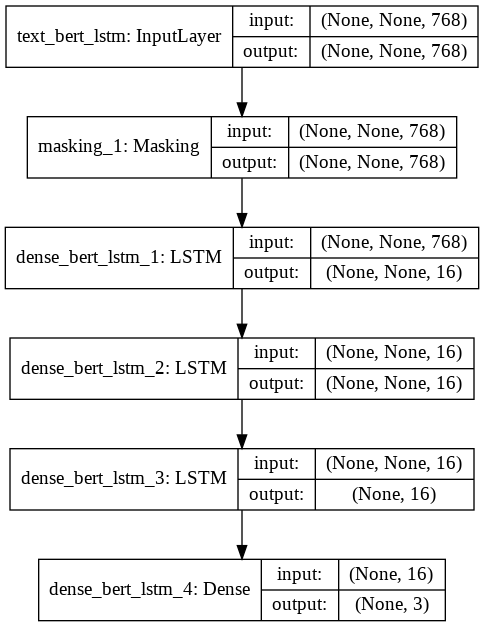

In [ ]:
# Save Topology Model in Image
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=dn.PATH_PROJECT + 'bert_fine_tuning_multitask_lstm.png', show_shapes=True, show_layer_names=True)

##### 1.8.4 BERT Embedding + CNN Model

In [ ]:
def bert_cnn_multitask():
  text_input = Input(shape=(None,768,), dtype='float32', name='text_bert_cnn')
  
  cnn_layer_1 = layers.Dropout(0.2, name='dense_bert_cnn_dout_1')(text_input)
  cnn_layer_2 = layers.Conv1D(filters=100, kernel_size=3,
                              kernel_initializer='glorot_uniform',
                              padding='valid', activation='relu',
                              name='dense_bert_cnn_conv_1')(cnn_layer_1)
  cnn_layer_3 = layers.GlobalAveragePooling1D(name='dense_bert_cnn_gbl_avg_pool_1')(cnn_layer_2)
  cnn_layer_4 = layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform',
                             name='dense_bert_cnn_')(cnn_layer_3)
  cnn_layer_5 = layers.Dropout(0.2, name='dense_bert_cnn_dout_2')(cnn_layer_4)

  out = layers.Dense(len(LABELS_SET), activation='sigmoid', 
                     name='dense_bert_cnn_6')(cnn_layer_5)

  model = Model(text_input, out)
  model.compile(optimizer='adadelta',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.summary()

  return model

In [ ]:
model = bert_cnn_multitask()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_bert_cnn (InputLayer)   (None, None, 768)         0         
_________________________________________________________________
dense_bert_cnn_dout_1 (Dropo (None, None, 768)         0         
_________________________________________________________________
dense_bert_cnn_conv_1 (Conv1 (None, None, 100)         230500    
_________________________________________________________________
dense_bert_cnn_gbl_avg_pool_ (None, 100)               0         
_________________________________________________________________
dense_bert_cnn_ (Dense)      (None, 100)               10100     
_________________________________________________________________
dense_bert_cnn_dout_2 (Dropo (None, 100)               0         
_________________________________________________________________
dense_bert_cnn_6 (Dense)     (None, 3)                 303 

In [ ]:
# Train model
history = model.fit_generator(train_generator(final_train_df, batch_size=20, batches_per_epoch=110), steps_per_epoch=110, epochs=10,
                              validation_data=val_generator(final_valid_df, batch_size_val=20, batches_per_epoch_val=110), validation_steps=110, callbacks =[call_reduce])

Epoch 1/10
110/110 [==============================] - 16s 143ms/step - loss: 6.2076 - acc: 0.6050 - val_loss: 6.1564 - val_acc: 0.6091
Epoch 2/10
110/110 [==============================] - 3s 28ms/step - loss: 6.4460 - acc: 0.5902 - val_loss: 6.1528 - val_acc: 0.6100
Epoch 3/10
110/110 [==============================] - 3s 30ms/step - loss: 6.1356 - acc: 0.6109 - val_loss: 6.1571 - val_acc: 0.6091
Epoch 4/10
110/110 [==============================] - 3s 29ms/step - loss: 6.1735 - acc: 0.6076 - val_loss: 7.2031 - val_acc: 0.5415

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.95.
Epoch 5/10
110/110 [==============================] - 3s 29ms/step - loss: 6.4480 - acc: 0.5892 - val_loss: 6.1621 - val_acc: 0.6086
Epoch 6/10
110/110 [==============================] - 3s 28ms/step - loss: 6.2412 - acc: 0.6017 - val_loss: 6.1600 - val_acc: 0.6086
Epoch 7/10
110/110 [==============================] - 3s 28ms/step - loss: 6.1276 - acc: 0.6097 - val_loss: 6.1610 - val_acc: 0.6083

Ep

In [ ]:
save_history(history, 'bert_fine_tuning_multitask_cnn_hst')

In [ ]:
model.save(dn.PATH_PROJECT + "bert_fine_tuning_multitask_cnn.h5")

In [ ]:
# Test Model
model.evaluate_generator(val_generator(final_test_df, batch_size_val=20, batches_per_epoch_val=110), steps=110)

[6.149624300003052, 0.6115151719613509]

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_df, batch_size_val=20, batches_per_epoch_val=110), steps=110)
y_test = np.array(final_test_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + CNN Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_cnn', 'bert_fine_tuning_multitask_cnn')

========= Metrics BERT Embedding + CNN Model =========
Correct Prediction per Label: [0.62       0.60318184 0.61136365]
Exact Match Ratio: 0.03363636363636364
Hamming Loss: 0.3884848484848485
Confusion Matrix: 
[[[1311    9]
  [ 827   53]]

 [[1306   14]
  [ 859   21]]

 [[1309   11]
  [ 844   36]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.85      0.06      0.11       880
     anxiety       0.60      0.02      0.05       880
  depression       0.77      0.04      0.08       880

   micro avg       0.76      0.04      0.08      2640
   macro avg       0.74      0.04      0.08      2640
weighted avg       0.74      0.04      0.08      2640
 samples avg       0.04      0.04      0.04      2640



=== Model Performance - Single-label Metrics ===
control
[[1311    9]
 [ 828   52]]
anxiety
[[1757    3]
 [ 436    4]]
depression
[[1747   13]
 [ 433    7]]
anxiety,depression
[[1744   16]
 [ 429   11]]

          

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_stk_df, batch_size_val=20, batches_per_epoch_val=22), steps=22)
y_test = np.array(final_test_stk_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + CNN Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_cnn_stk', 'bert_fine_tuning_multitask_cnn_stk')

========= Metrics BERT Embedding + CNN Model =========
Correct Prediction per Label: [0.6181818  0.59772724 0.6159091 ]
Exact Match Ratio: 0.02727272727272727
Hamming Loss: 0.3893939393939394
Confusion Matrix: 
[[[263   1]
  [167   9]]

 [[260   4]
  [173   3]]

 [[262   2]
  [167   9]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.90      0.05      0.10       176
     anxiety       0.43      0.02      0.03       176
  depression       0.82      0.05      0.10       176

   micro avg       0.75      0.04      0.08       528
   macro avg       0.72      0.04      0.08       528
weighted avg       0.72      0.04      0.08       528
 samples avg       0.04      0.04      0.04       528



=== Model Performance - Single-label Metrics ===
control
[[263   1]
 [167   9]]
anxiety
[[351   1]
 [ 88   0]]
depression
[[348   4]
 [ 87   1]]
anxiety,depression
[[348   4]
 [ 86   2]]

                      precision    rec

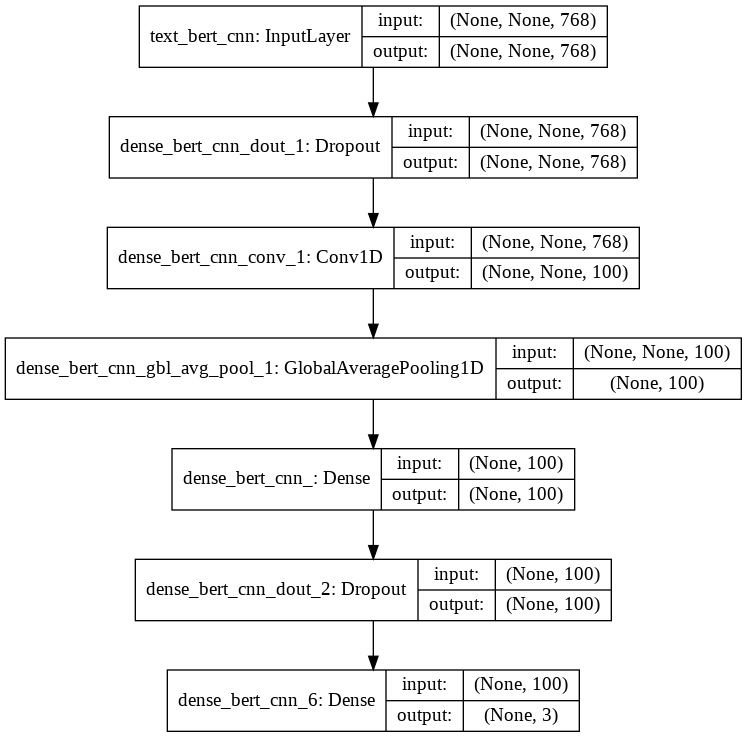

In [ ]:
# Save Topology Model in Image
plot_model(model, to_file=dn.PATH_PROJECT + 'bert_fine_tuning_multitask_cnn.png', show_shapes=True, show_layer_names=True)

##### 1.8.5 BERT Embedding + Hybrid Model

In [ ]:
def bert_hybrid_multitask():
  text_input = Input(shape=(None,768,), dtype='float32', name='text_bert_hybrid')

  hybrid_layer_1 = layers.Dropout(0.5, name='dense_bert_hybrid_dout_1')(text_input)
  hybrid_layer_2 = layers.Conv1D(filters=64, kernel_size=4,
                                 kernel_initializer='glorot_uniform',
                                 padding='valid', activation='relu',
                                 name='dense_bert_hybrid_conv_1')(hybrid_layer_1)
  hybrid_layer_3 = layers.MaxPooling1D(name='dense_bert_hybrid_max_pool_1')(hybrid_layer_2)
  hybrid_layer_4 = layers.LSTM(64, kernel_initializer='glorot_uniform',
                               activation='tanh', dropout=0.2,
                               recurrent_dropout=0.2,
                               return_sequences=True, name='dense_bert_hybrid_lstm_1')(hybrid_layer_3)
  hybrid_layer_5 = layers.LSTM(64, kernel_initializer='glorot_uniform',
                               activation='tanh', dropout=0.2,
                               recurrent_dropout=0.2,
                               return_sequences=True, name='dense_bert_hybrid_lstm_2')(hybrid_layer_4)
  hybrid_layer_6 = layers.LSTM(64, kernel_initializer='glorot_uniform', 
                               activation='tanh', dropout=0.2,
                               recurrent_dropout=0.2,
                               name='dense_bert_hybrid_lstm_3')(hybrid_layer_5)
  out = layers.Dense(len(LABELS_SET), activation='sigmoid', 
                     name='dense_bert_hybrid_dense_1')(hybrid_layer_6)

  model = Model(text_input, out)
  model.compile(optimizer='adadelta',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.summary()

  return model

In [ ]:
# Create Model
model = bert_hybrid_multitask()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_bert_hybrid (InputLayer (None, None, 768)         0         
_________________________________________________________________
dense_bert_hybrid_dout_1 (Dr (None, None, 768)         0         
_________________________________________________________________
dense_bert_hybrid_conv_1 (Co (None, None, 64)          196672    
_________________________________________________________________
dense_bert_hybrid_max_pool_1 (None, None, 64)          0         
_________________________________________________________________
dense_bert_hybrid_lstm_1 (LS (None, None, 64)          33024     
_________________________________________________________________
dense_bert_hybrid_lstm_2 (LS (None, None, 64)          33024     
_________________________________________________________________
dense_bert_hybrid_lstm_3 (LS (None, 64)                3302

In [ ]:
# Train model
history = model.fit_generator(train_generator(final_train_df, batch_size=20, batches_per_epoch=110), steps_per_epoch=110, epochs=50,
                              validation_data=val_generator(final_valid_df, batch_size_val=20, batches_per_epoch_val=110), validation_steps=110, callbacks =[call_reduce])

Epoch 1/50
110/110 [==============================] - 68s 621ms/step - loss: 0.4577 - acc: 0.7811 - val_loss: 0.6184 - val_acc: 0.7227
Epoch 2/50
110/110 [==============================] - 62s 560ms/step - loss: 0.4161 - acc: 0.8076 - val_loss: 0.6400 - val_acc: 0.7188
Epoch 3/50
110/110 [==============================] - 61s 553ms/step - loss: 0.4107 - acc: 0.8076 - val_loss: 0.6107 - val_acc: 0.7020
Epoch 4/50
110/110 [==============================] - 60s 548ms/step - loss: 0.3937 - acc: 0.8124 - val_loss: 0.6257 - val_acc: 0.7226

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.95.
Epoch 5/50
110/110 [==============================] - 62s 563ms/step - loss: 0.3896 - acc: 0.8138 - val_loss: 0.6107 - val_acc: 0.7192
Epoch 6/50
110/110 [==============================] - 62s 562ms/step - loss: 0.3821 - acc: 0.8173 - val_loss: 0.6350 - val_acc: 0.7248
Epoch 7/50
110/110 [==============================] - 61s 551ms/step - loss: 0.3833 - acc: 0.8155 - val_loss: 0.6482 - val_acc

In [ ]:
save_history(history, 'bert_fine_tuning_multitask_hybrid_hst')

In [ ]:
model.save(dn.PATH_PROJECT + "bert_fine_tuning_multitask_hybrid.h5")

In [ ]:
# Test Model
model.evaluate_generator(val_generator(final_test_df, batch_size_val=20, batches_per_epoch_val=110), steps=110)

[0.6303901872851632, 0.7254545699466358]

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_df, batch_size_val=20, batches_per_epoch_val=110), steps=110)
y_test = np.array(final_test_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + Hybrid Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_hybrid', 'bert_fine_tuning_multitask_hybrid')

========= Metrics BERT Embedding + Hybrid Model =========
Correct Prediction per Label: [0.8        0.7031818  0.67318183]
Exact Match Ratio: 0.46
Hamming Loss: 0.27454545454545454
Confusion Matrix: 
[[[1143  177]
  [ 263  617]]

 [[ 884  436]
  [ 217  663]]

 [[ 737  583]
  [ 136  744]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.78      0.70      0.74       880
     anxiety       0.60      0.75      0.67       880
  depression       0.56      0.85      0.67       880

   micro avg       0.63      0.77      0.69      2640
   macro avg       0.65      0.77      0.69      2640
weighted avg       0.65      0.77      0.69      2640
 samples avg       0.62      0.76      0.67      2640



=== Model Performance - Single-label Metrics ===
control
[[1143  177]
 [ 263  617]]
anxiety
[[1759    1]
 [ 438    2]]
depression
[[1588  172]
 [ 381   59]]
anxiety,depression
[[998 762]
 [106 334]]

                      pre

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_stk_df, batch_size_val=20, batches_per_epoch_val=22), steps=22)
y_test = np.array(final_test_stk_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + Hybrid Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_hybrid_stk', 'bert_fine_tuning_multitask_hybrid_stk')

========= Metrics BERT Embedding + Hybrid Model =========
Correct Prediction per Label: [0.76363635 0.7090909  0.6522727 ]
Exact Match Ratio: 0.4340909090909091
Hamming Loss: 0.2916666666666667
Confusion Matrix: 
[[[223  41]
  [ 63 113]]

 [[183  81]
  [ 47 129]]

 [[145 119]
  [ 34 142]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.73      0.64      0.68       176
     anxiety       0.61      0.73      0.67       176
  depression       0.54      0.81      0.65       176

   micro avg       0.61      0.73      0.67       528
   macro avg       0.63      0.73      0.67       528
weighted avg       0.63      0.73      0.67       528
 samples avg       0.60      0.71      0.63       528



=== Model Performance - Single-label Metrics ===
control
[[223  41]
 [ 63 113]]
anxiety
[[350   2]
 [ 87   1]]
depression
[[310  42]
 [ 76  12]]
anxiety,depression
[[210 142]
 [ 23  65]]

                      precision    r

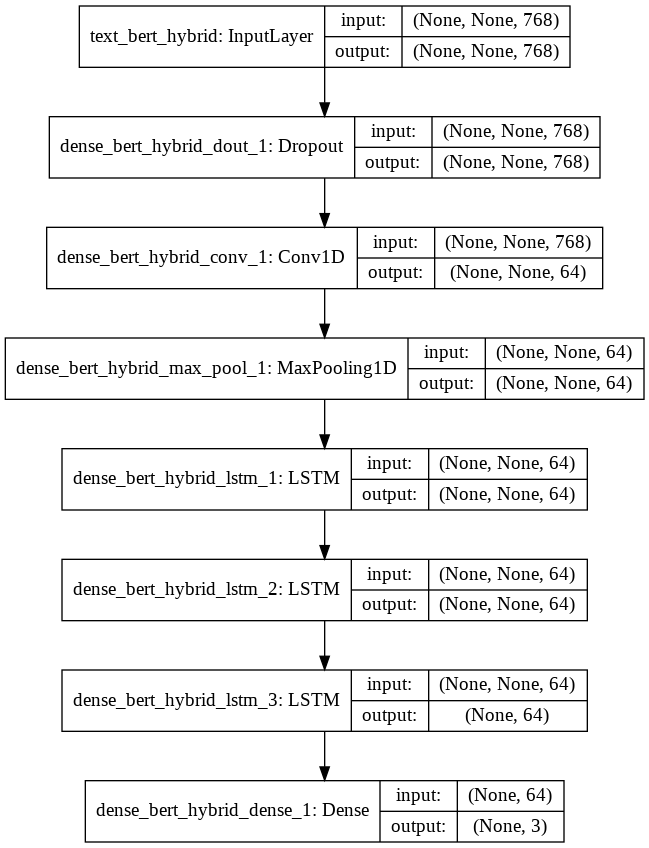

In [ ]:
# Save Topology Model in Image
plot_model(model, to_file=dn.PATH_PROJECT + 'bert_fine_tuning_multitask_hybrid.png', show_shapes=True, show_layer_names=True)

##### 1.8.6 BERT Embedding + CNN without first dropout layer

In [ ]:
def bert_cnn_wd_multitask():
  text_input = Input(shape=(None,768,), dtype='float32', name='text_bert_cnn')
  
  # cnn_layer_1 = layers.Dropout(0.2, name='dense_bert_cnn_dout_1')(text_input)
  cnn_layer_2 = layers.Conv1D(filters=100, kernel_size=3,
                              kernel_initializer='glorot_uniform',
                              padding='valid', activation='relu',
                              name='dense_bert_cnn_conv_1')(text_input)
  cnn_layer_3 = layers.GlobalAveragePooling1D(name='dense_bert_cnn_gbl_avg_pool_1')(cnn_layer_2)
  cnn_layer_4 = layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform',
                             name='dense_bert_cnn_')(cnn_layer_3)
  cnn_layer_5 = layers.Dropout(0.2, name='dense_bert_cnn_dout_2')(cnn_layer_4)

  out = layers.Dense(len(LABELS_SET), activation='sigmoid', 
                     name='dense_bert_cnn_6')(cnn_layer_5)

  model = Model(text_input, out)
  model.compile(optimizer='adadelta',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.summary()

  return model

In [ ]:
model = bert_cnn_wd_multitask()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_bert_cnn (InputLayer)   (None, None, 768)         0         
_________________________________________________________________
dense_bert_cnn_conv_1 (Conv1 (None, None, 100)         230500    
_________________________________________________________________
dense_bert_cnn_gbl_avg_pool_ (None, 100)               0         
_________________________________________________________________
dense_bert_cnn_ (Dense)      (None, 100)               10100     
_________________________________________________________________
dense_bert_cnn_dout_2 (Dropo (None, 100)               0         
_________________________________________________________________
dense_bert_cnn_6 (Dense)     (None, 3)                 303       
Total params: 240,903
Trainable params: 240,903
Non-trainable params: 0
_____________________________________________________

In [ ]:
# Train model
history = model.fit_generator(train_generator(final_train_df, batch_size=20, batches_per_epoch=110), steps_per_epoch=110, epochs=10,
                              validation_data=val_generator(final_valid_df, batch_size_val=20, batches_per_epoch_val=110), validation_steps=110, callbacks =[call_reduce])

Epoch 1/10
110/110 [==============================] - 5s 41ms/step - loss: 7.1880 - acc: 0.5397 - val_loss: 6.1581 - val_acc: 0.6089
Epoch 2/10
110/110 [==============================] - 3s 25ms/step - loss: 6.2038 - acc: 0.6064 - val_loss: 6.1558 - val_acc: 0.6103
Epoch 3/10
110/110 [==============================] - 3s 24ms/step - loss: 6.4270 - acc: 0.5915 - val_loss: 6.1600 - val_acc: 0.6088
Epoch 4/10
110/110 [==============================] - 3s 25ms/step - loss: 6.1678 - acc: 0.6056 - val_loss: 6.1568 - val_acc: 0.6100

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.95.
Epoch 5/10
110/110 [==============================] - 3s 24ms/step - loss: 6.1486 - acc: 0.6085 - val_loss: 6.1587 - val_acc: 0.6088
Epoch 6/10
110/110 [==============================] - 3s 26ms/step - loss: 6.4342 - acc: 0.5895 - val_loss: 6.1567 - val_acc: 0.6092
Epoch 7/10
110/110 [==============================] - 3s 25ms/step - loss: 6.1664 - acc: 0.6089 - val_loss: 6.1644 - val_acc: 0.6085

Epoc

In [ ]:
save_history(history, 'bert_fine_tuning_multitask_cnn_wd_hst')

In [ ]:
model.save(dn.PATH_PROJECT + "bert_fine_tuning_multitask_cnn_wd.h5")

In [ ]:
# Test Model
model.evaluate_generator(val_generator(final_test_df, batch_size_val=20, batches_per_epoch_val=110), steps=110)

[6.14220569783991, 0.6115151719613509]

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_df, batch_size_val=20, batches_per_epoch_val=110), steps=110)
y_test = np.array(final_test_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + CNN Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_cnn_wd', 'bert_fine_tuning_multitask_cnn_wd')

========= Metrics BERT Embedding + CNN Model =========
Correct Prediction per Label: [0.61954546 0.60318184 0.6118182 ]
Exact Match Ratio: 0.031363636363636364
Hamming Loss: 0.3884848484848485
Confusion Matrix: 
[[[1313    7]
  [ 830   50]]

 [[1303   17]
  [ 856   24]]

 [[1311    9]
  [ 845   35]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.88      0.06      0.11       880
     anxiety       0.59      0.03      0.05       880
  depression       0.80      0.04      0.08       880

   micro avg       0.77      0.04      0.08      2640
   macro avg       0.75      0.04      0.08      2640
weighted avg       0.75      0.04      0.08      2640
 samples avg       0.04      0.04      0.04      2640



=== Model Performance - Single-label Metrics ===
control
[[1315    5]
 [ 832   48]]
anxiety
[[1756    4]
 [ 436    4]]
depression
[[1749   11]
 [ 436    4]]
anxiety,depression
[[1744   16]
 [ 427   13]]

         

In [ ]:
# Metrics Test Set
predicts = model.predict_generator(val_generator(final_test_stk_df, batch_size_val=20, batches_per_epoch_val=22), steps=22)
y_test = np.array(final_test_stk_df.label.to_list(), dtype='float32')

print("========= Metrics BERT Embedding + CNN Model =========")
multitask_metrics(y_test, predicts, LABELS_SET, 'bert_fine_tuning_multitask_cnn_wd_stk', 'bert_fine_tuning_multitask_cnn_wd_stk')

========= Metrics BERT Embedding + CNN Model =========
Correct Prediction per Label: [0.6181818 0.5931818 0.6159091]
Exact Match Ratio: 0.02727272727272727
Hamming Loss: 0.39090909090909093
Confusion Matrix: 
[[[263   1]
  [167   9]]

 [[258   6]
  [173   3]]

 [[262   2]
  [167   9]]]
=== Model Performance - Multi-label Metrics ===
              precision    recall  f1-score   support

     control       0.90      0.05      0.10       176
     anxiety       0.33      0.02      0.03       176
  depression       0.82      0.05      0.10       176

   micro avg       0.70      0.04      0.08       528
   macro avg       0.68      0.04      0.08       528
weighted avg       0.68      0.04      0.08       528
 samples avg       0.04      0.04      0.04       528



=== Model Performance - Single-label Metrics ===
control
[[264   0]
 [168   8]]
anxiety
[[351   1]
 [ 88   0]]
depression
[[348   4]
 [ 87   1]]
anxiety,depression
[[349   3]
 [ 85   3]]

                      precision    recal

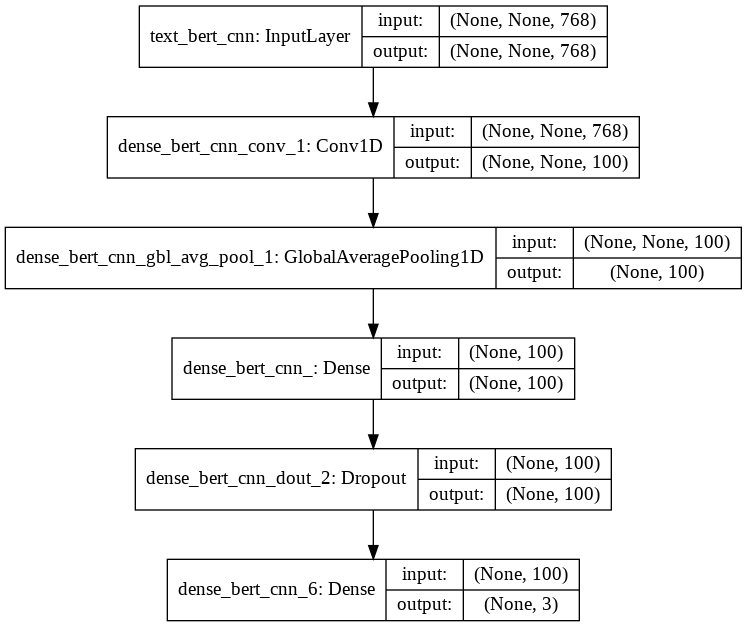

In [ ]:
plot_model(model, to_file=dn.PATH_PROJECT + 'bert_fine_tuning_multitask_cnn_wd.png', show_shapes=True, show_layer_names=True)